In [1]:
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, Dense,Flatten
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping



In [2]:
#df_failures=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_failures.csv")
#df_machines=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_machines.csv")
#df_telemetry=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_telemetry.csv")
#df_errors=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_errors.csv")
#df_failures.to_csv('equipment_failures.csv')
#df_machines.to_csv('equipment_machines.csv')
#df_telemetry.to_csv('equipment_telemetry.csv')
#df_errors.to_csv('equipment_errors.csv')

In [30]:
df_failures=pd.read_csv('equipment_failures.csv')
df_machines=pd.read_csv('equipment_machines.csv')
df_telemetry=pd.read_csv('equipment_telemetry.csv')
df_errors=pd.read_csv('equipment_errors.csv')

#print(df_machines.head())
#print(df_machines.columns)
#print(df_failures.head())
#print(df_telemetry.head())

df=pd.merge(df_telemetry,df_errors,on=['machineID','datetime'],how="left")
print(df.columns)
df=pd.merge(df,df_failures,on=['machineID','datetime'], how="left")
df=pd.merge(df,df_machines,on='machineID',how="left")

print(len(df))
print(df.columns)


Index(['Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
       'vibration', 'Unnamed: 0_y', 'errorID'],
      dtype='object')
876445
Index(['Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
       'vibration', 'Unnamed: 0_y', 'errorID', 'Unnamed: 0_x', 'failure',
       'Unnamed: 0_y', 'model', 'age'],
      dtype='object')


C:\Users\dnishimoto\AppData\Local\Temp\ipykernel_9592\1311983422.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df=pd.merge(df,df_machines,on='machineID',how="left")


Discover what the data looks like for the first 100 transactions


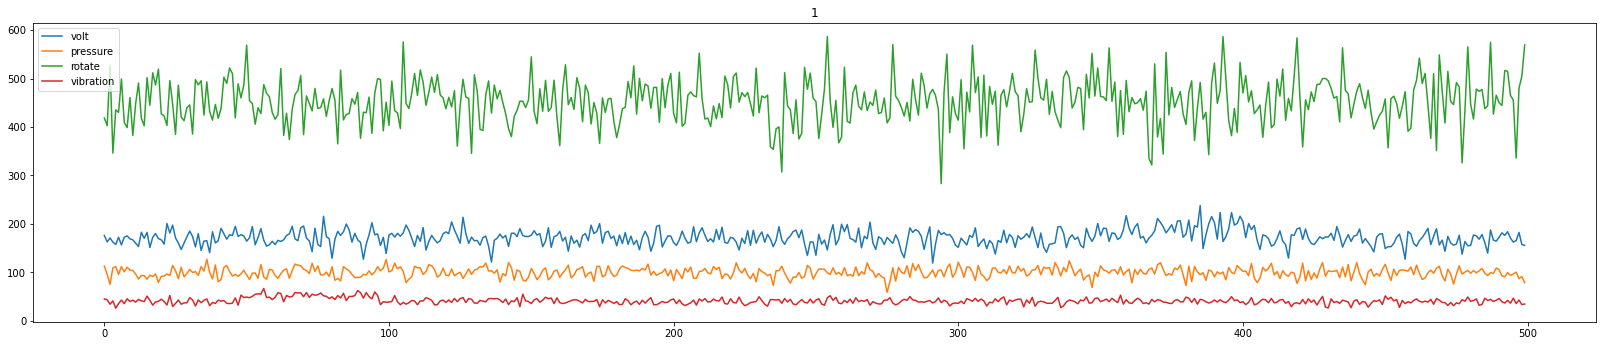

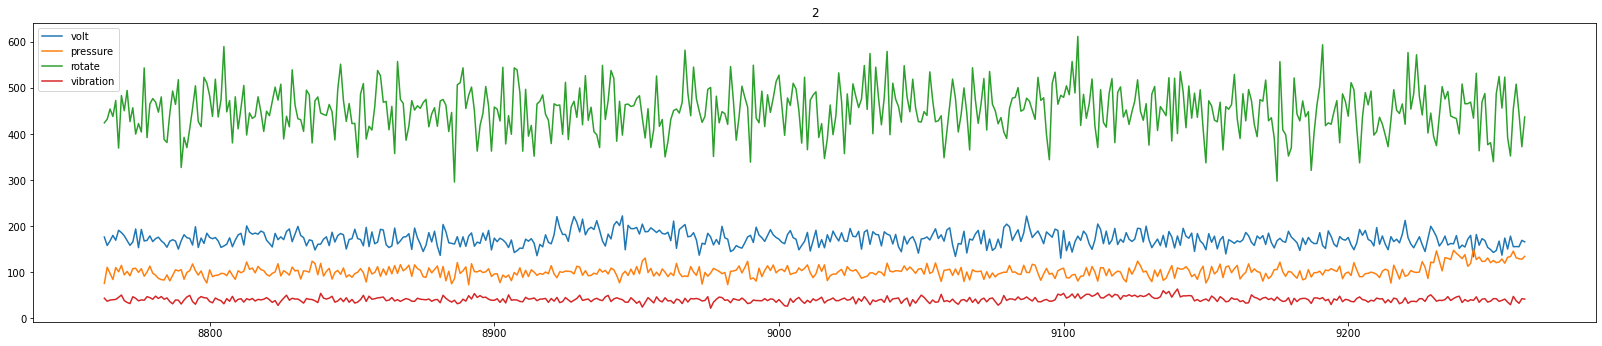

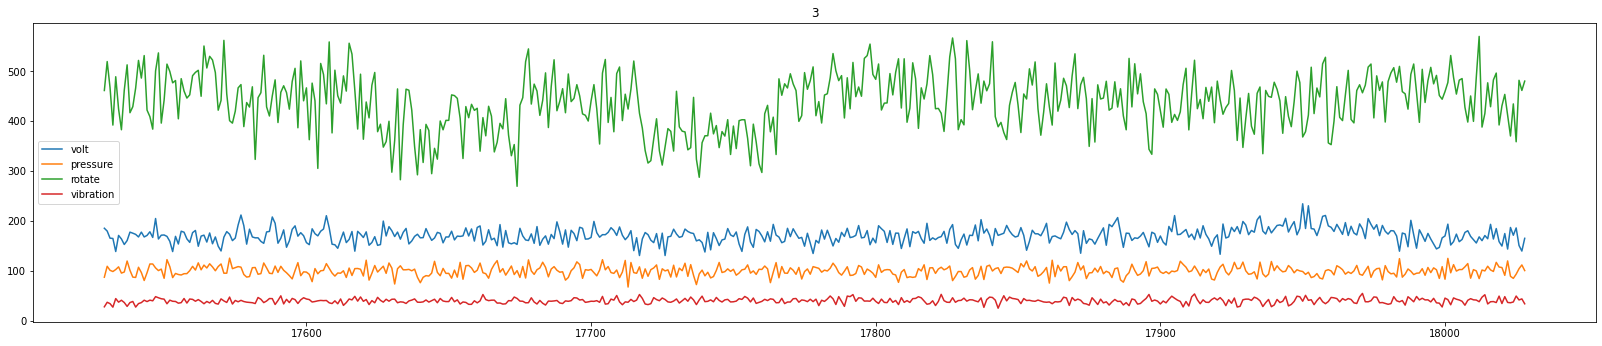

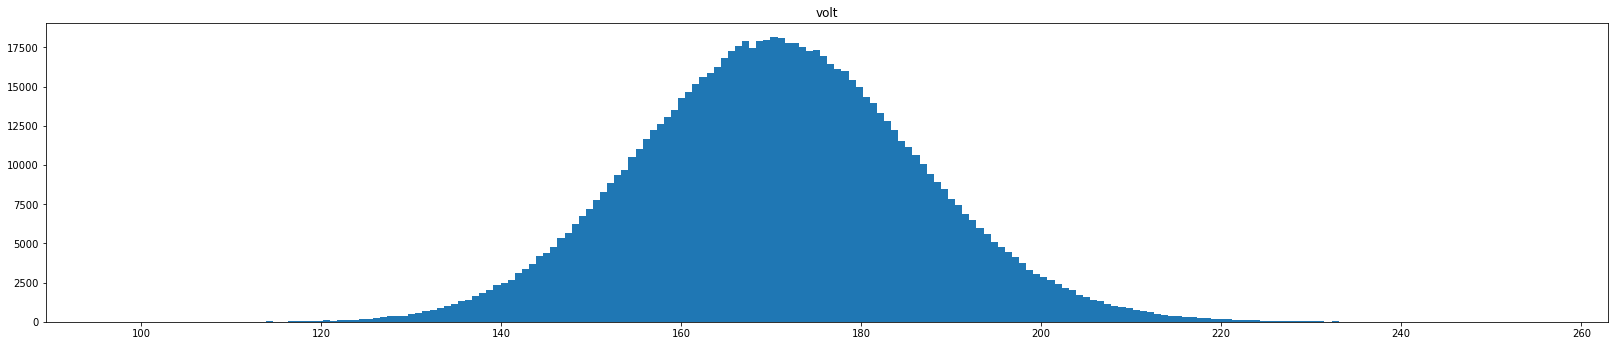

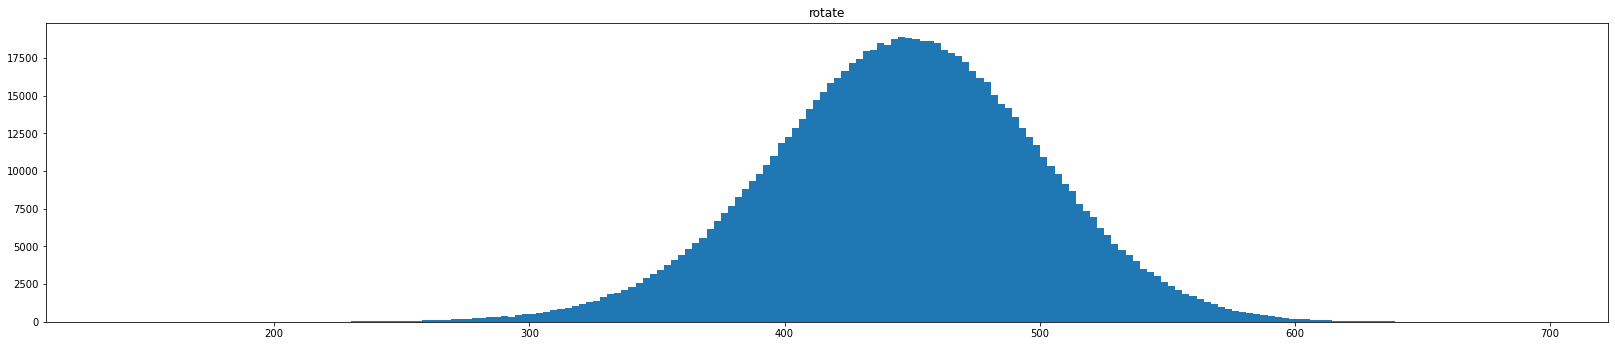

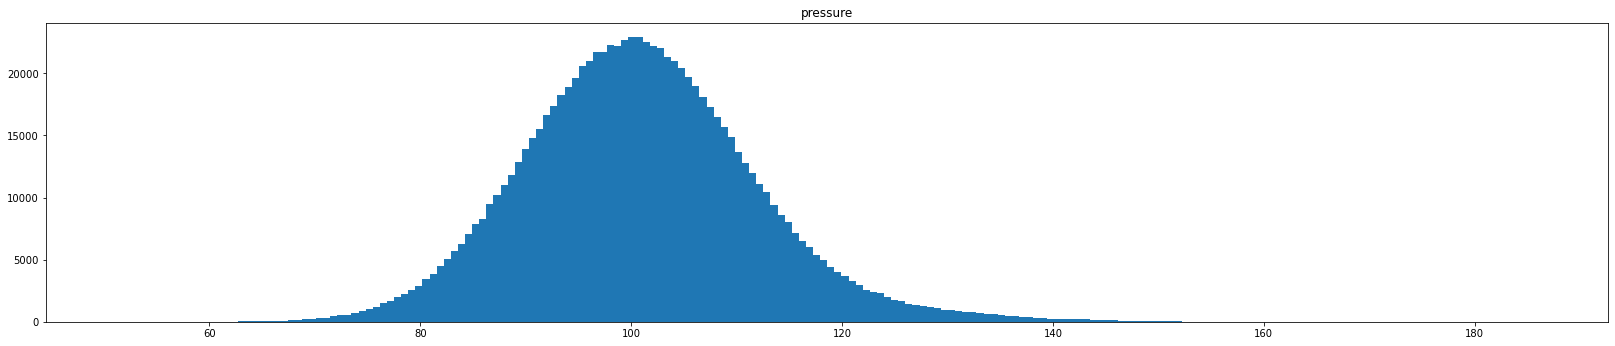

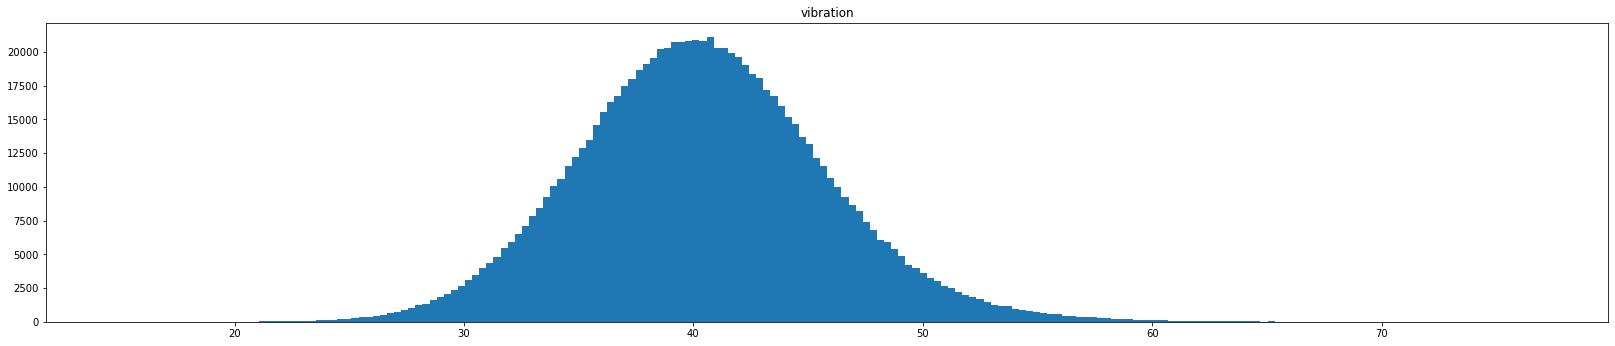

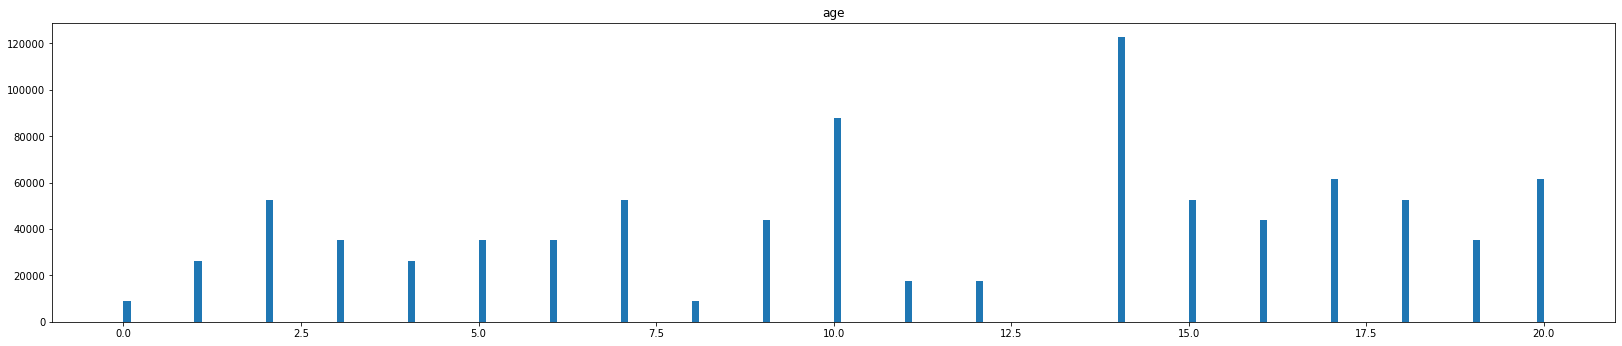

In [31]:
#'machineID', 'label', 'model', 'age', 'volt', 'rotate', 'pressure'
print("Discover what the data looks like for the first 100 transactions")
machineIds=[]
grouped=df.groupby('machineID')
for machineID in grouped:
    machineIds.append(machineID[0])

#print(machineIds)
plt.rcParams["figure.figsize"] = (28,5.5)
for machineId in machineIds[0:3]:
    #print(machineId)
    filter=df['machineID']==machineId
    results=df[filter][:500]
    #print(len(results))
    #print(results['datetime_x'])
    x=range(0,len(results)-1,1)
    plt.plot(results['volt'],label='volt')
    plt.plot(results['pressure'],label='pressure')
    plt.plot(results['rotate'],label='rotate')
    plt.plot(results['vibration'],label='vibration')
    #twin_ax=plt.twinx()
    #twin_ax.plot(results['age'],label='age')
    plt.title(machineId)
    plt.legend()
    plt.show()
    
columns=[column for column in df.columns if column in['age','vibration','rotate','pressure','volt']]
for column in columns:
    plt.hist(df[column],bins=200)
    plt.title(column)
    plt.show()



In [37]:
#'Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
#       'vibration', 'Unnamed: 0_y', 'errorID', 'Unnamed: 0_x', 'failure',
#       'Unnamed: 0_y', 'model', 'age'
        
print("Drop non contributing features and dummy the multi-class output")
if "datetime" in df:
    df.drop(["Unnamed: 0_x","Unnamed: 0_y","datetime","failure"],axis=1,inplace=True)
    df.rename(columns={"errorID":"label"},inplace=True)

print(df.columns)

failure_types=set(df['label'])
print(failure_types)

encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['label'])
df['model']=encoder.fit_transform(df['model'])

X_columns=[x for x in df.columns if x!='label']

X=df[X_columns]
y=df['label']
#y = np.asarray(y).astype(np.float32)
y = pd.get_dummies(y)

print(y)

print(df.columns)
print(df.head(1))

Drop non contributing features and dummy the multi-class output
Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'label',
       'model', 'age'],
      dtype='object')
{0, 1, 2, 3, 4, 5}
        0  1  2  3  4  5
0       0  0  0  0  0  1
1       0  0  0  0  0  1
2       0  0  0  0  0  1
3       0  0  0  0  0  1
4       0  0  0  0  0  1
...    .. .. .. .. .. ..
876440  0  0  0  0  0  1
876441  0  0  0  0  0  1
876442  0  0  0  0  0  1
876443  0  0  0  0  0  1
876444  0  0  0  0  0  1

[876445 rows x 6 columns]
Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'label',
       'model', 'age'],
      dtype='object')
   machineID        volt      rotate    pressure  vibration  label  model  age
0          1  176.217853  418.504078  113.077935  45.087686      5      2   18


In [38]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

print(X_train.columns)
print("rows",X_train.shape[0],"columns",X_train.shape[1])
print((X_train.shape[0],X_train.shape[1],1))

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'model', 'age'], dtype='object')
rows 587218 columns 7
(587218, 7, 1)


In [41]:
print("build the LSTM model")
look_back=1
model = Sequential()
features=len(X_columns)
model.add(LSTM(units=550, activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
model.add(Dropout(0.2))
model.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model.add(LSTM(units = 50))
model.add(Flatten())
model.add(Dense(len(y_train.columns),activation='softmax'))
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

build the LSTM model


In [42]:
print("X train shape",X_train.shape)
#print(X_train)
print("y train shape",y_train.shape)


X train shape (587218, 7)
y train shape (587218, 6)


Train the model
0 64


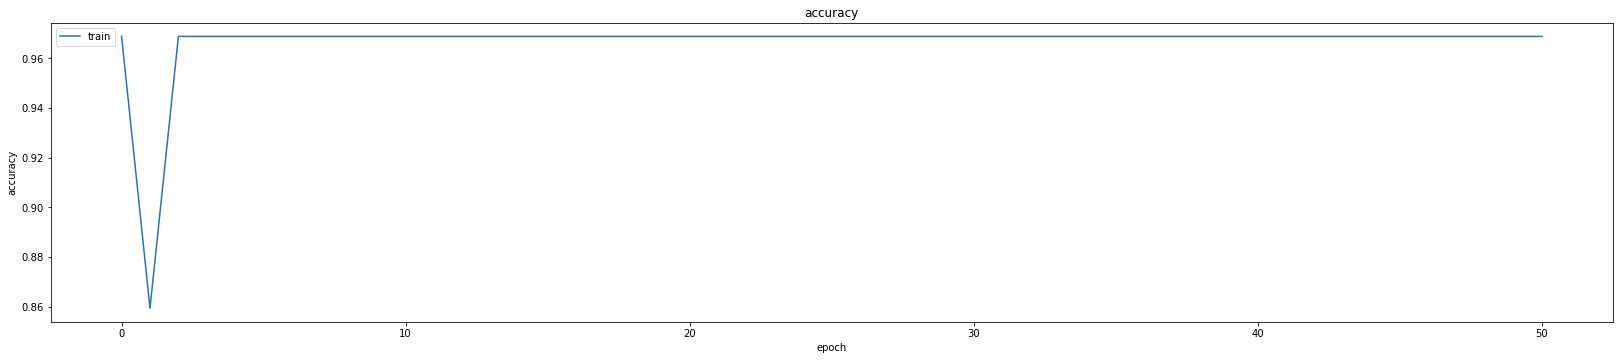

64 128


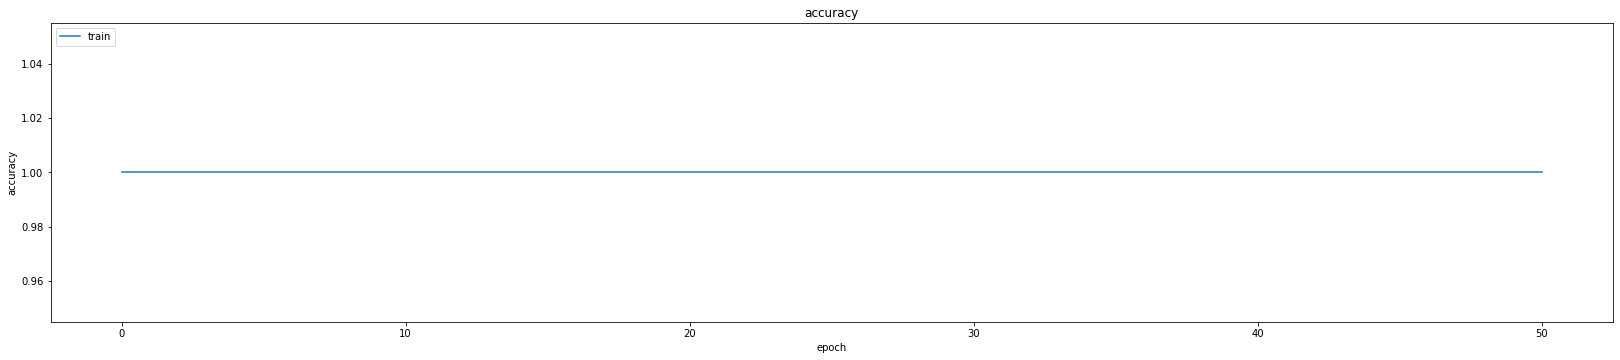

128 192


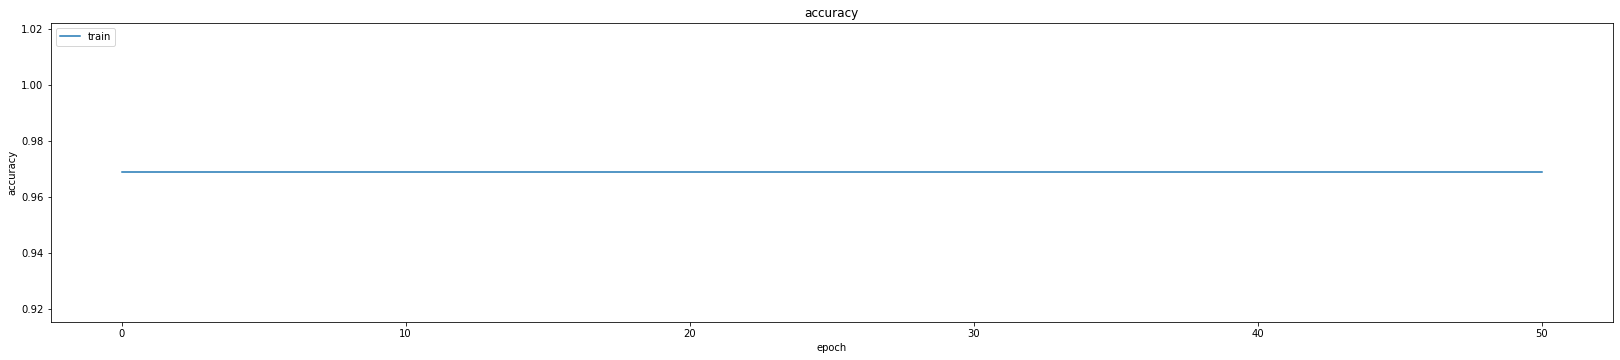

192 256


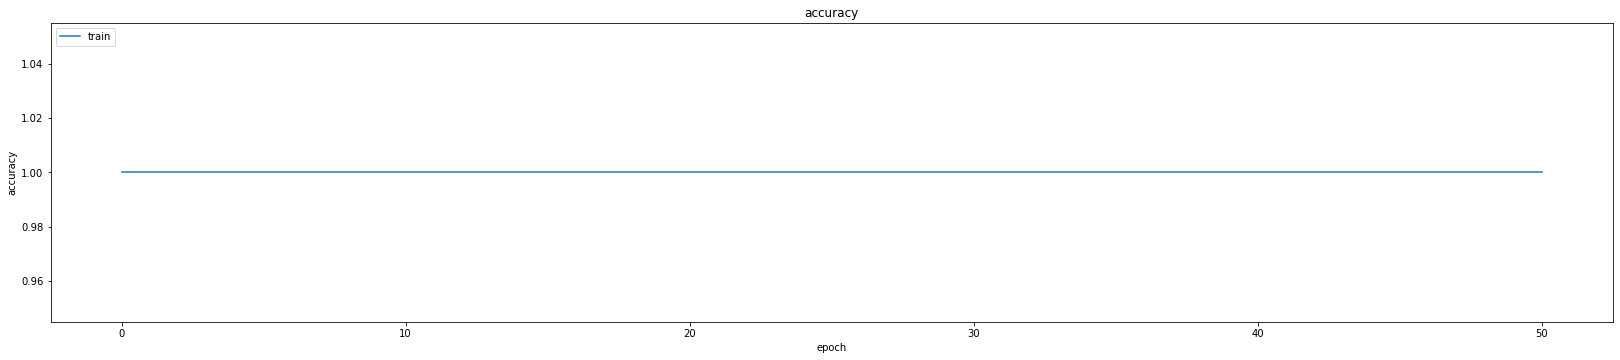

256 320


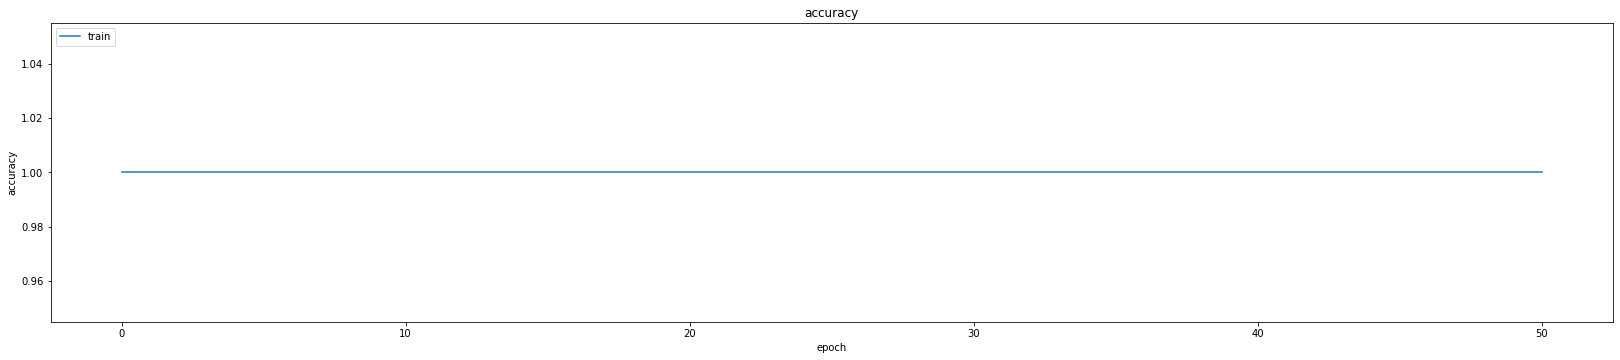

320 384


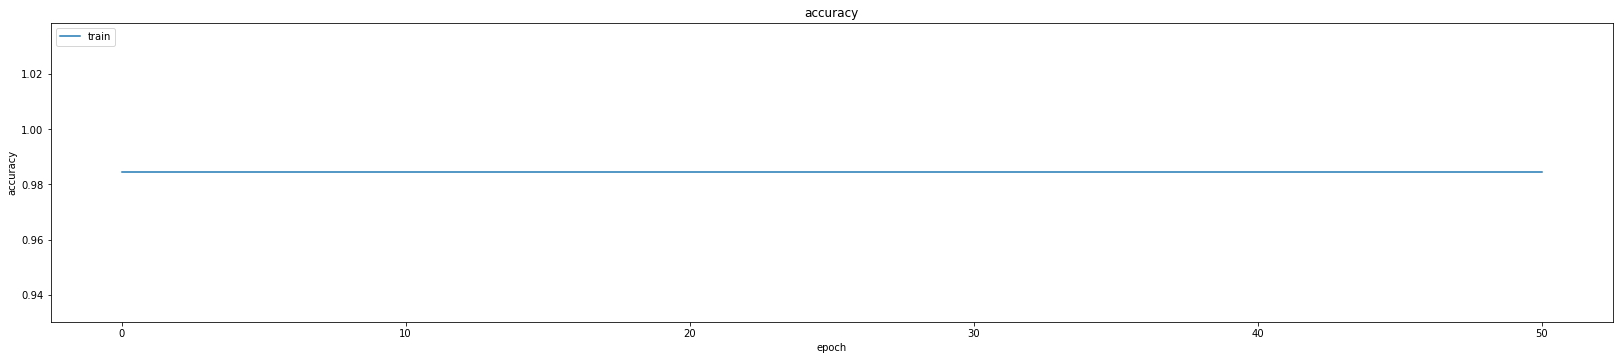

384 448


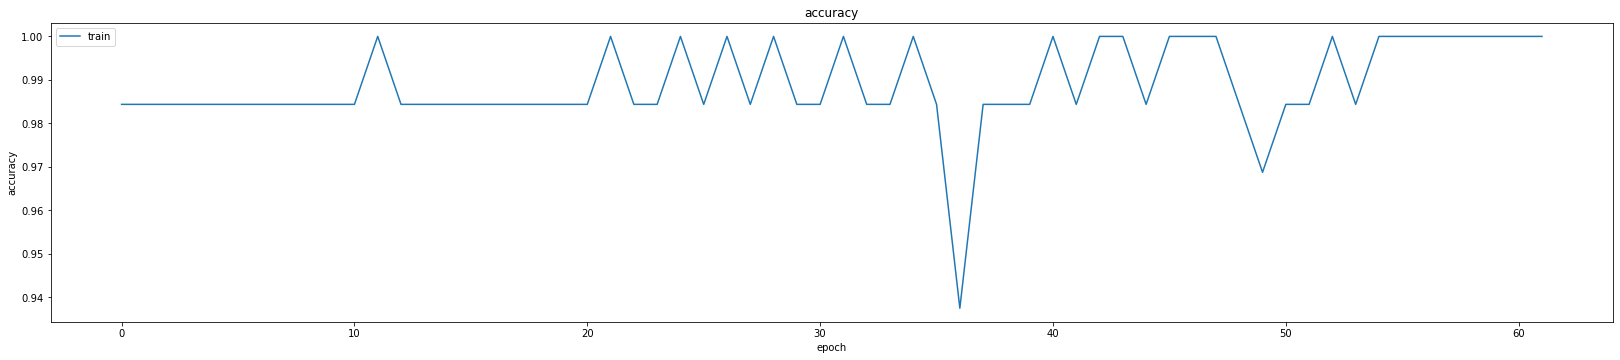

448 512


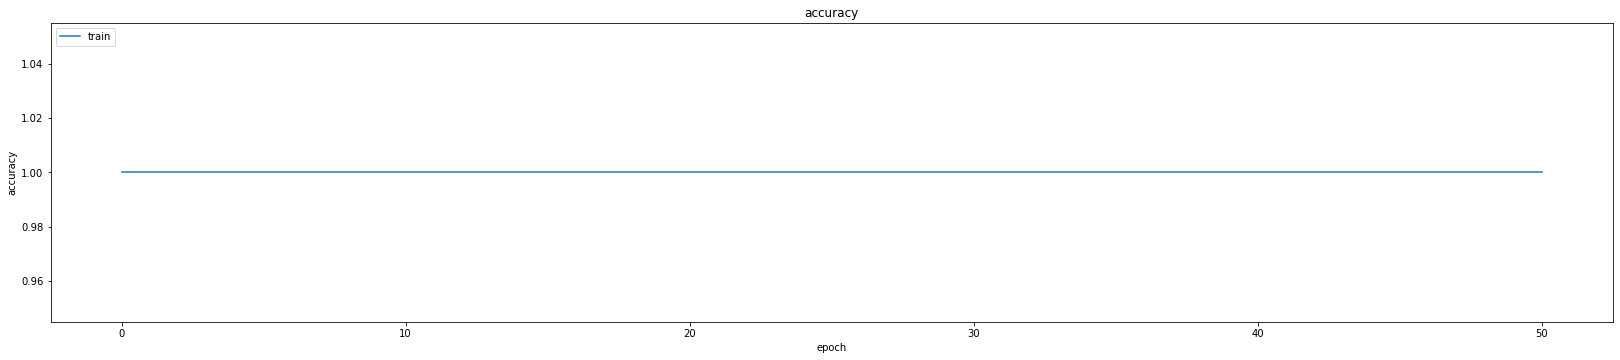

512 576


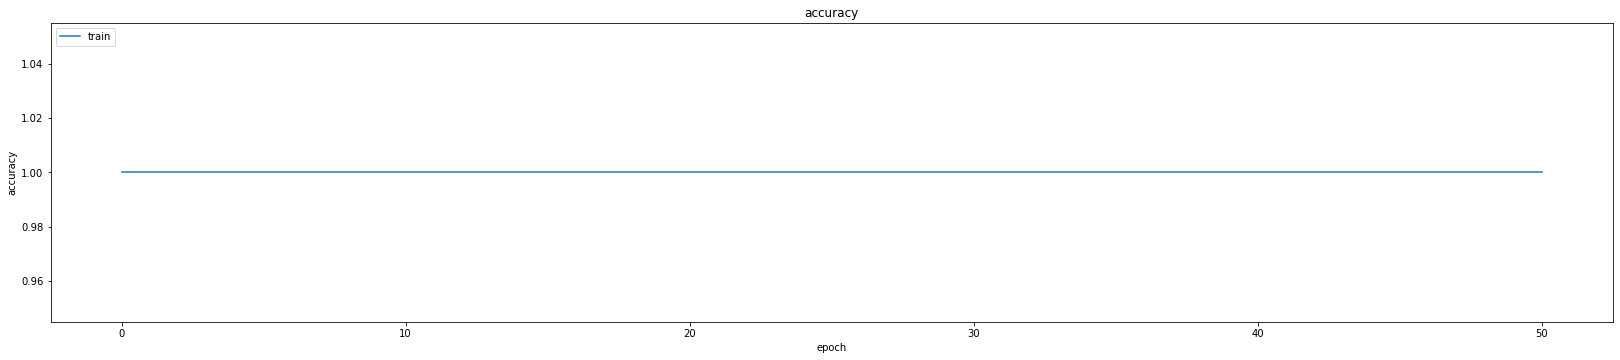

576 640


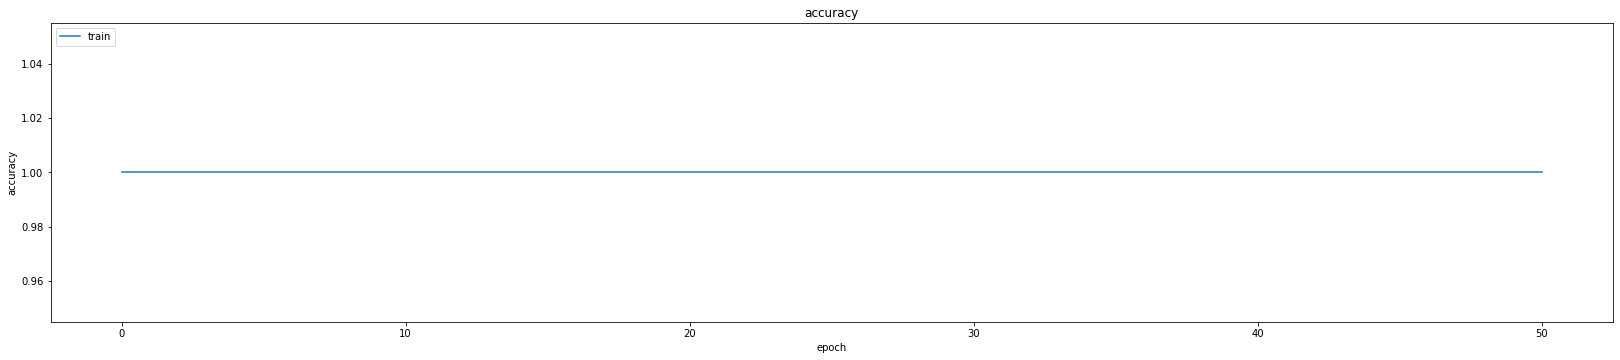

640 704


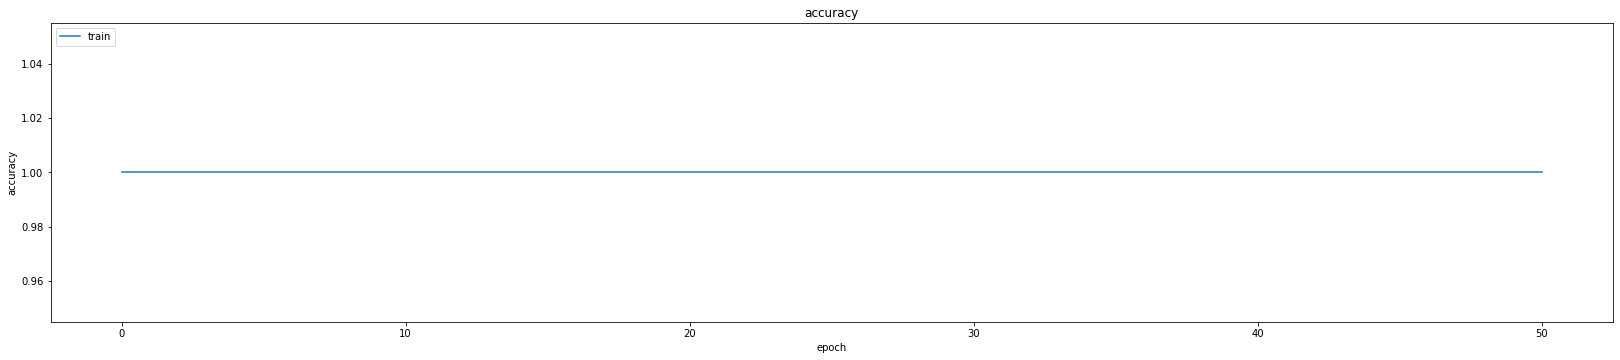

704 768


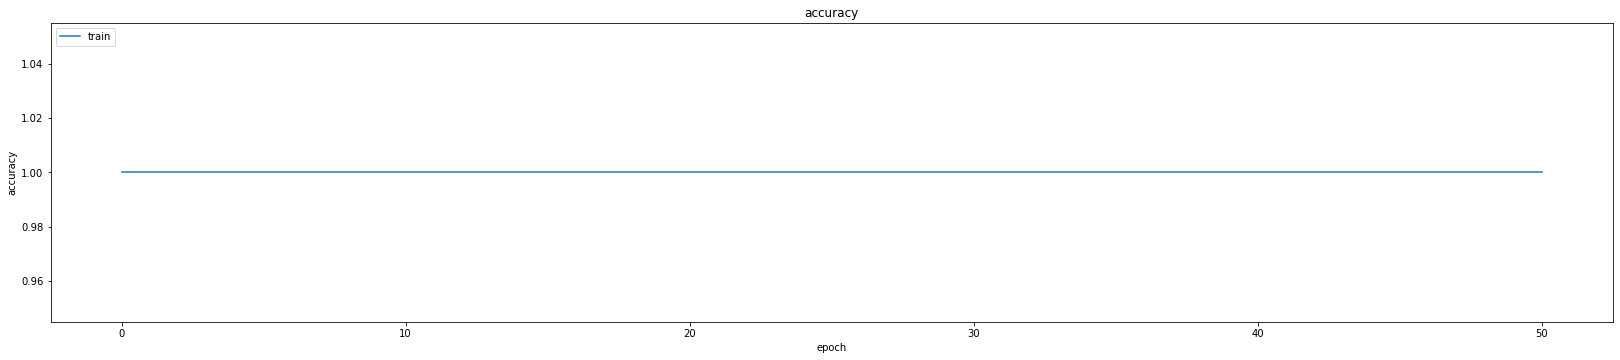

768 832


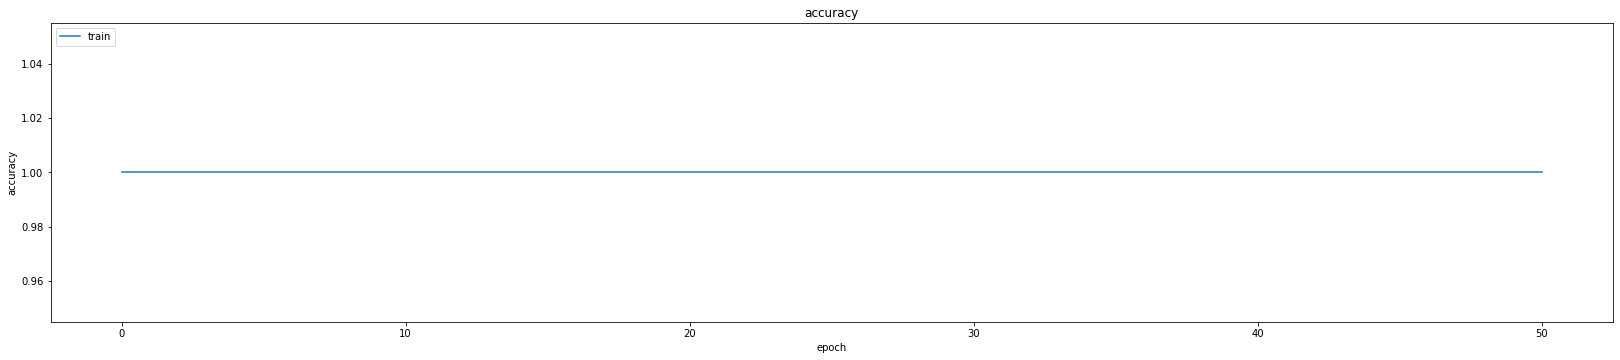

832 896


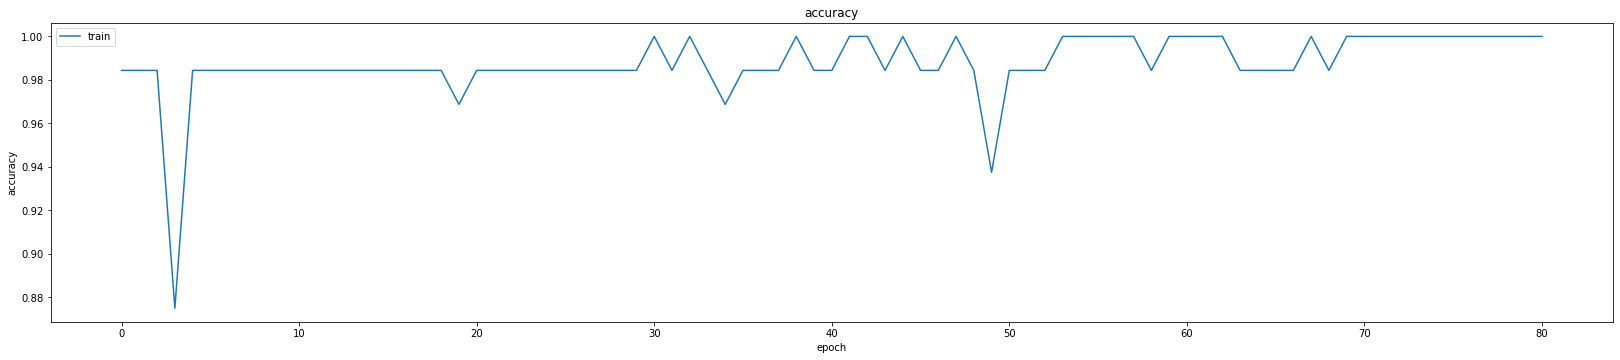

896 960


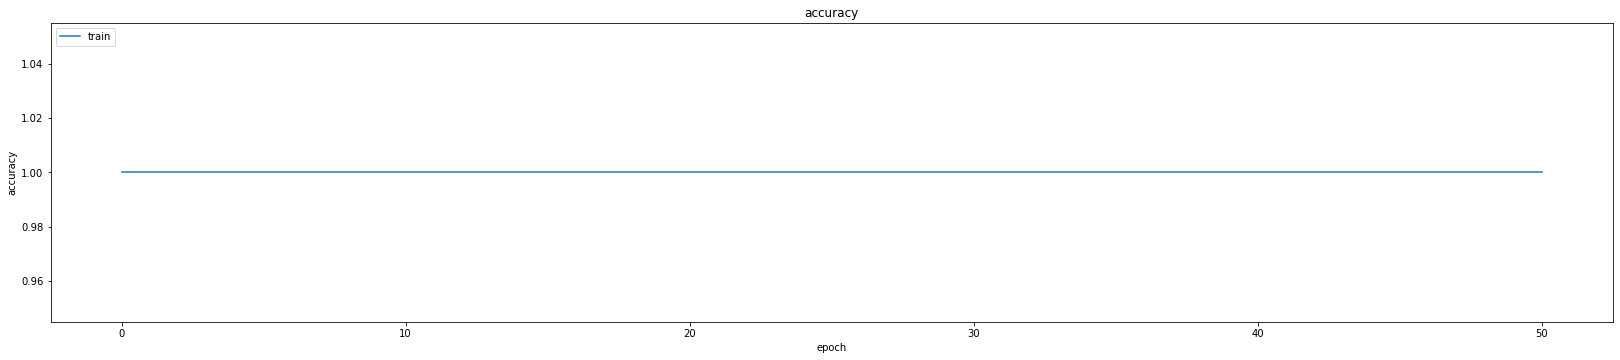

960 1024


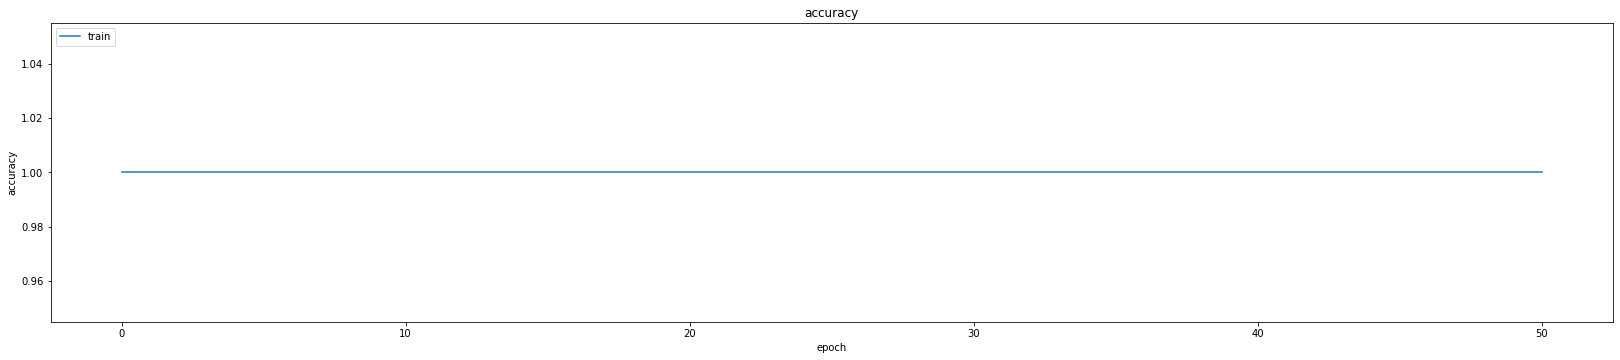

1024 1088


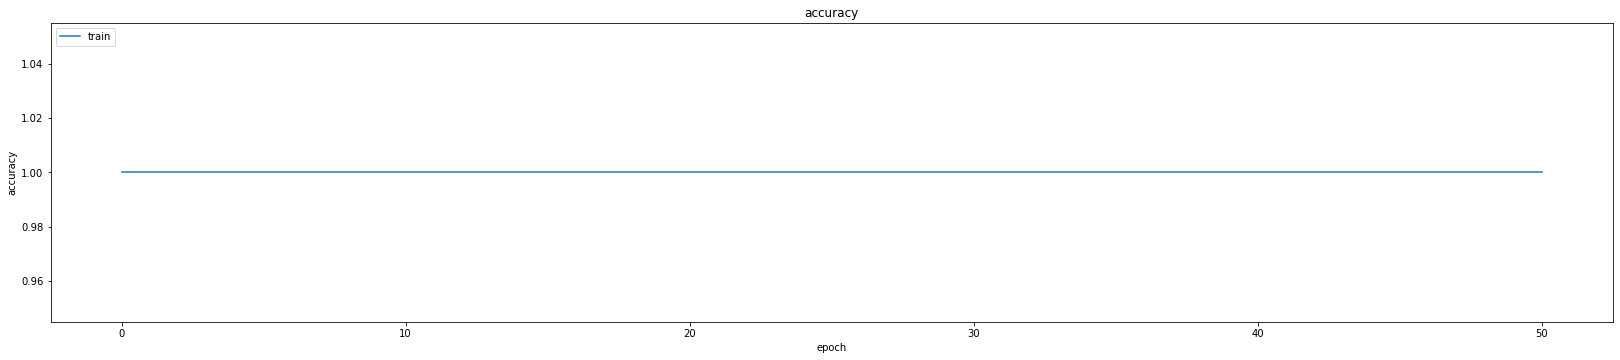

1088 1152


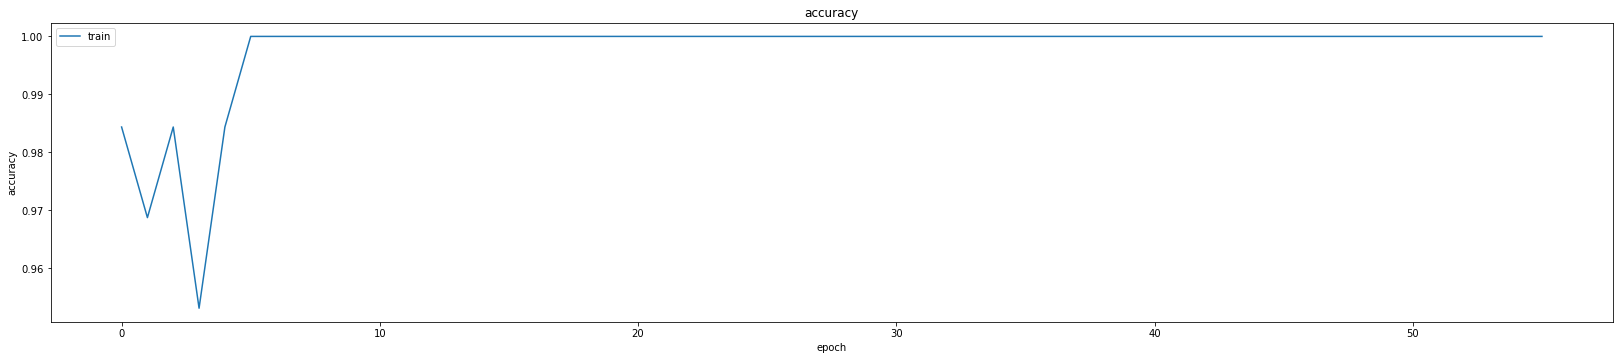

1152 1216


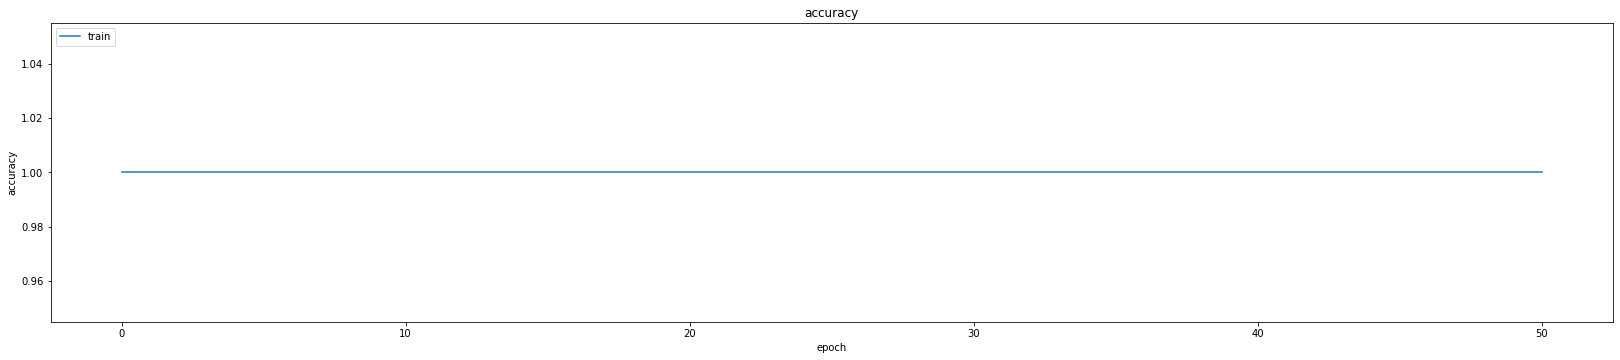

1216 1280


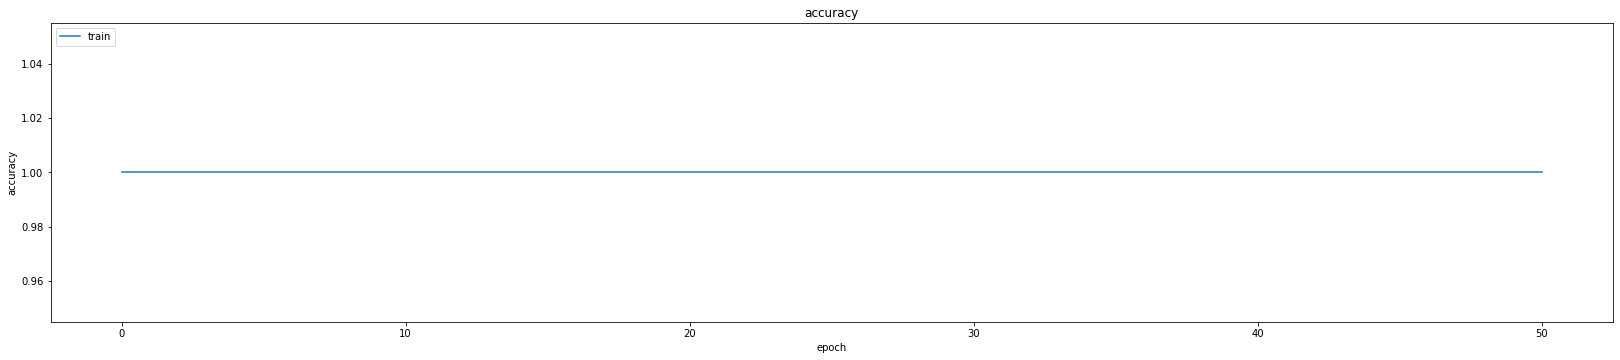

1280 1344


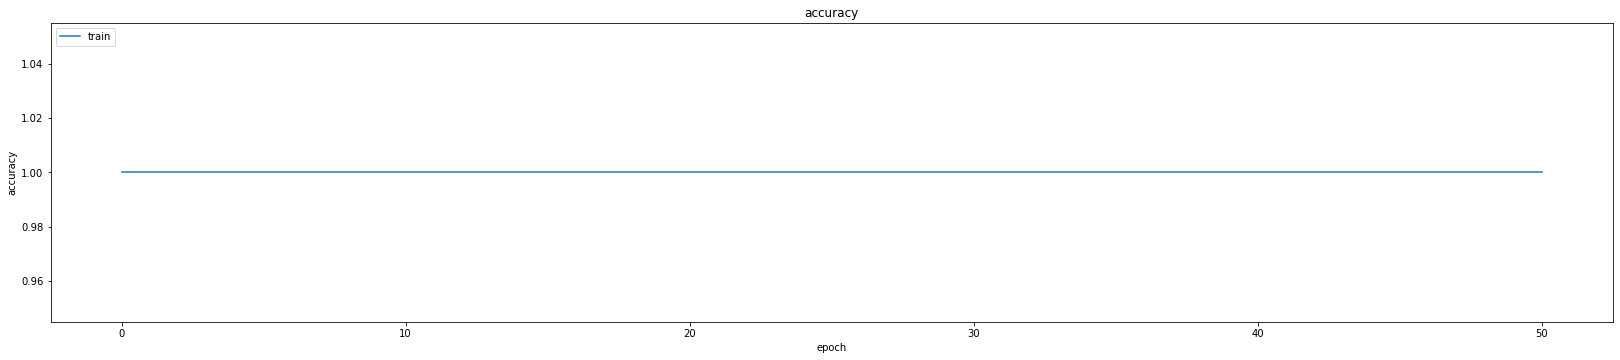

1344 1408


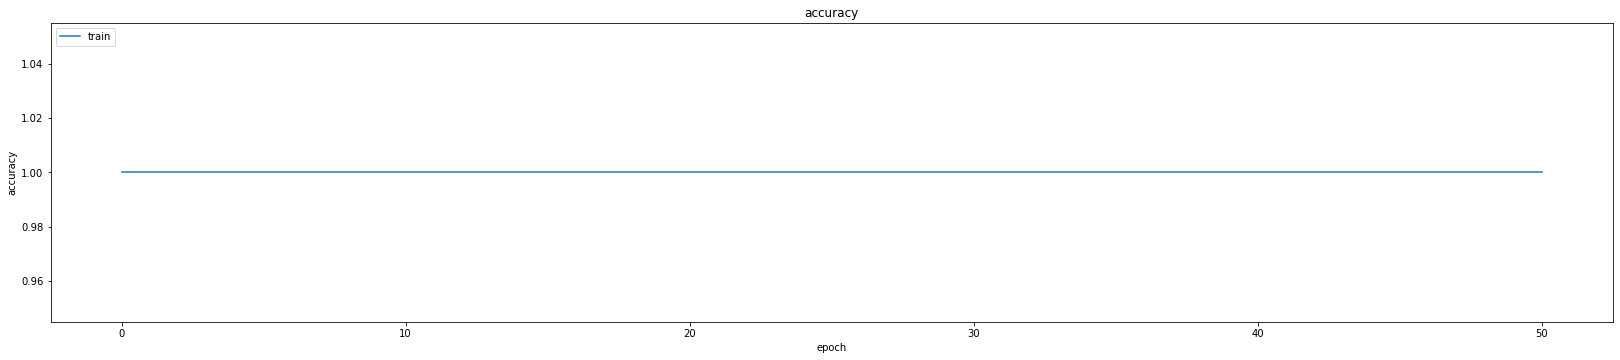

1408 1472


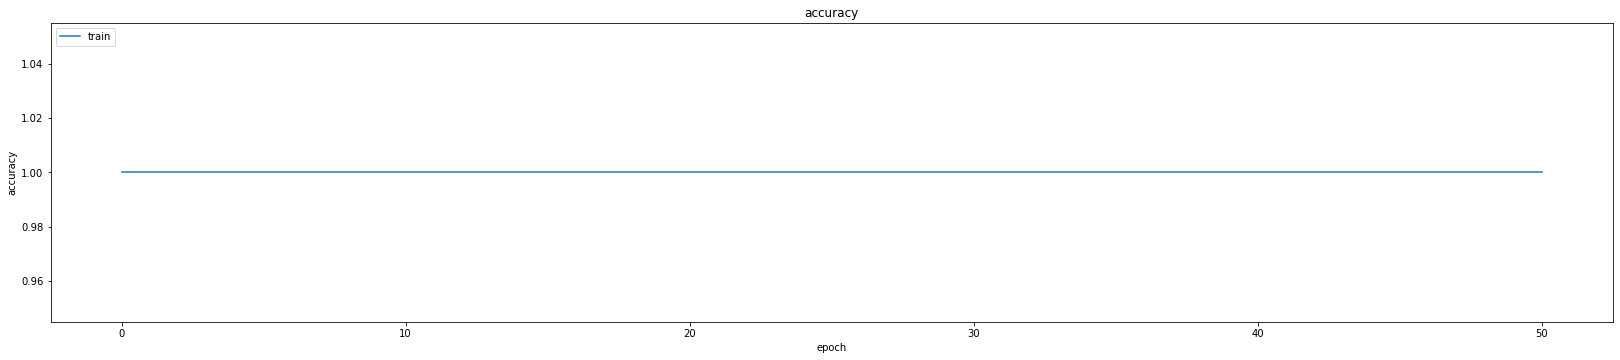

1472 1536


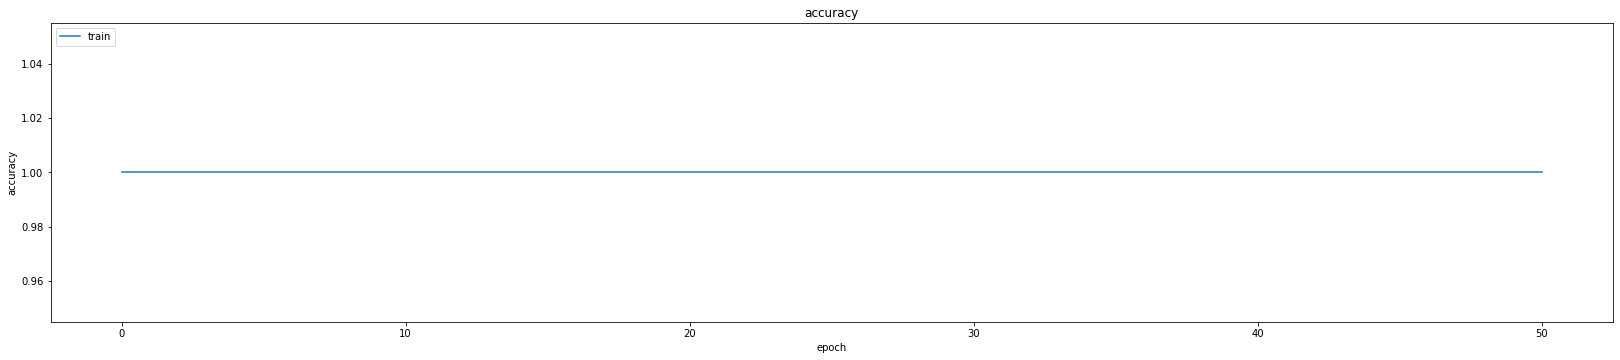

1536 1600


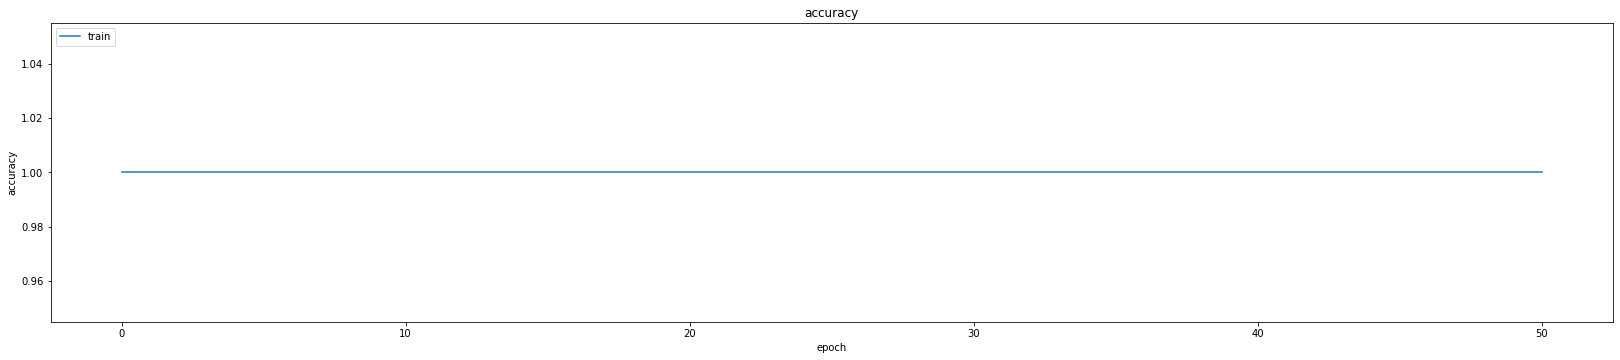

1600 1664


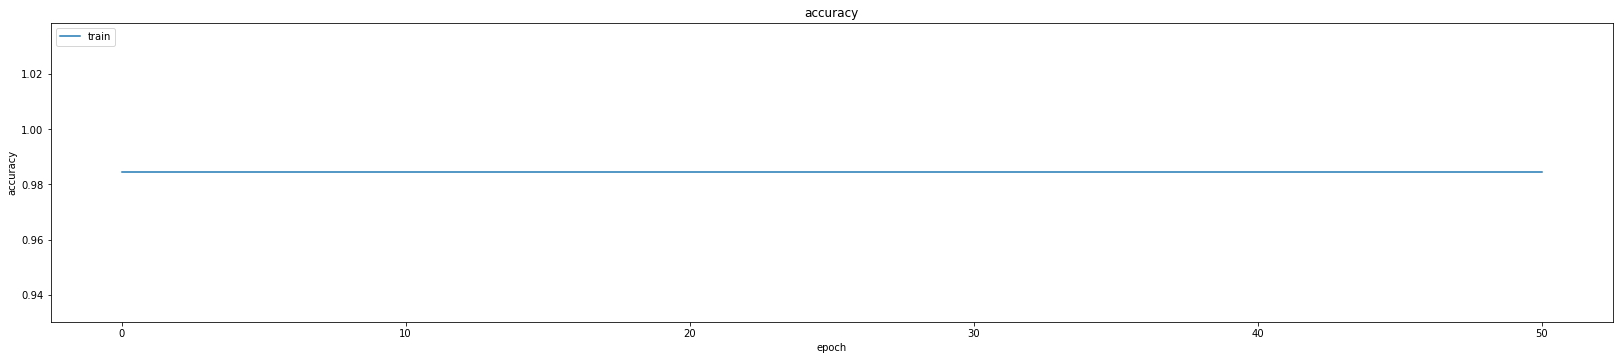

1664 1728


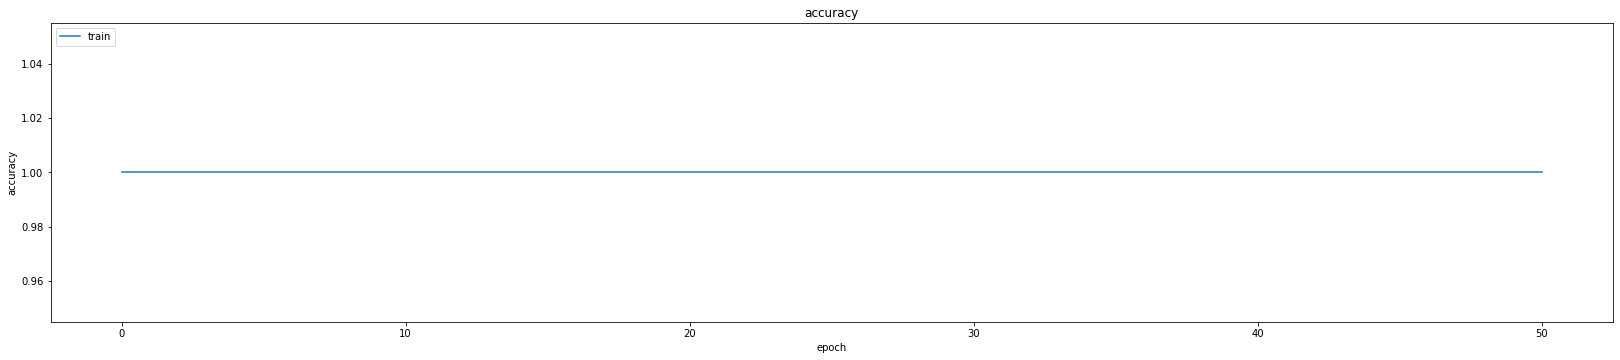

1728 1792


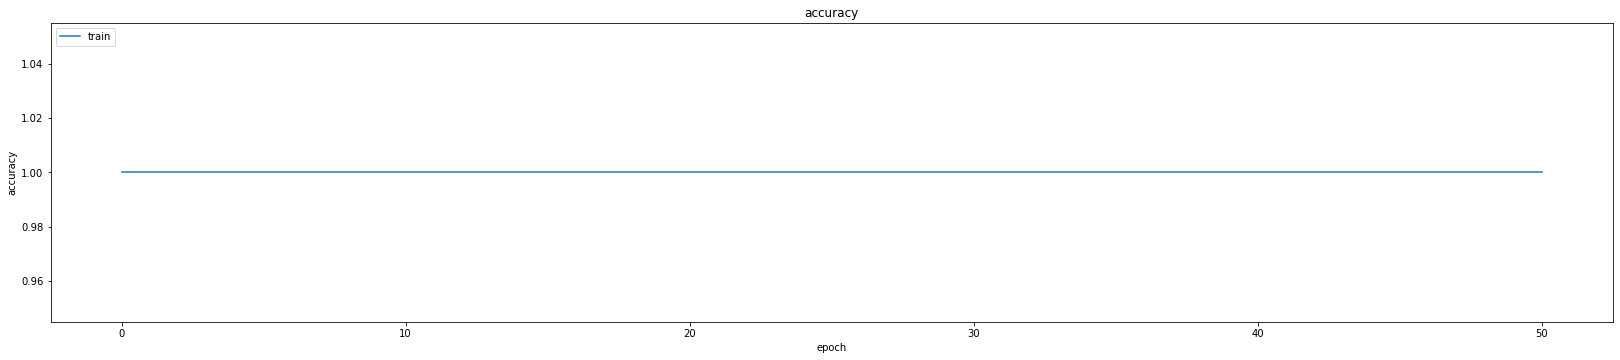

1792 1856


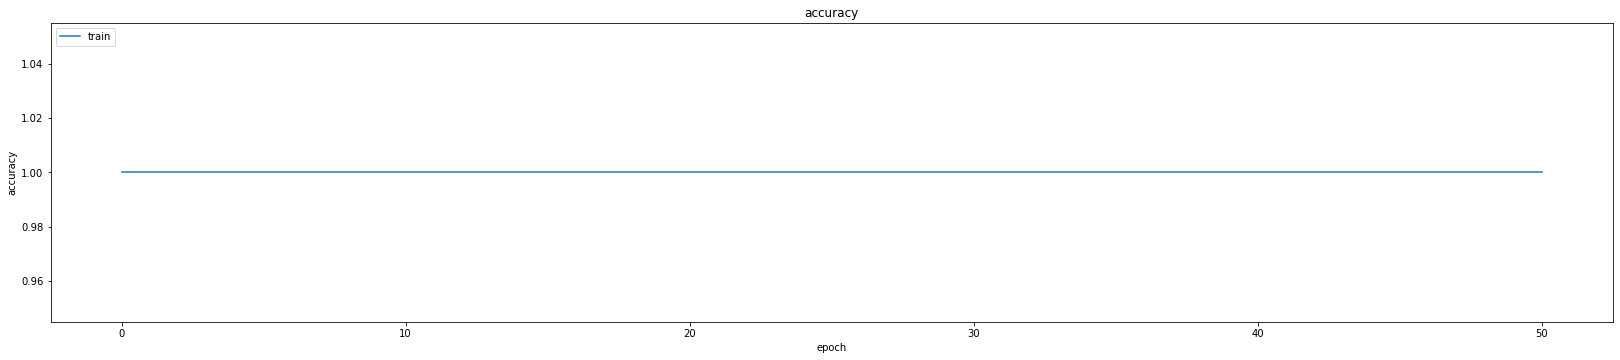

1856 1920


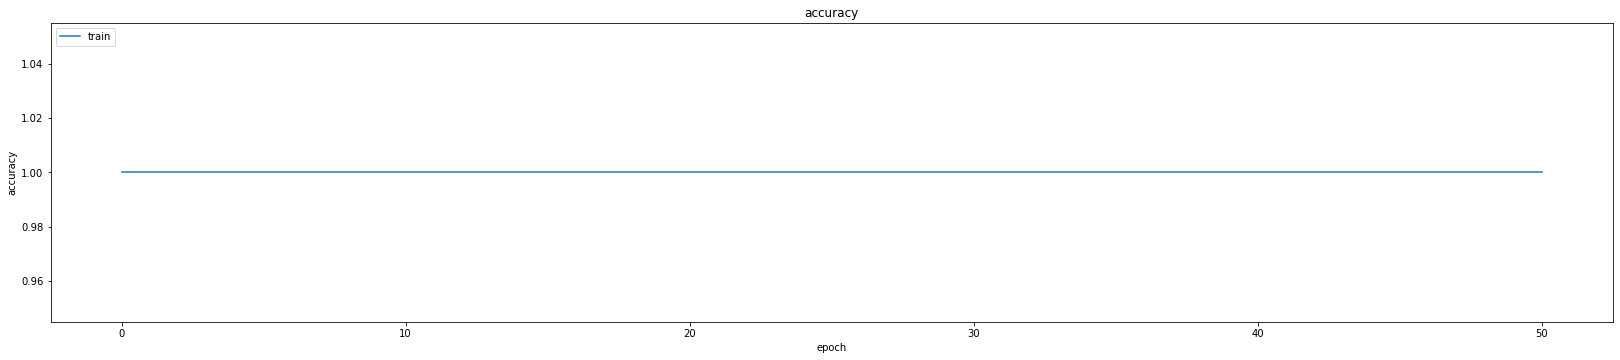

1920 1984


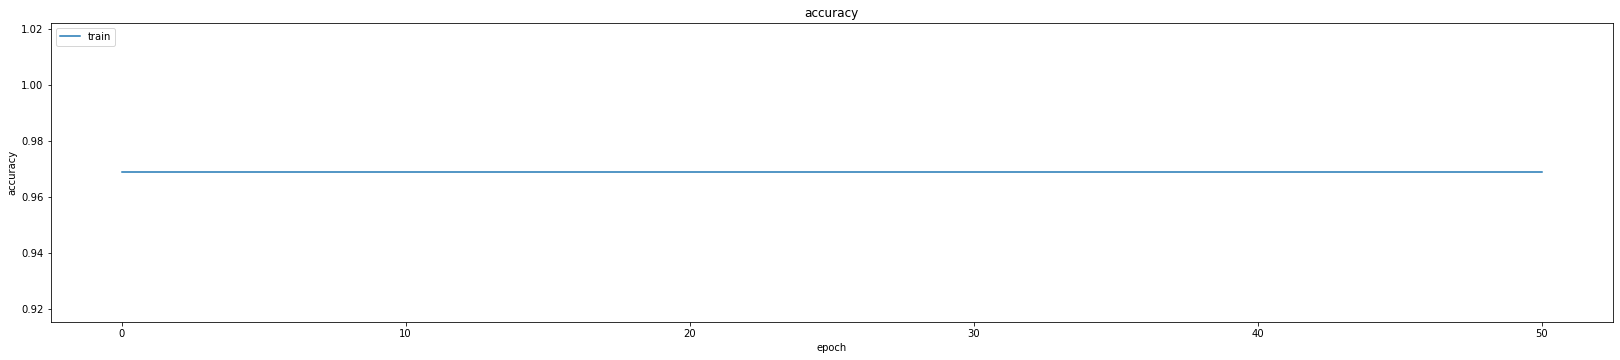

1984 2048


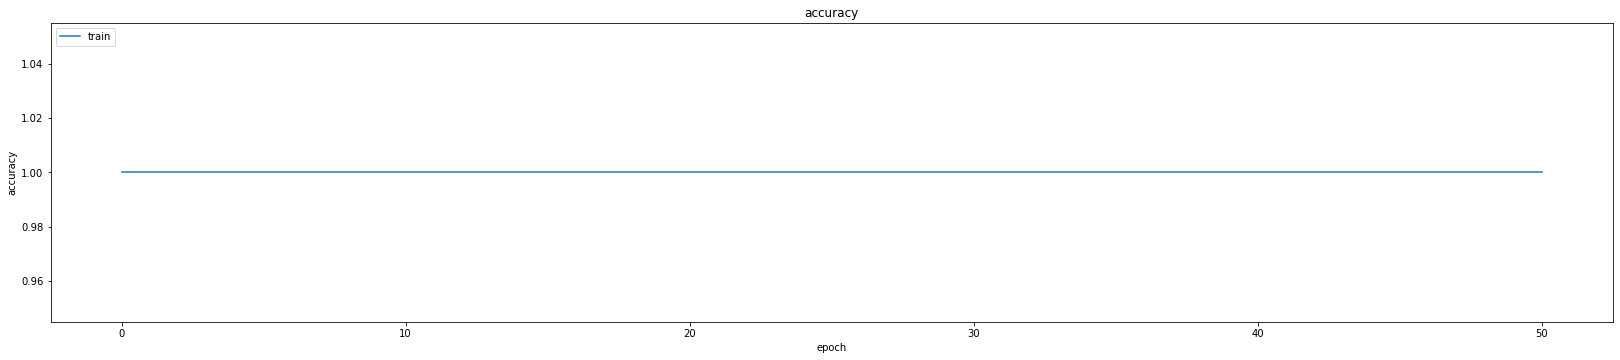

2048 2112


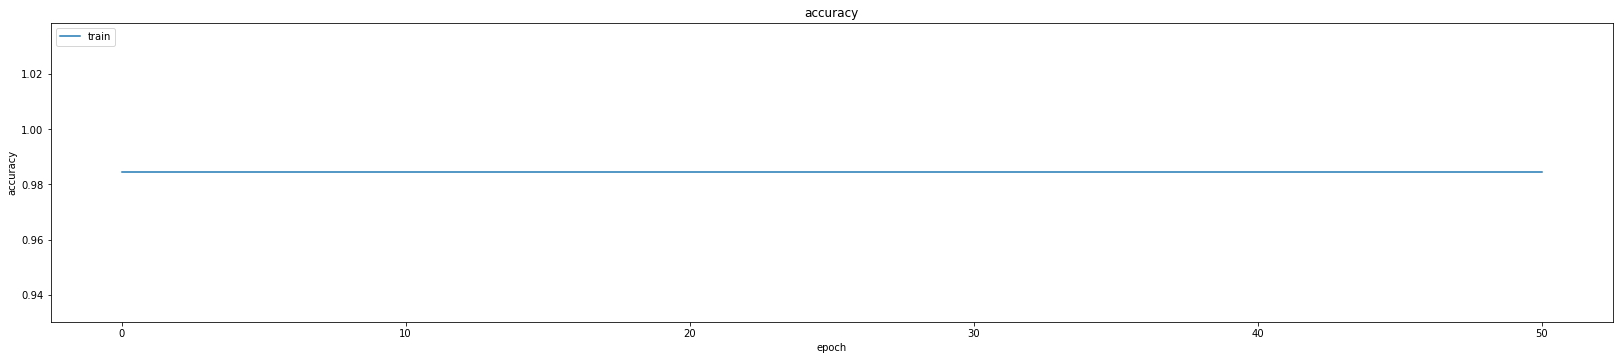

2112 2176


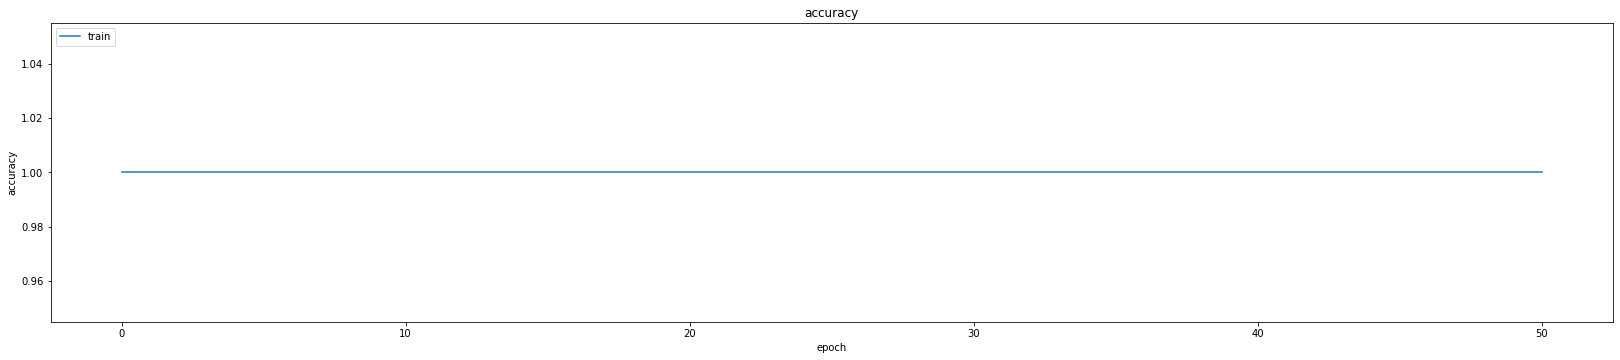

2176 2240


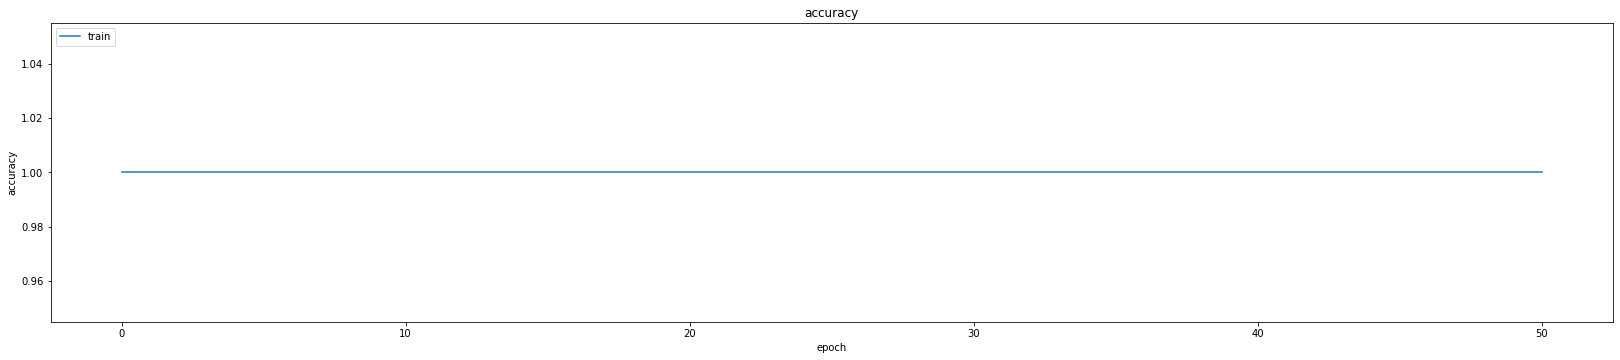

2240 2304


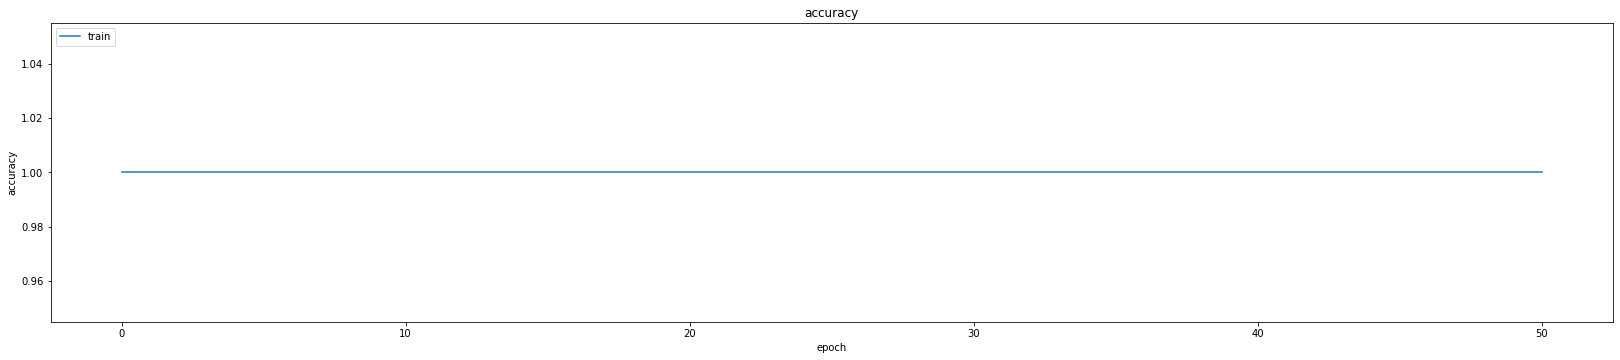

2304 2368


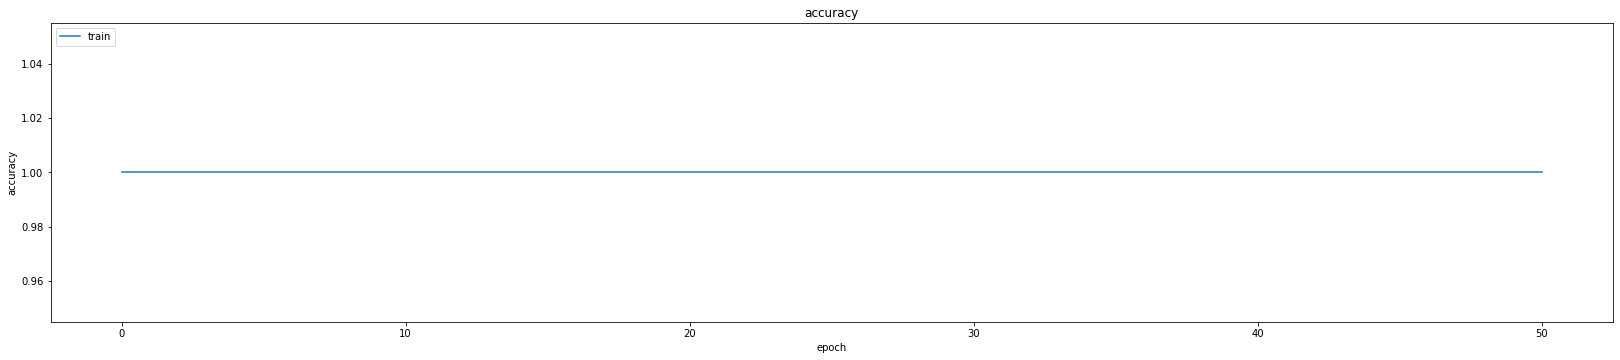

2368 2432


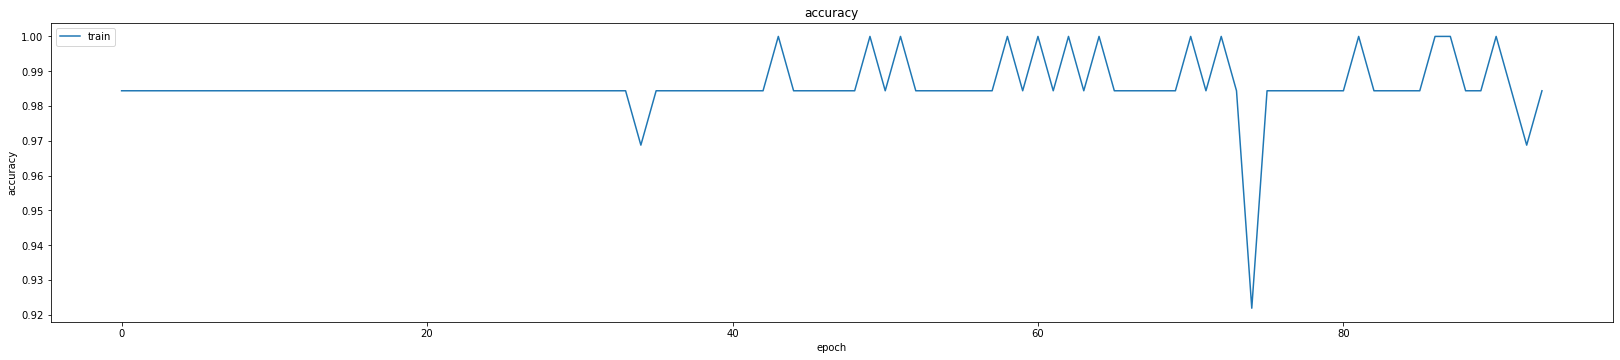

2432 2496


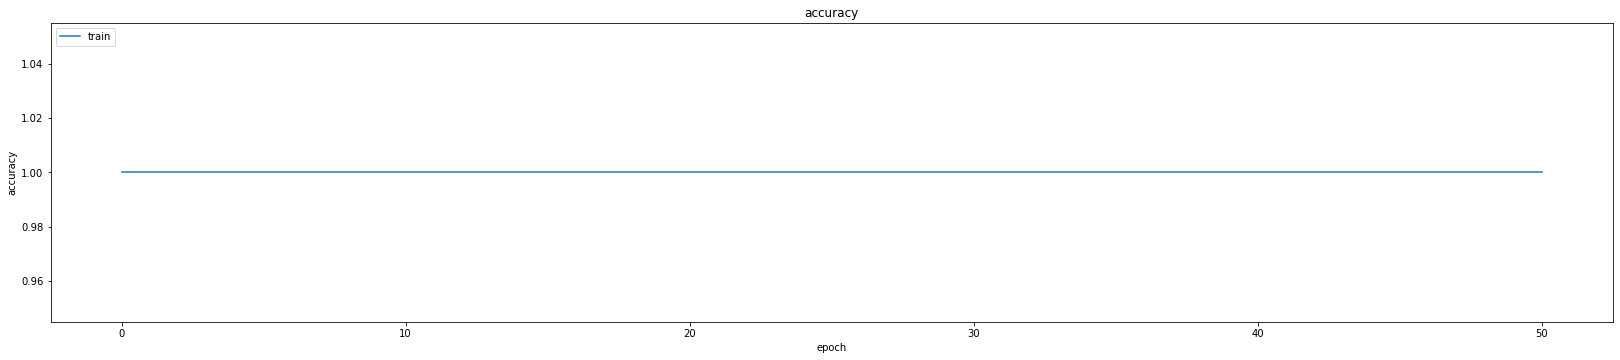

2496 2560


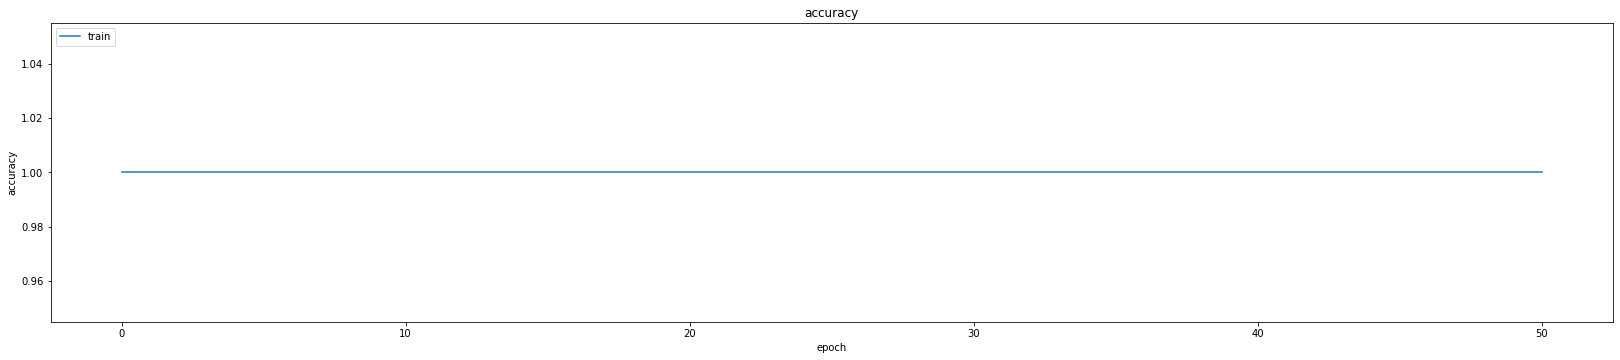

2560 2624


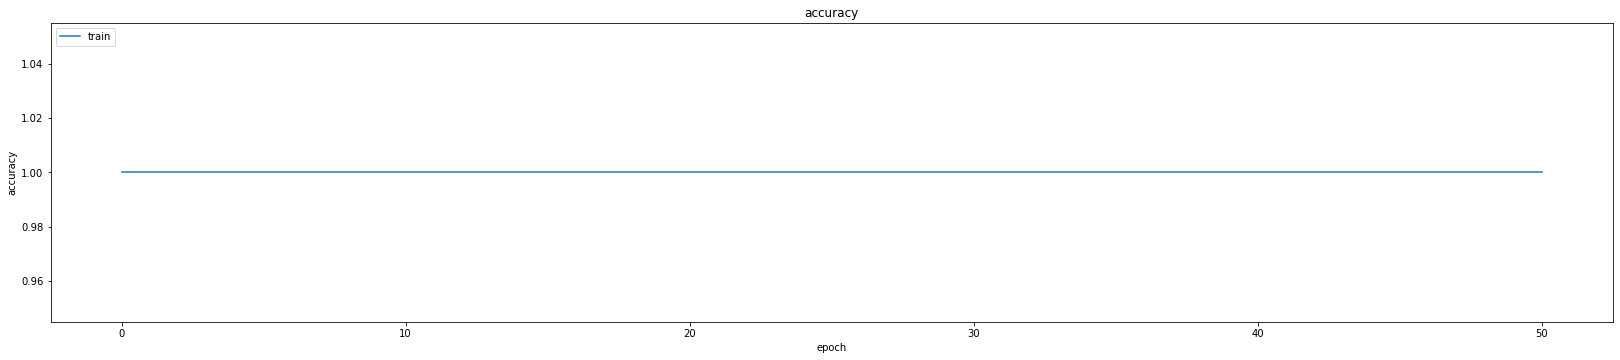

2624 2688


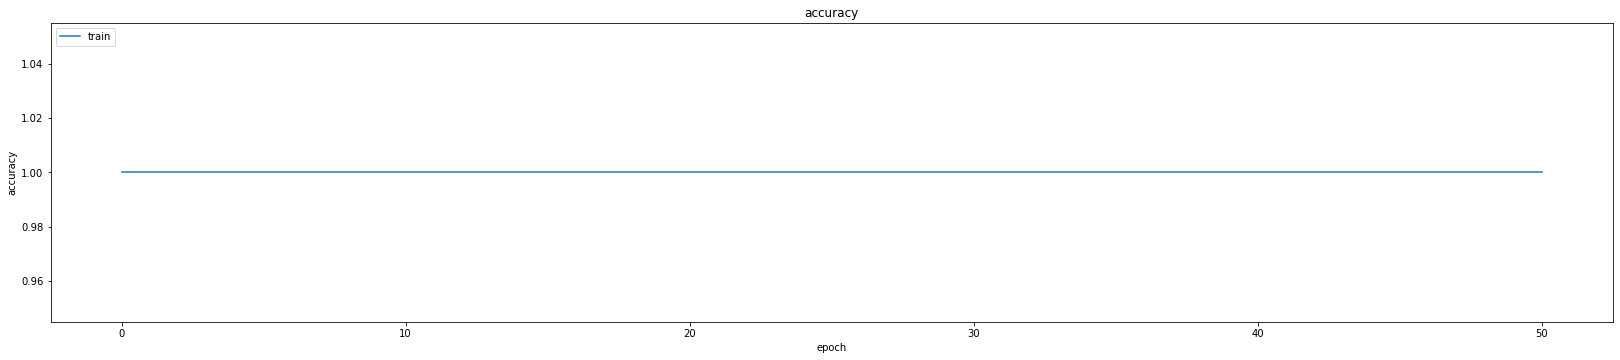

2688 2752


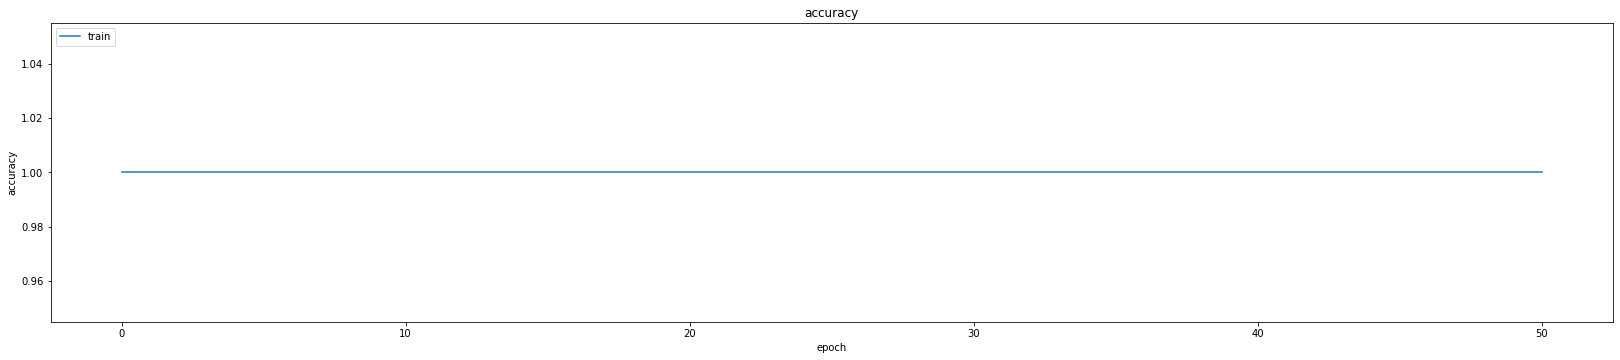

2752 2816


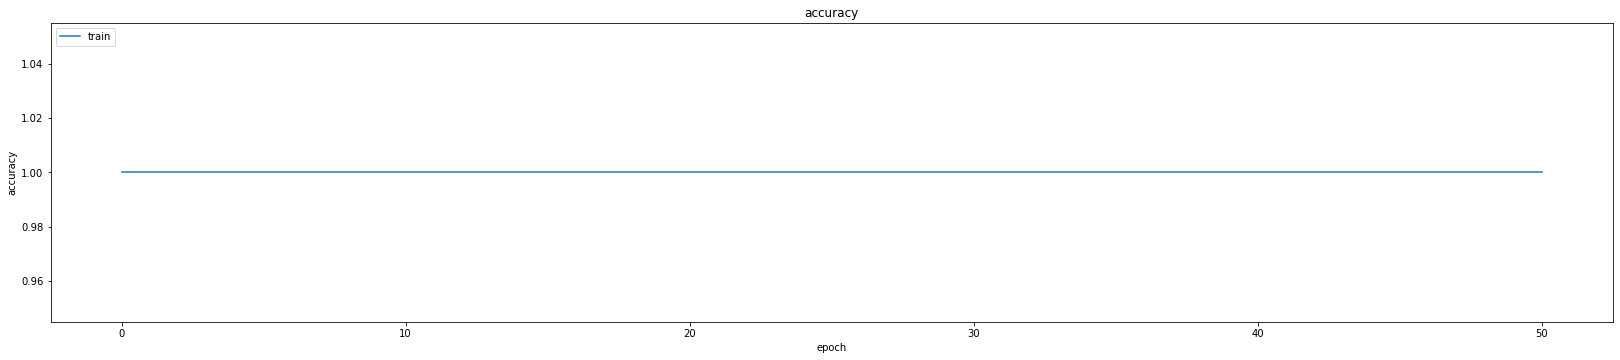

2816 2880


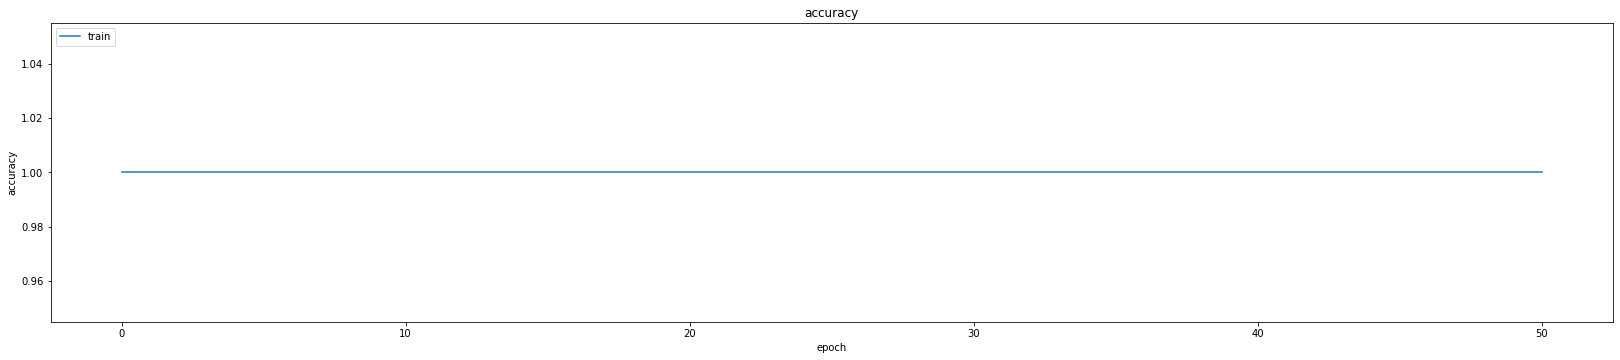

2880 2944


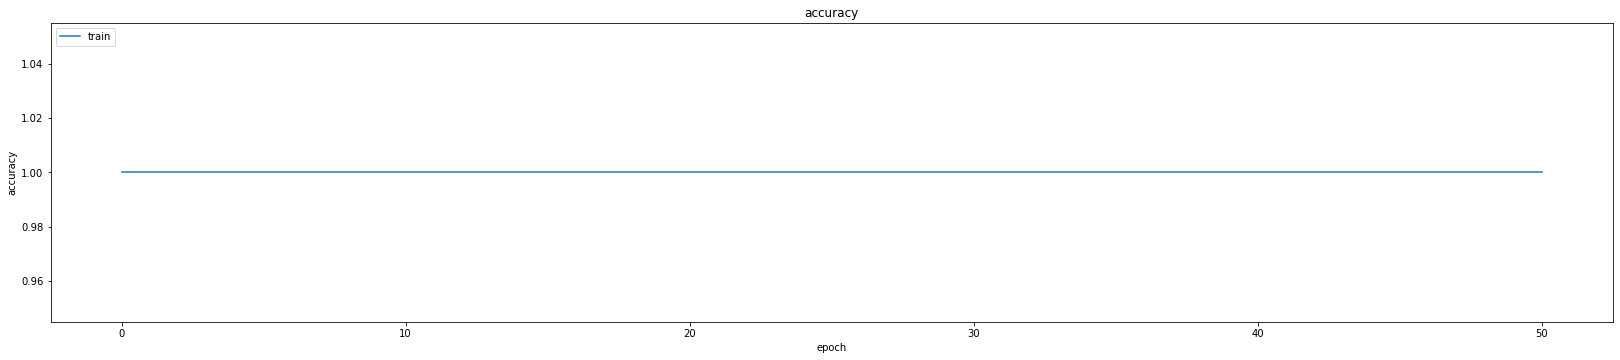

2944 3008


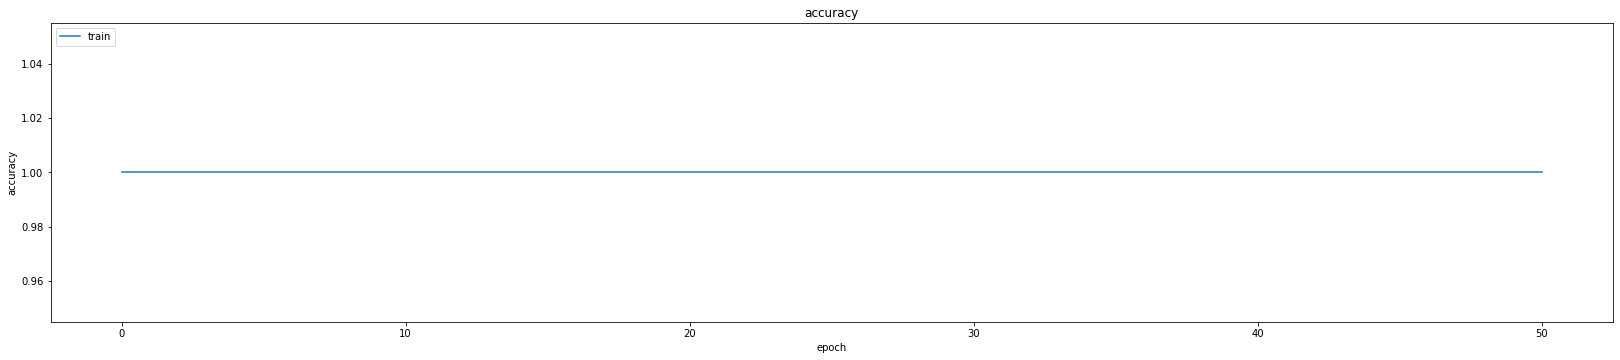

3008 3072


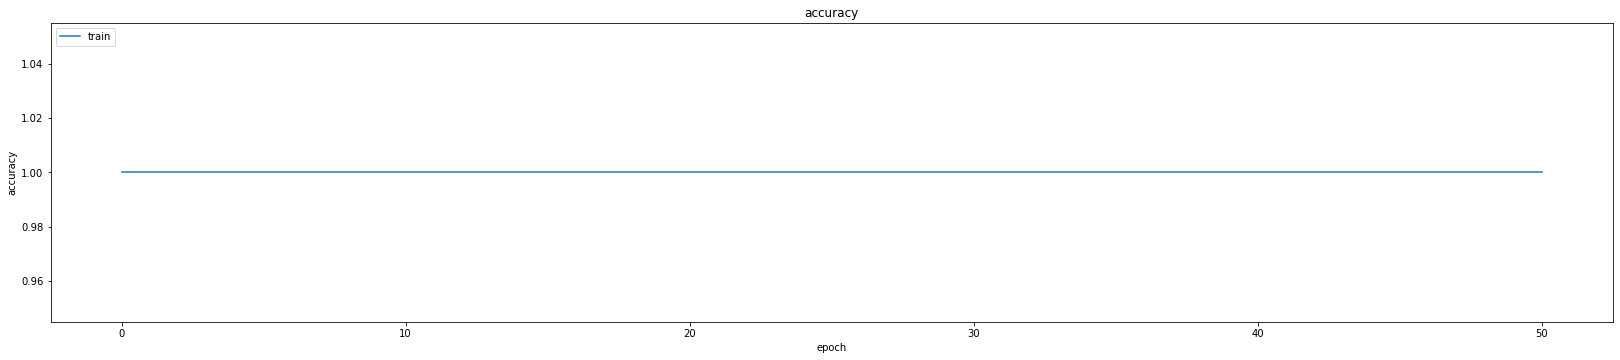

3072 3136


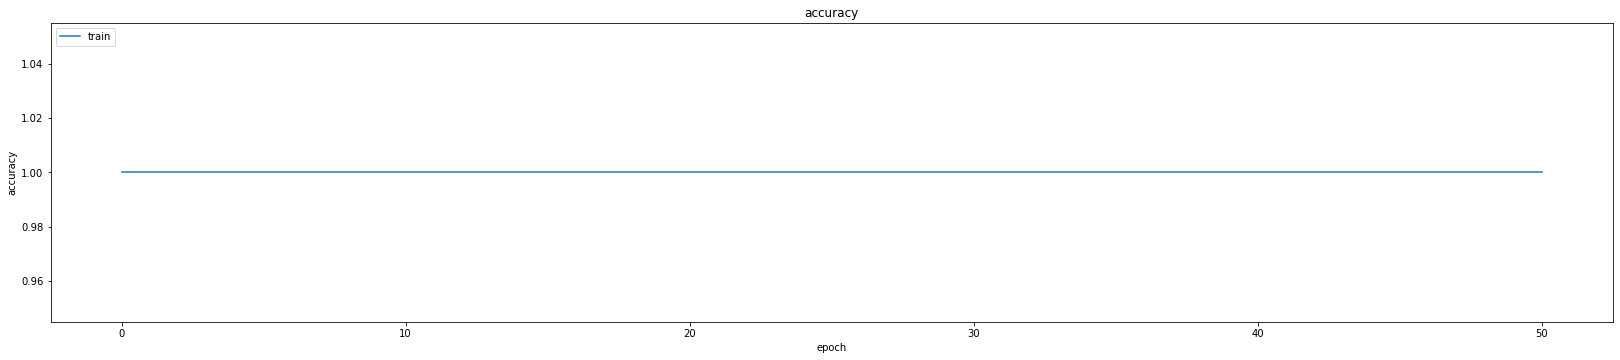

3136 3200


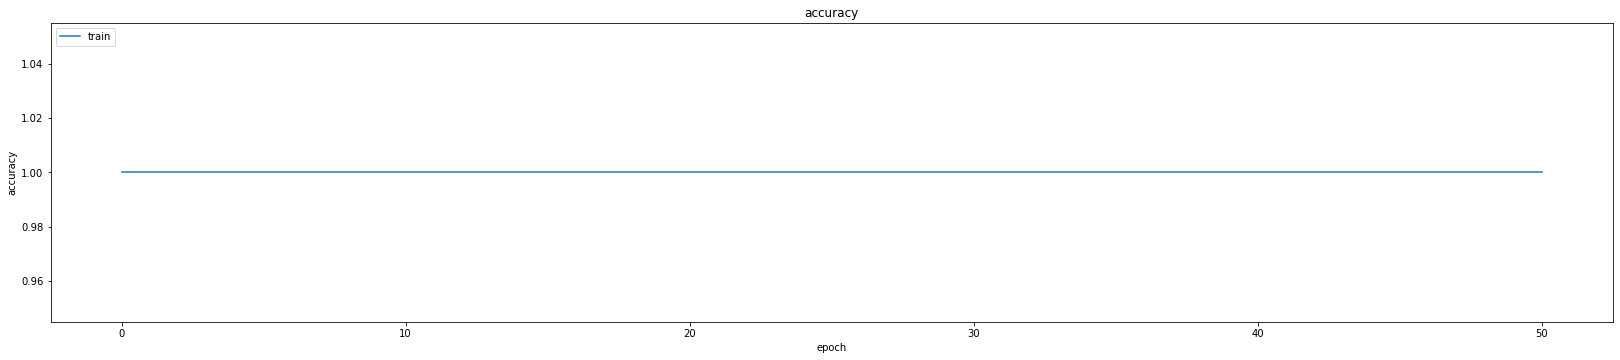

3200 3264


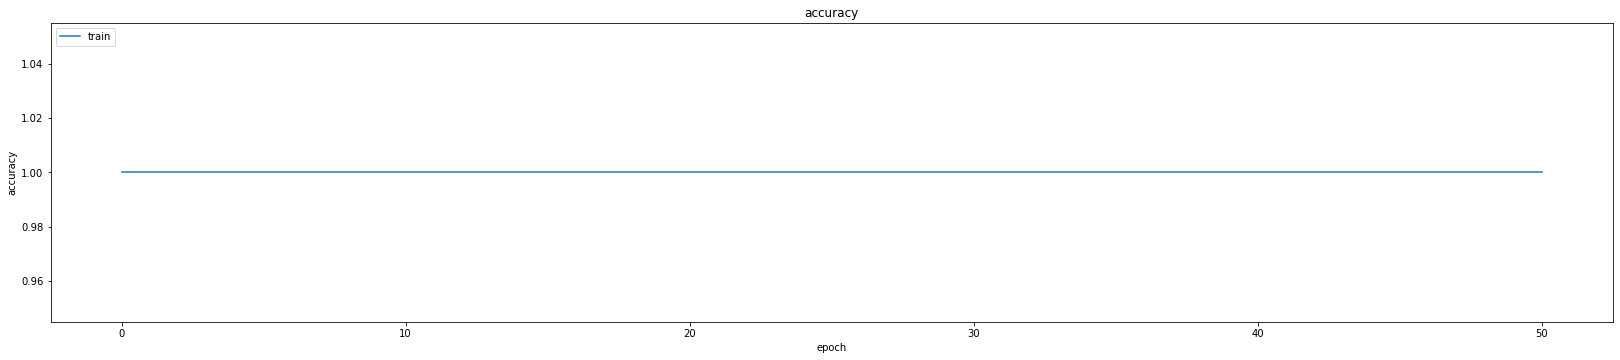

3264 3328


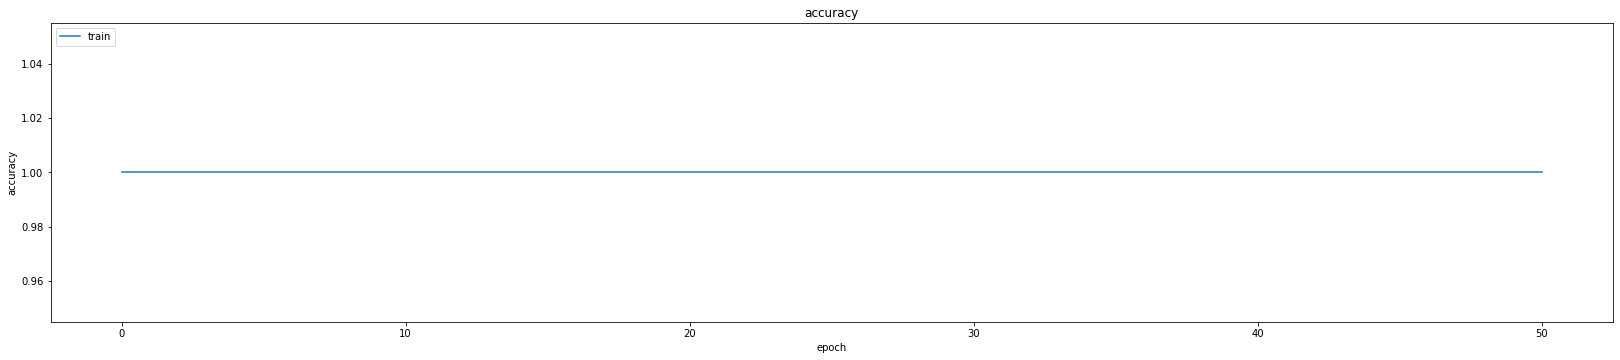

3328 3392


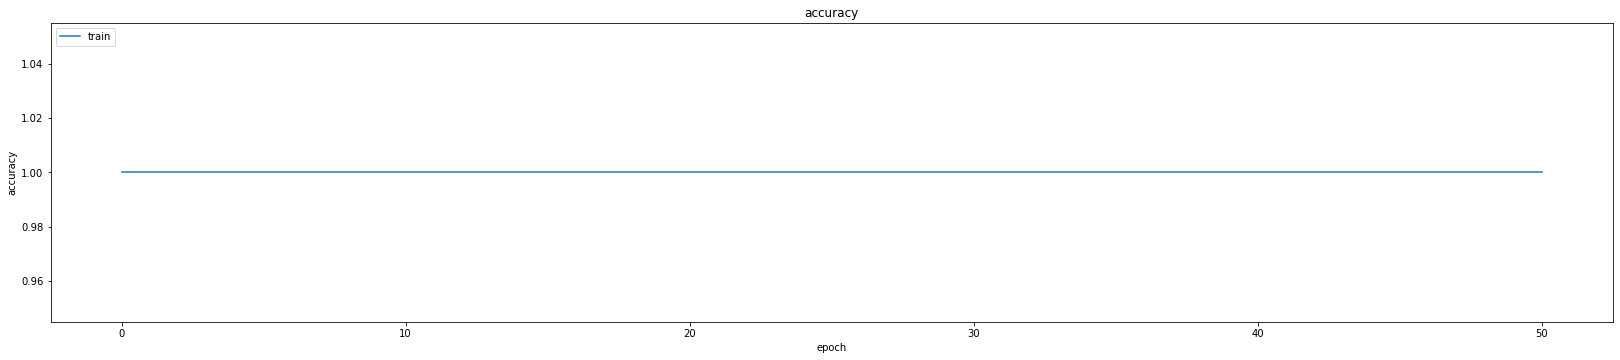

3392 3456


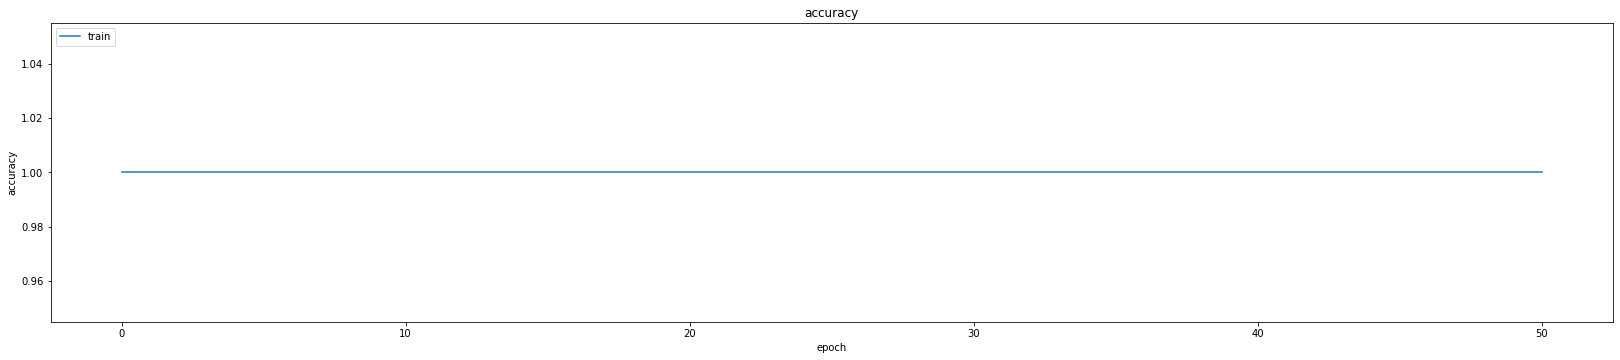

3456 3520


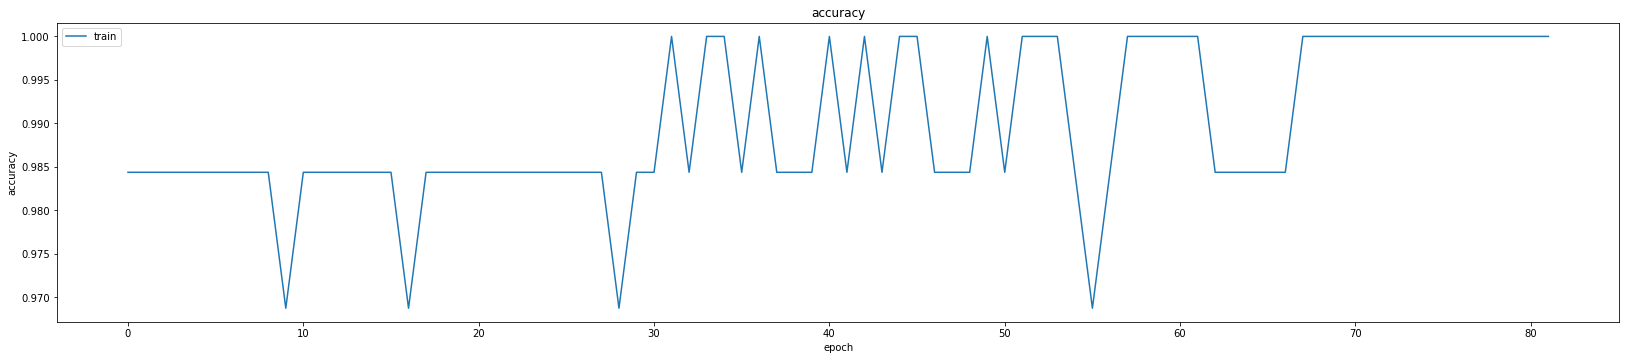

3520 3584


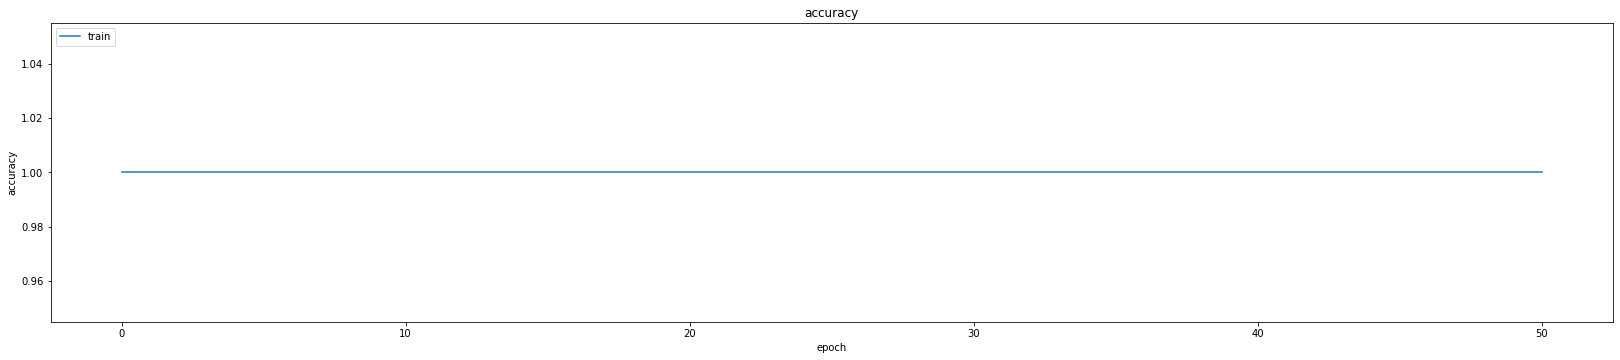

3584 3648


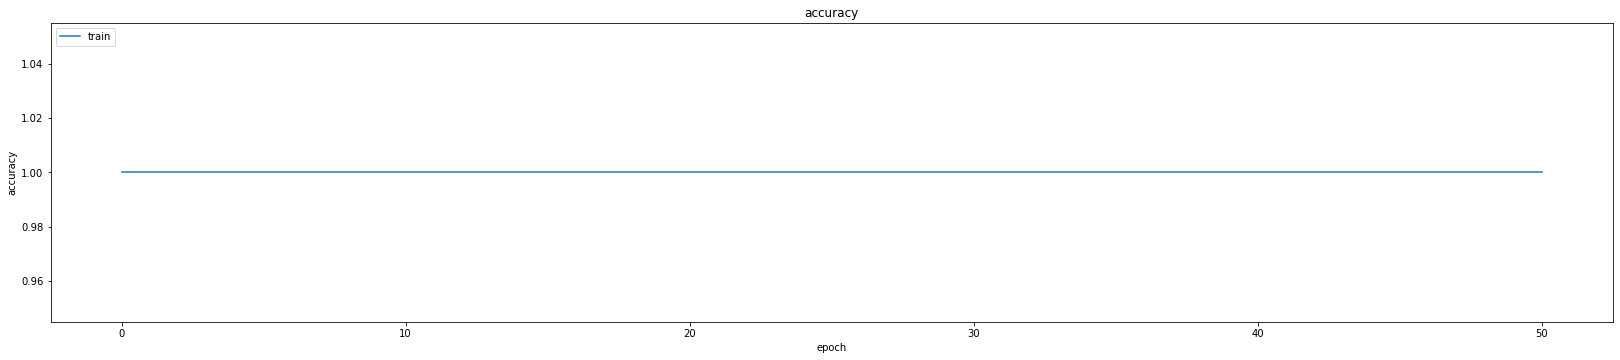

3648 3712


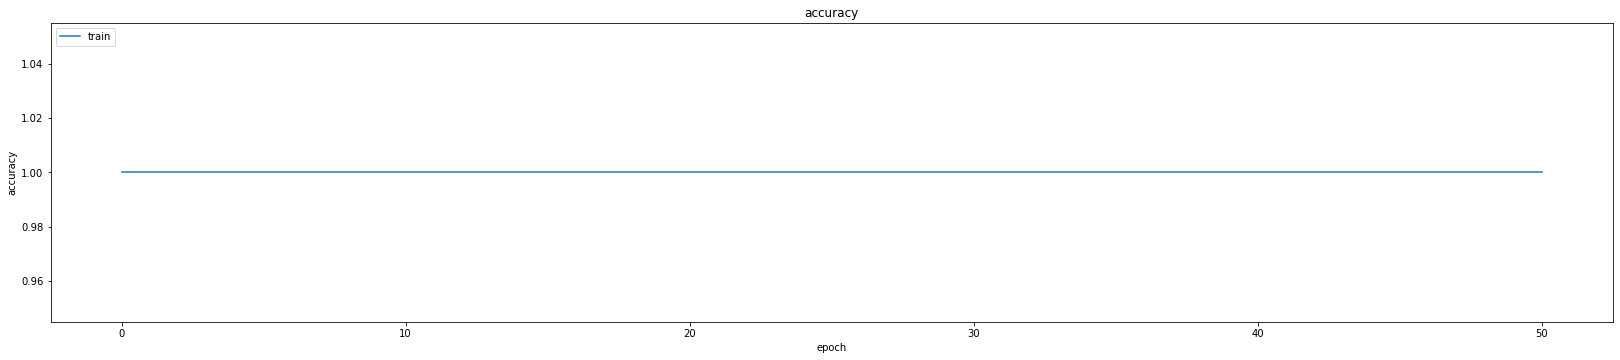

3712 3776


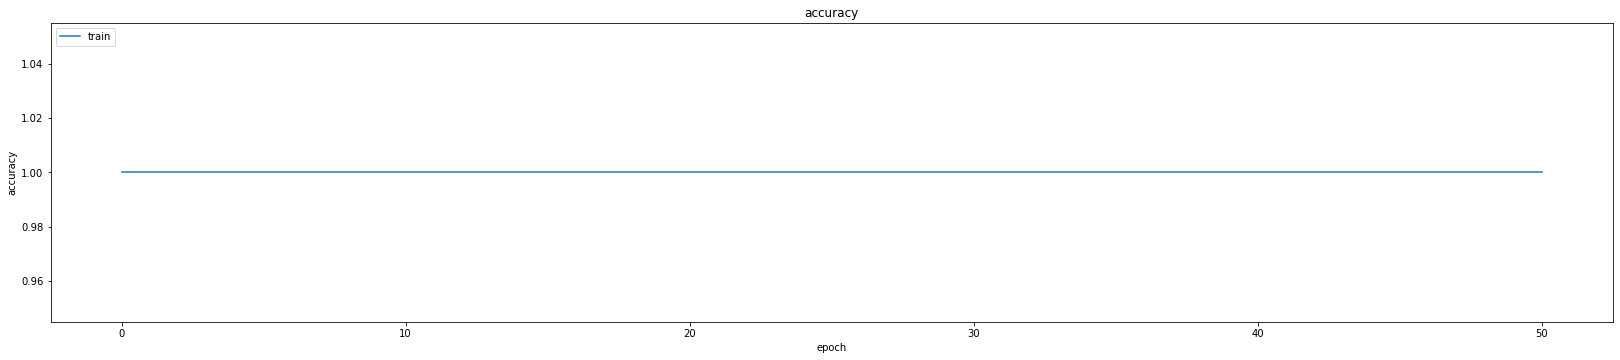

3776 3840


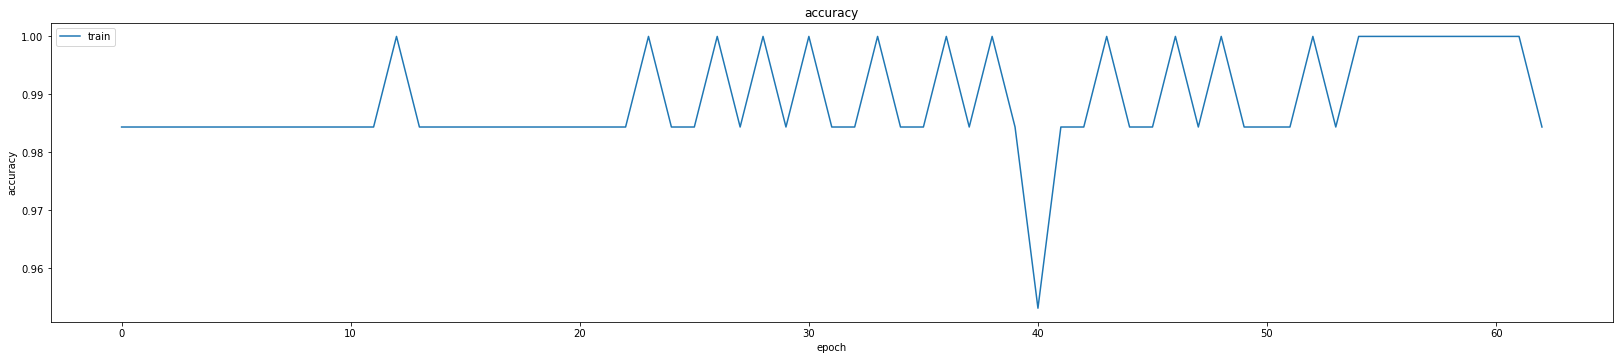

3840 3904


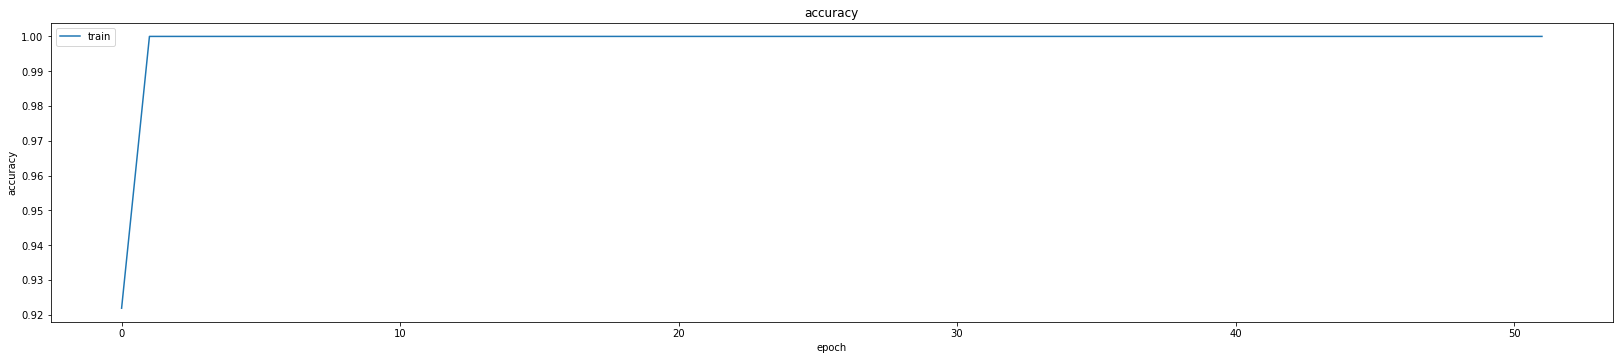

3904 3968


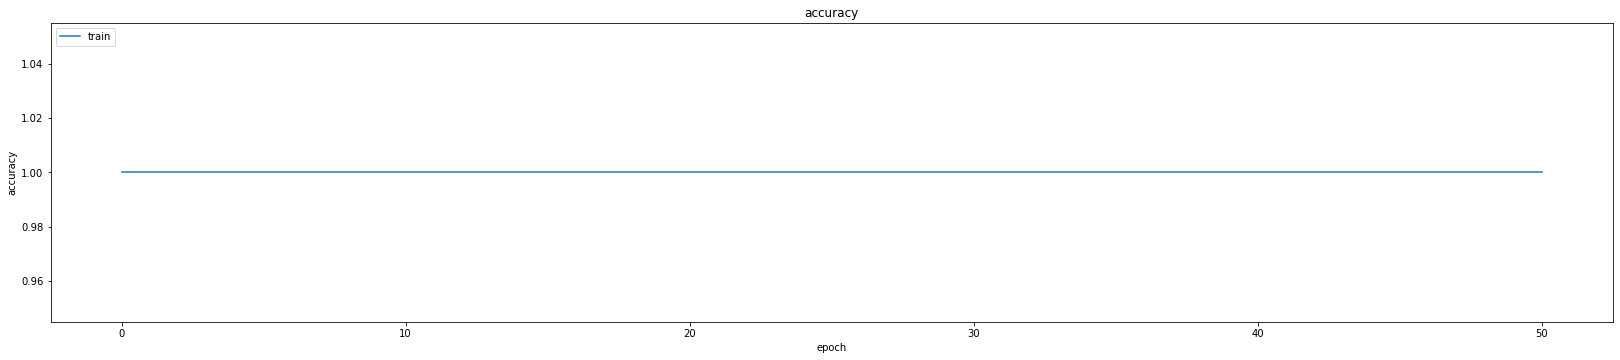

3968 4032


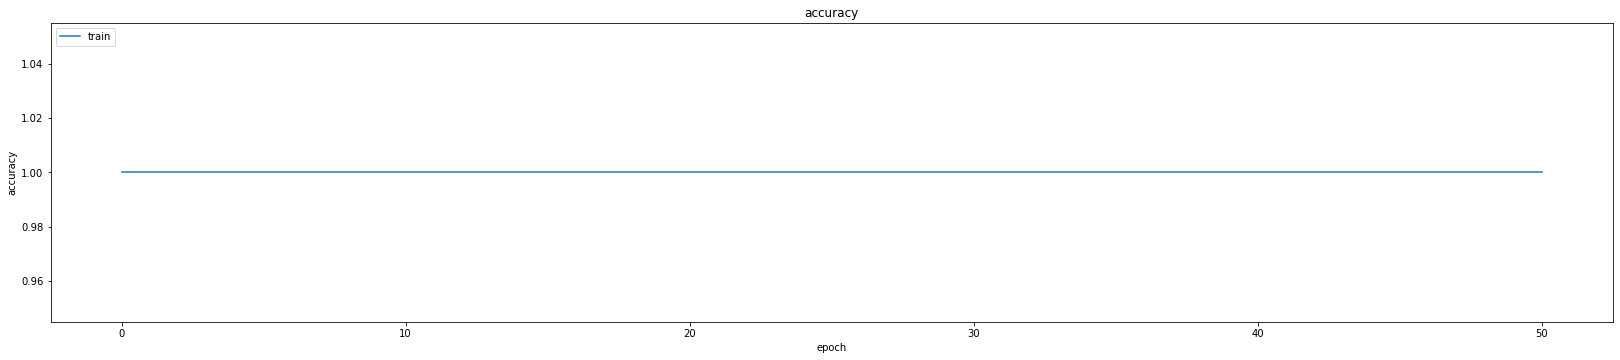

4032 4096


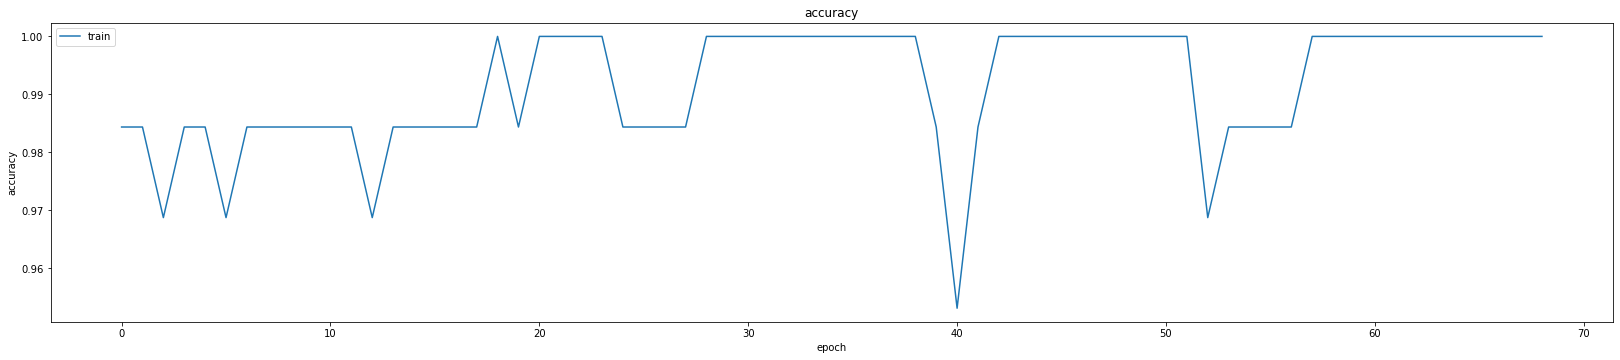

4096 4160


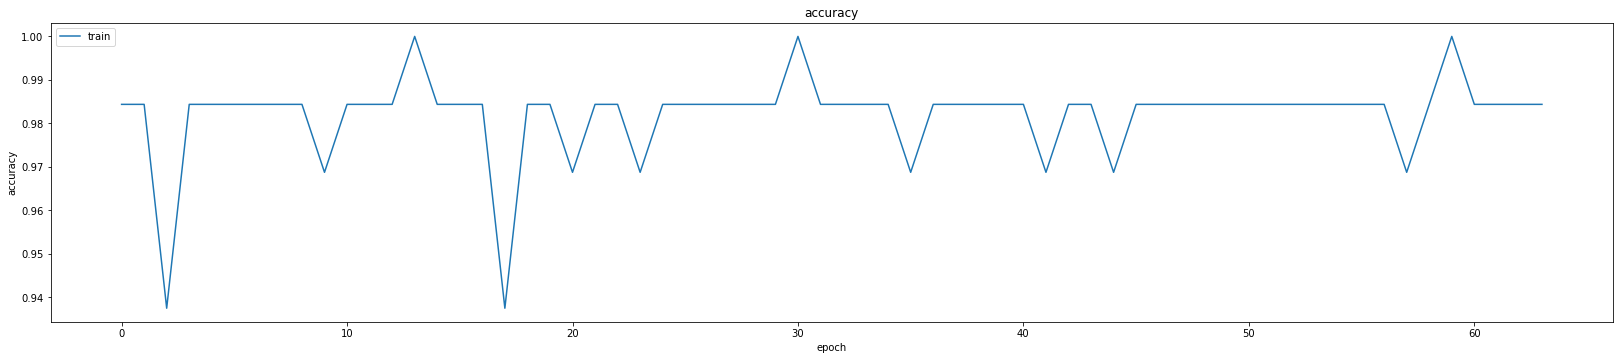

4160 4224


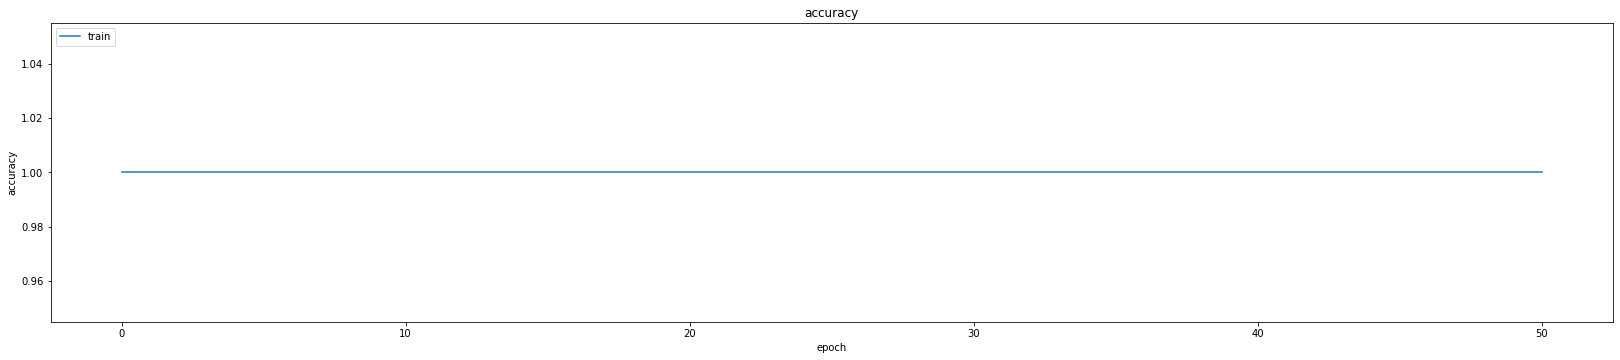

4224 4288


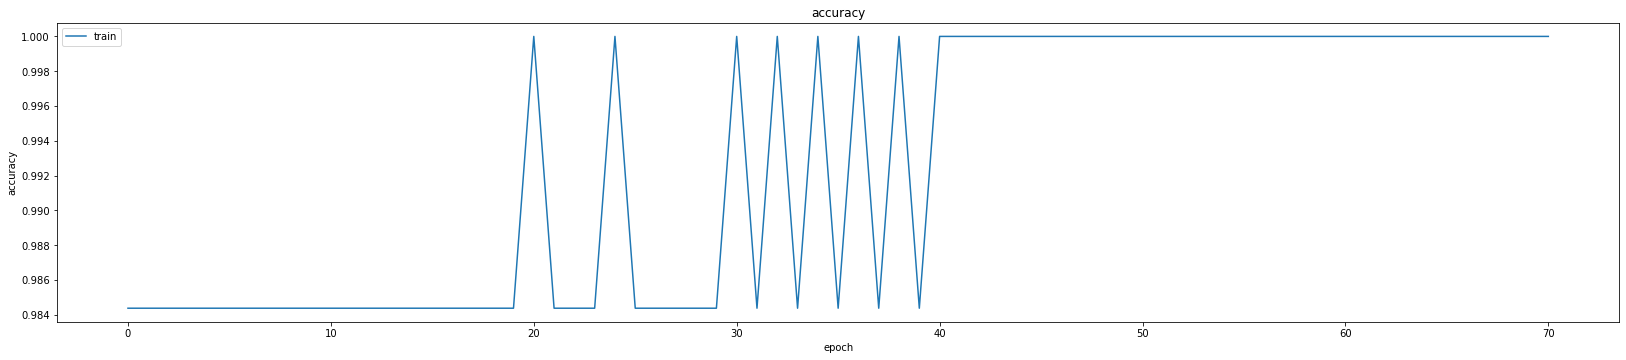

4288 4352


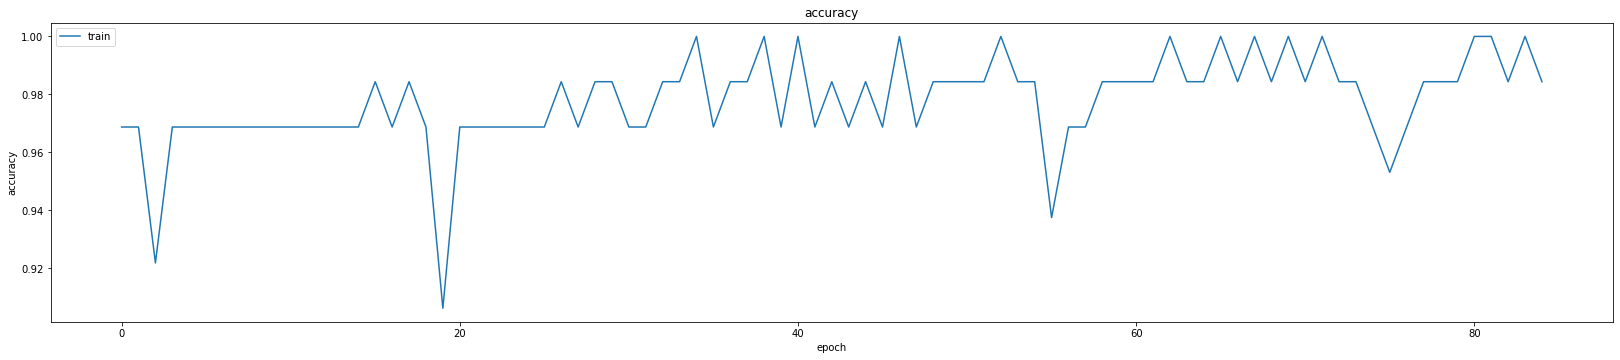

4352 4416


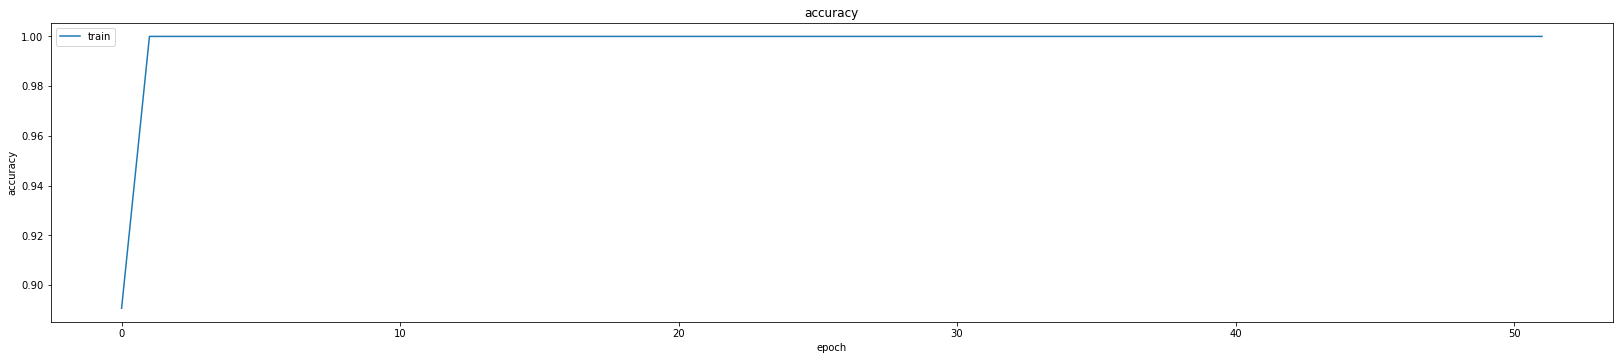

4416 4480


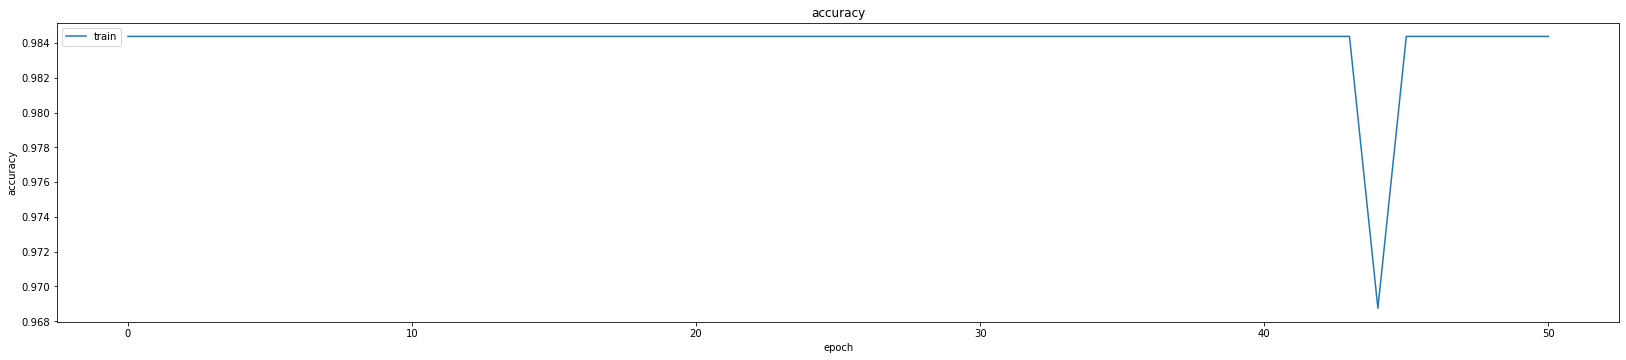

4480 4544


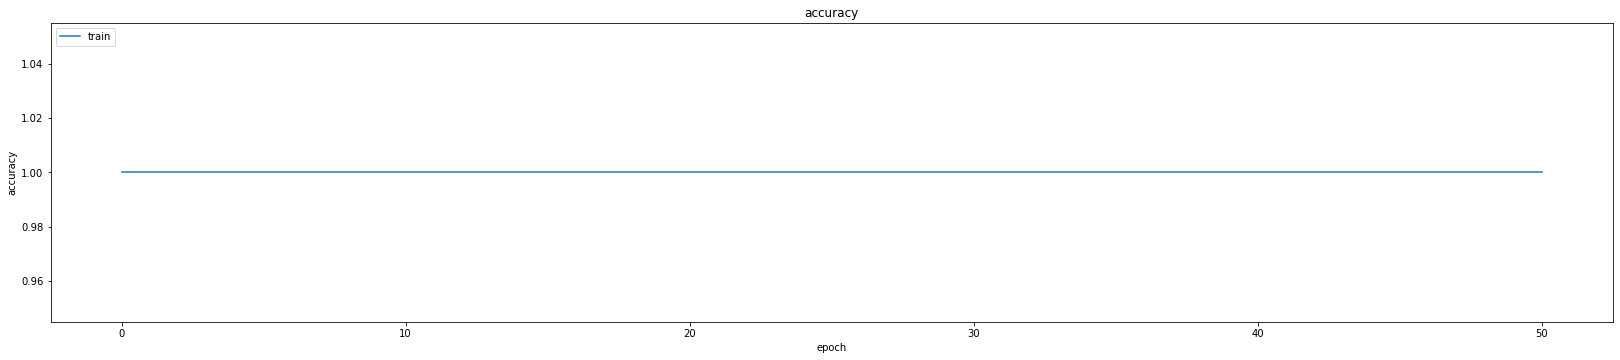

4544 4608


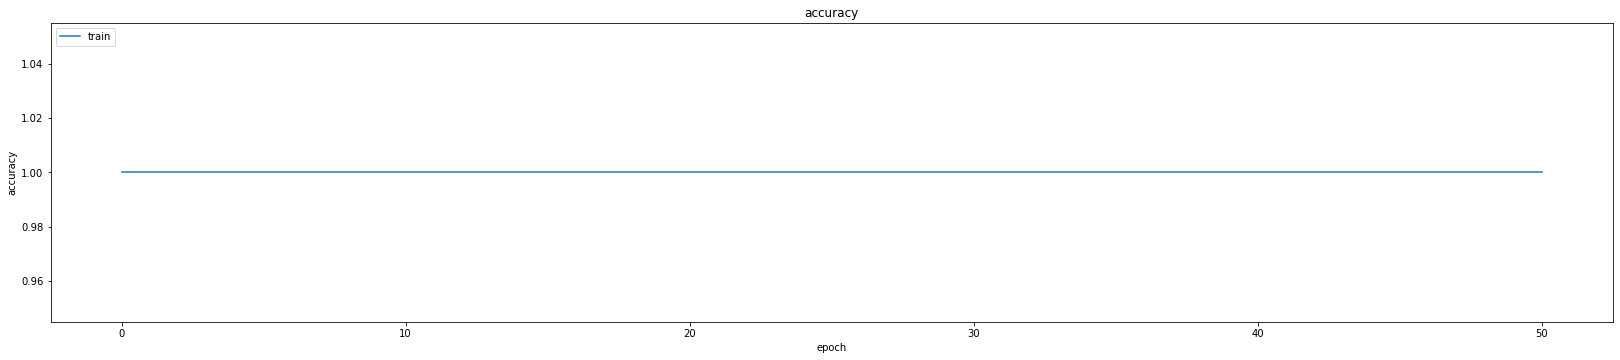

4608 4672


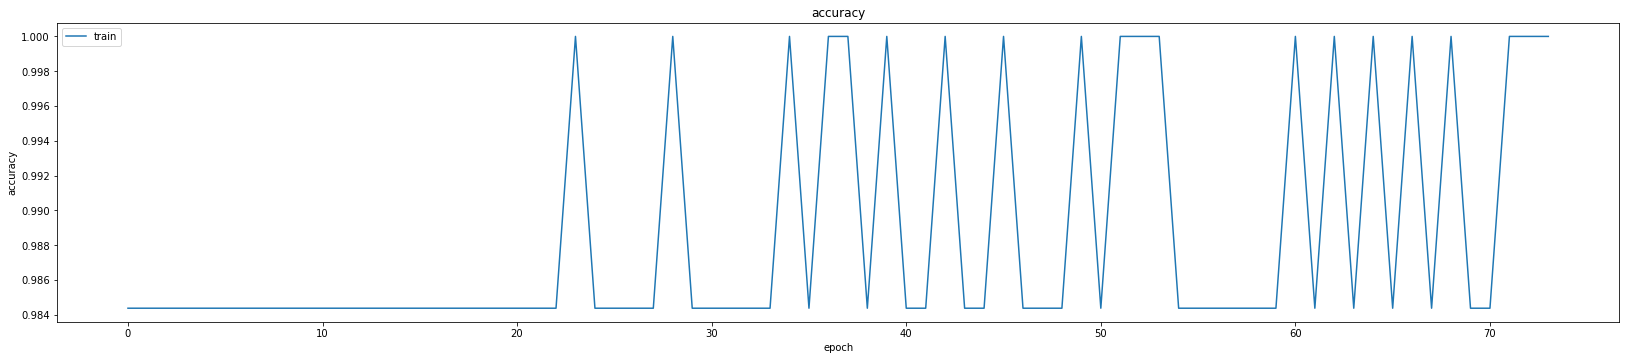

4672 4736


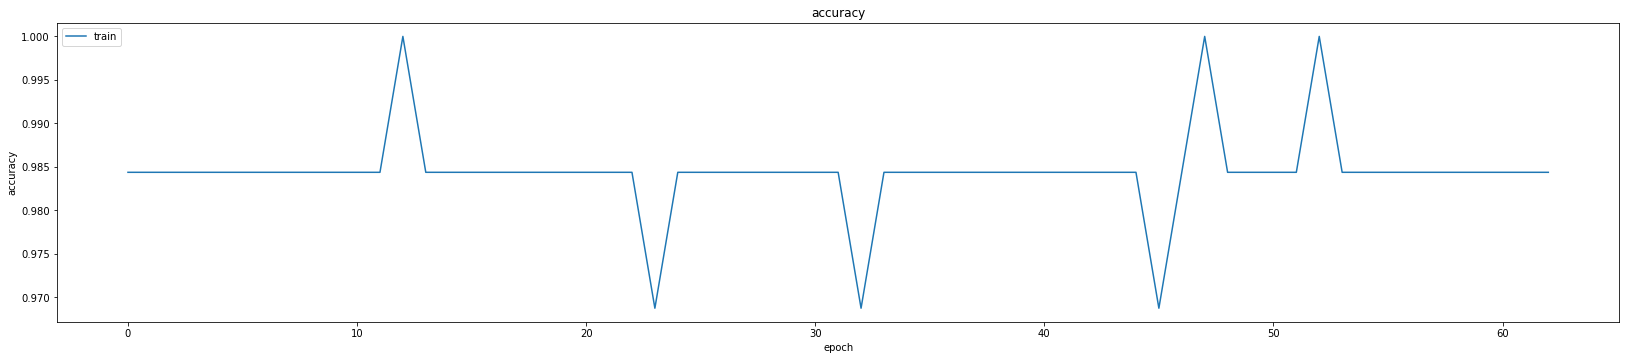

4736 4800


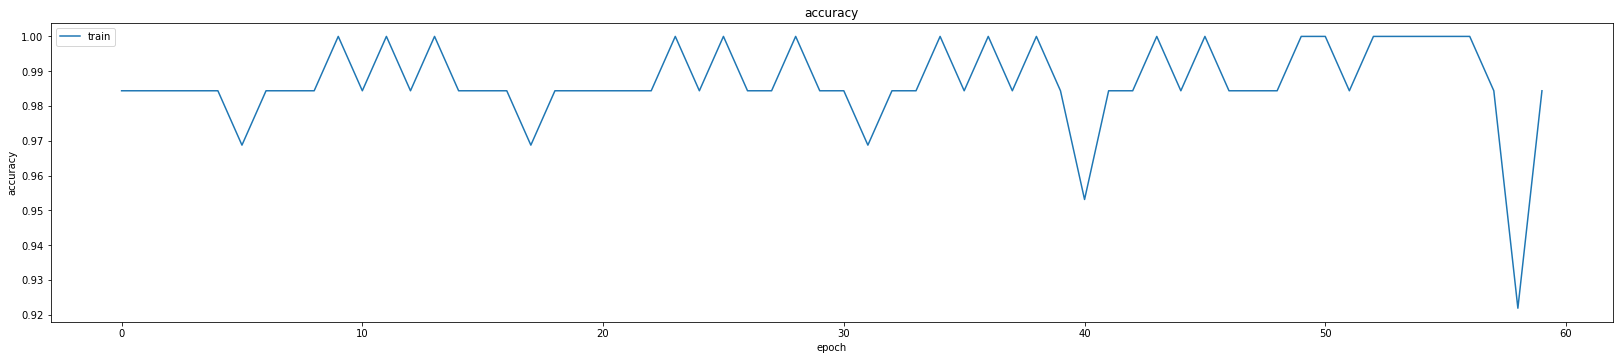

4800 4864


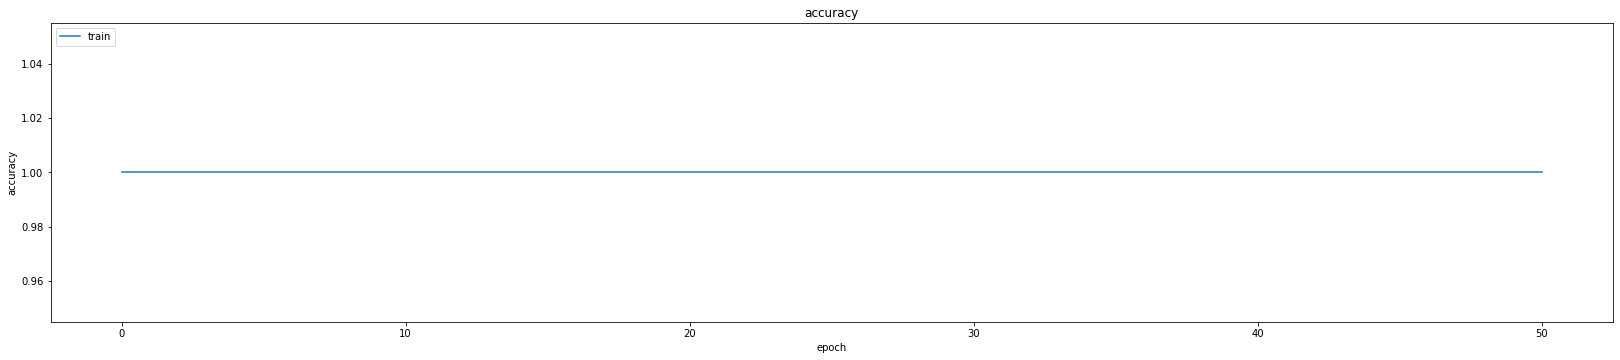

4864 4928


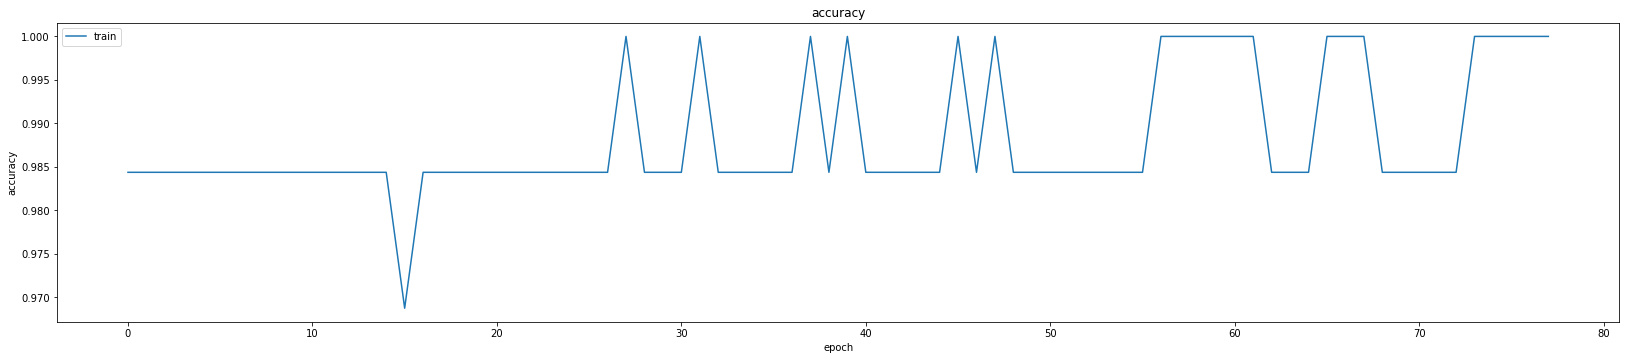

4928 4992


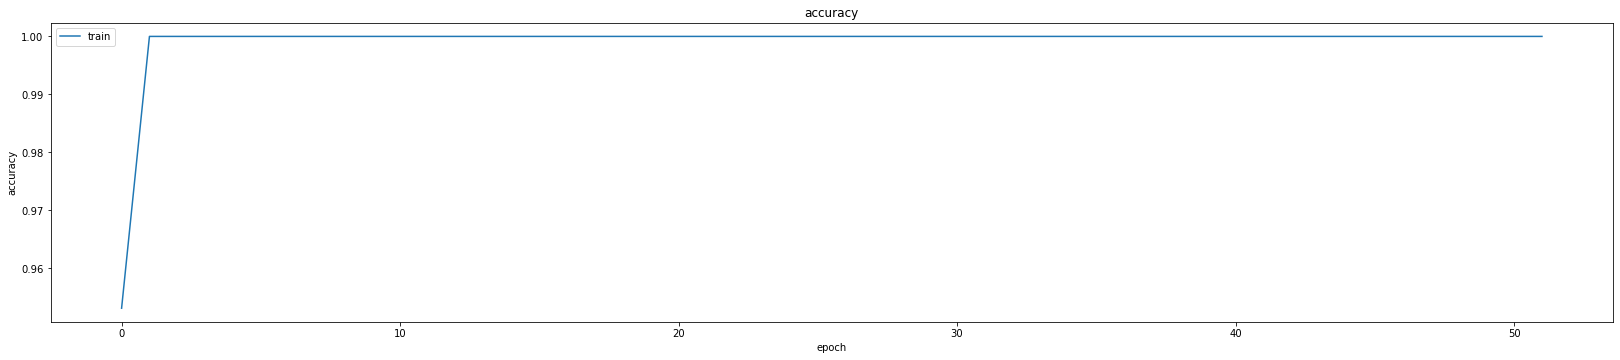

4992 5056


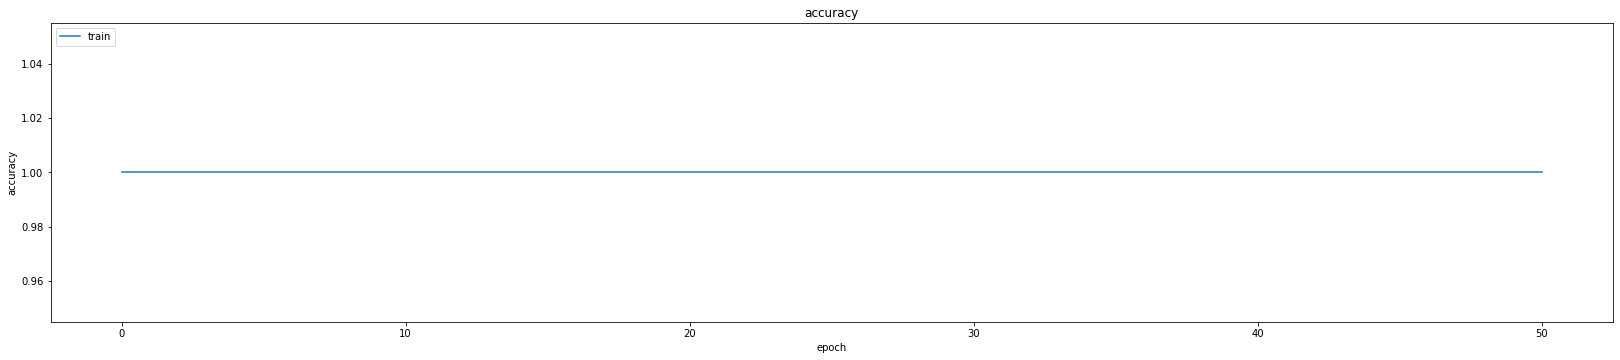

5056 5120


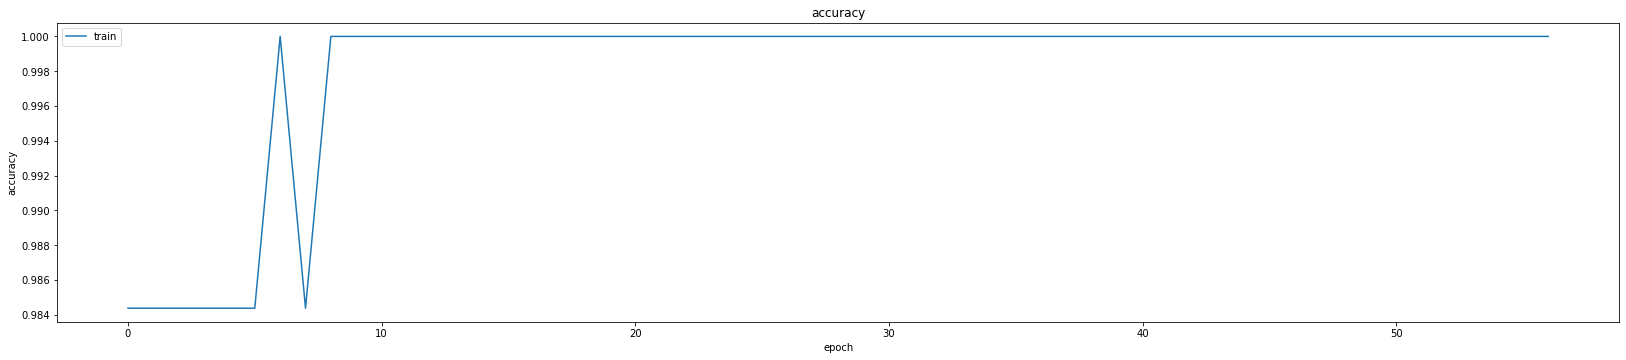

5120 5184


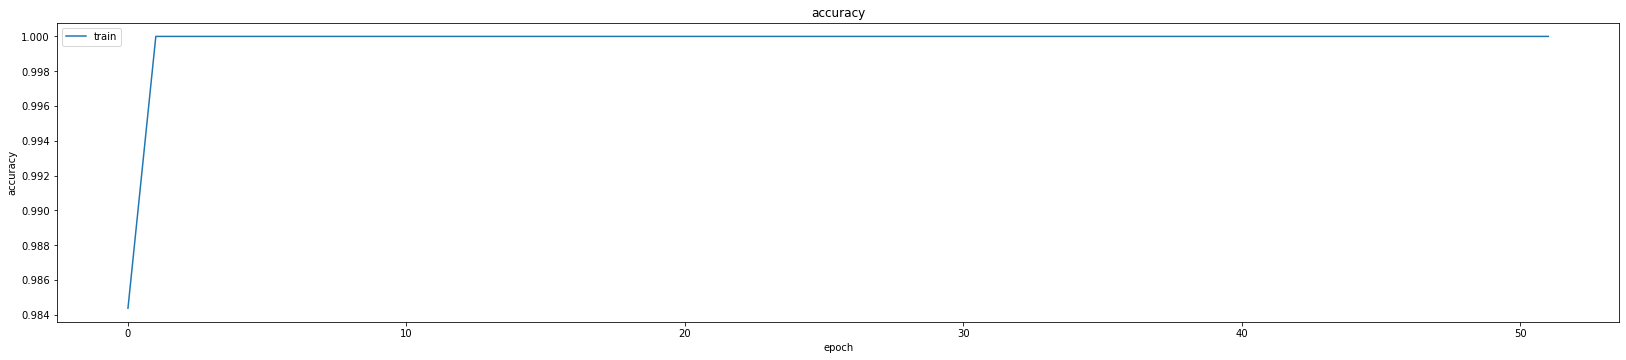

5184 5248


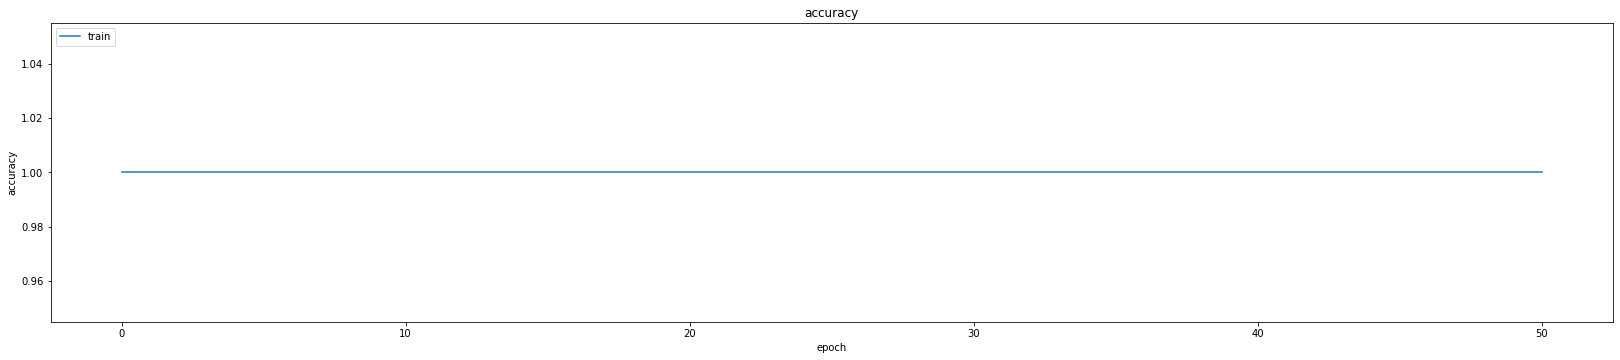

5248 5312


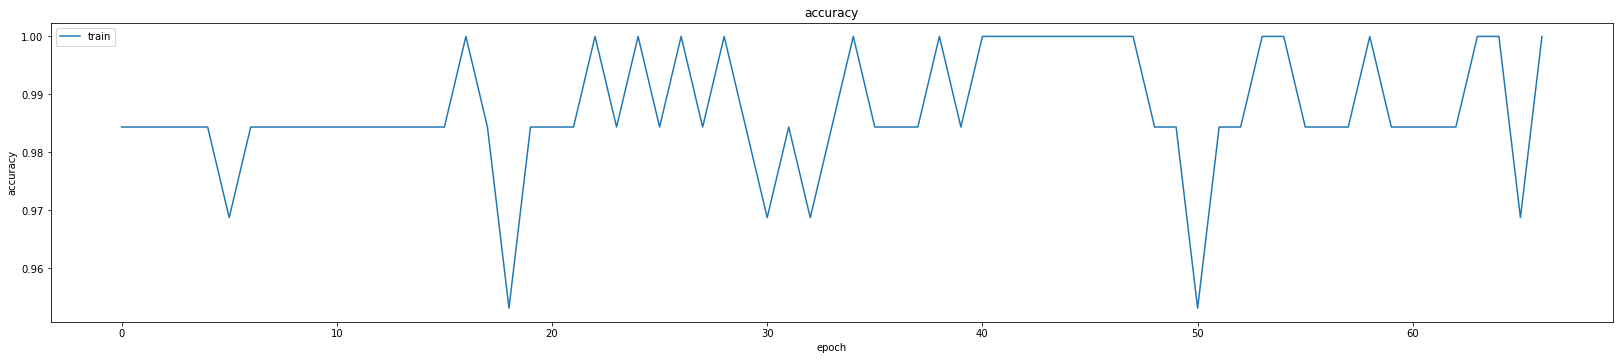

5312 5376


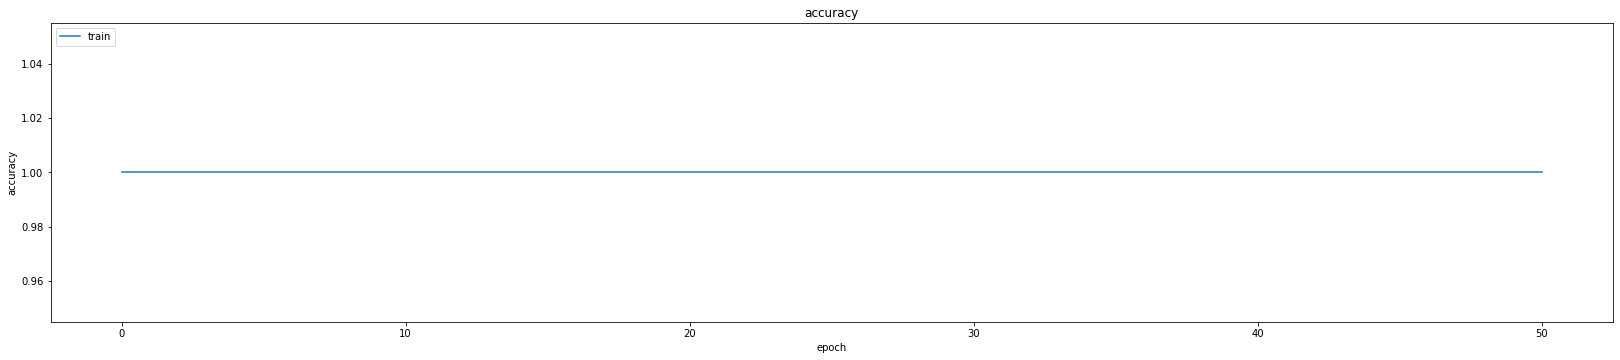

5376 5440


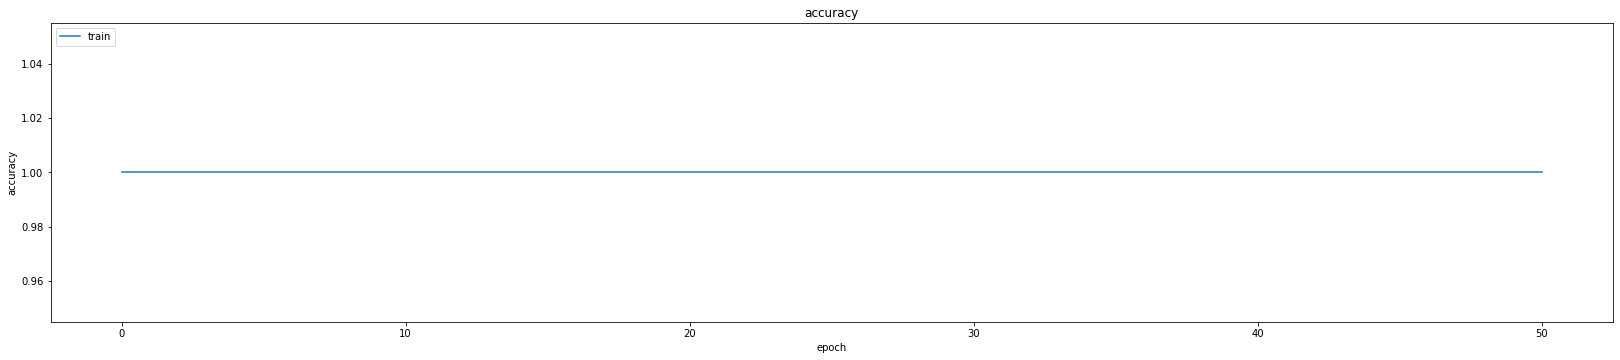

5440 5504


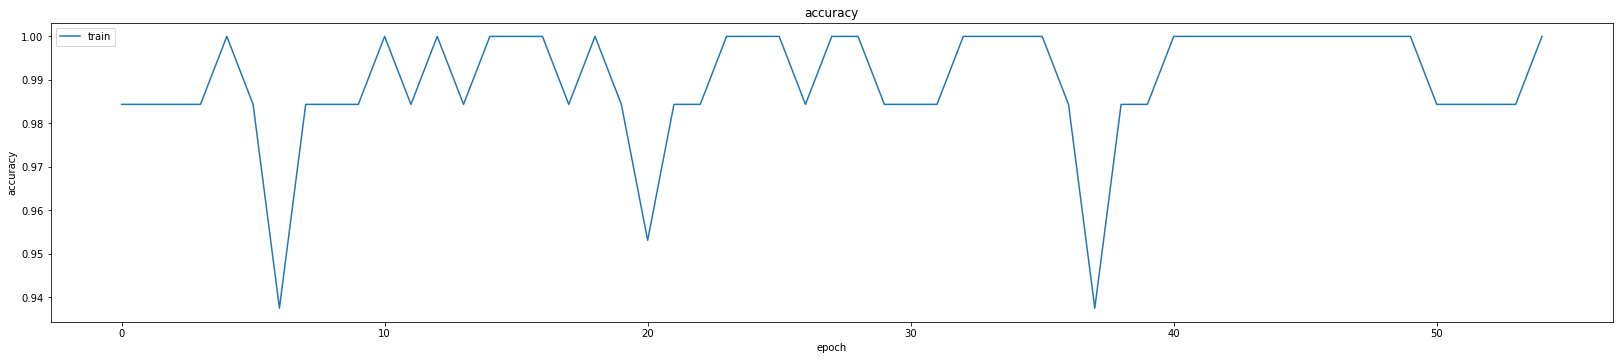

5504 5568


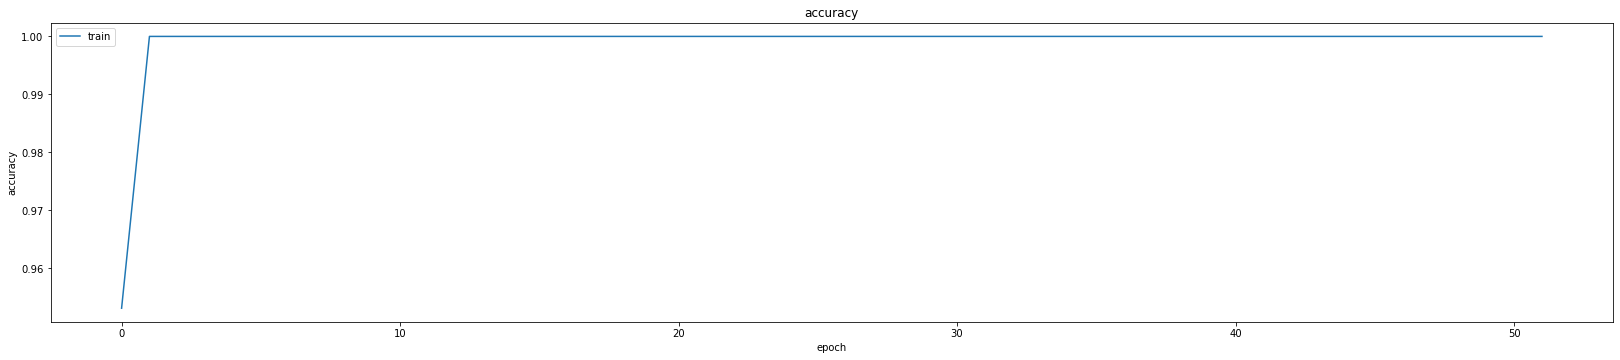

5568 5632


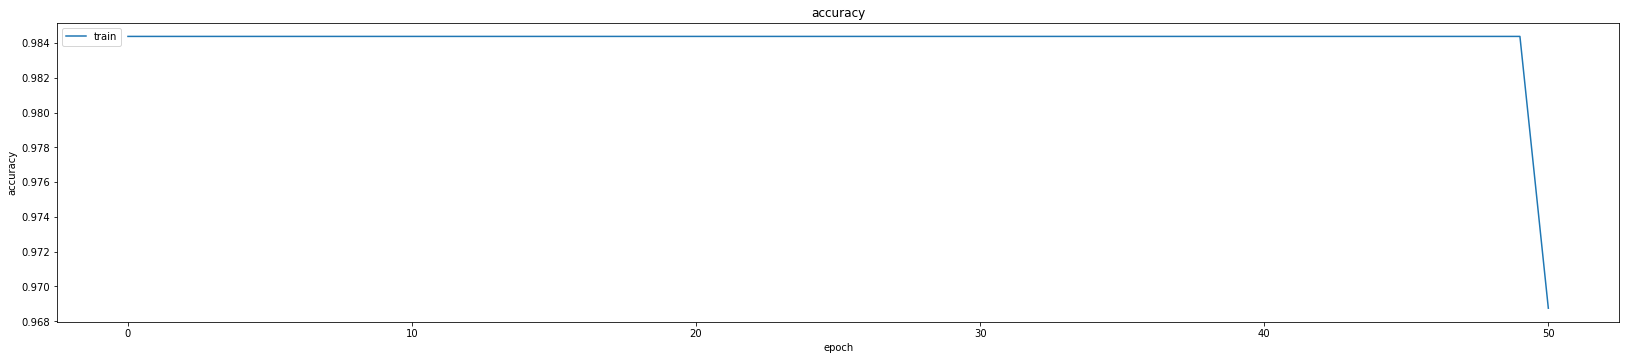

5632 5696


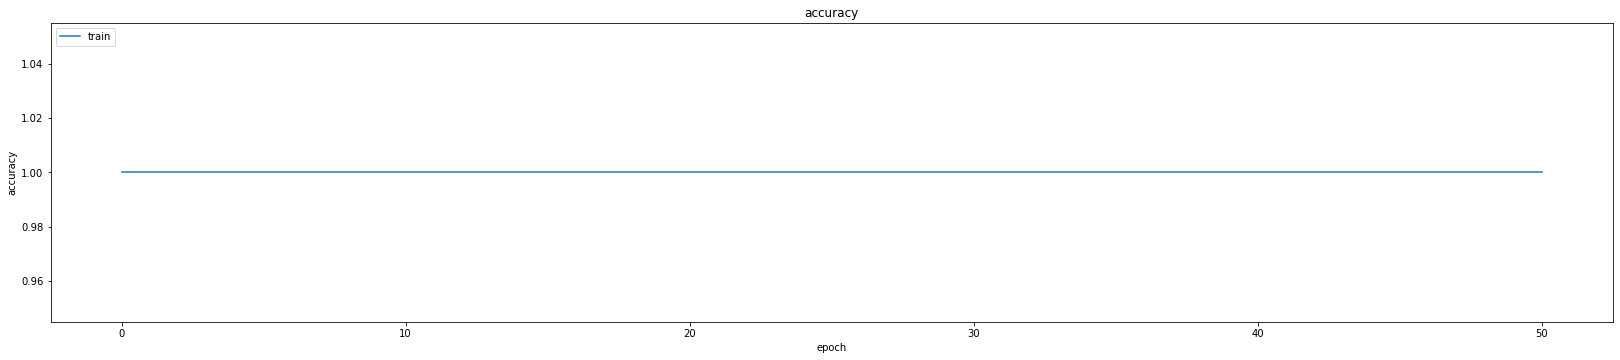

5696 5760


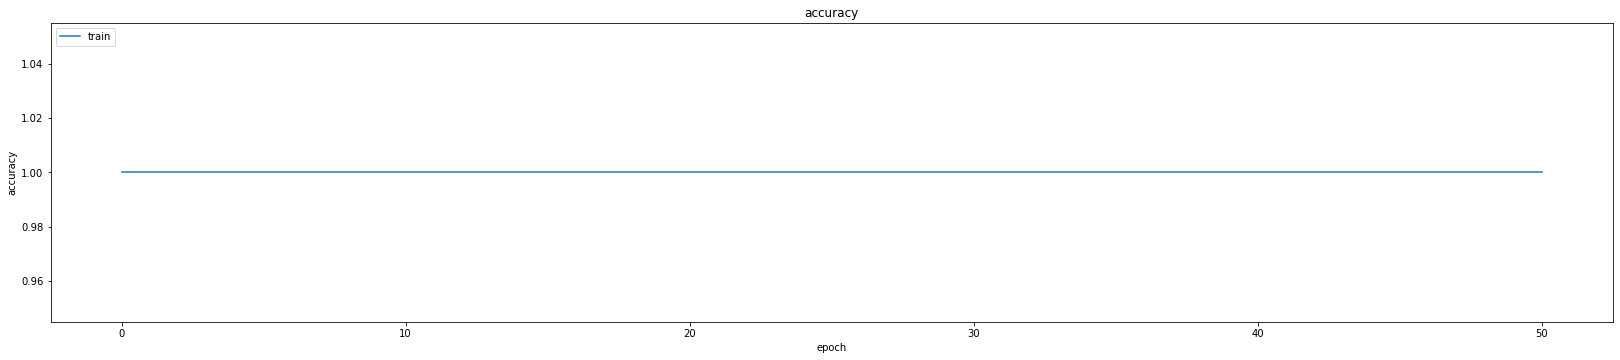

5760 5824


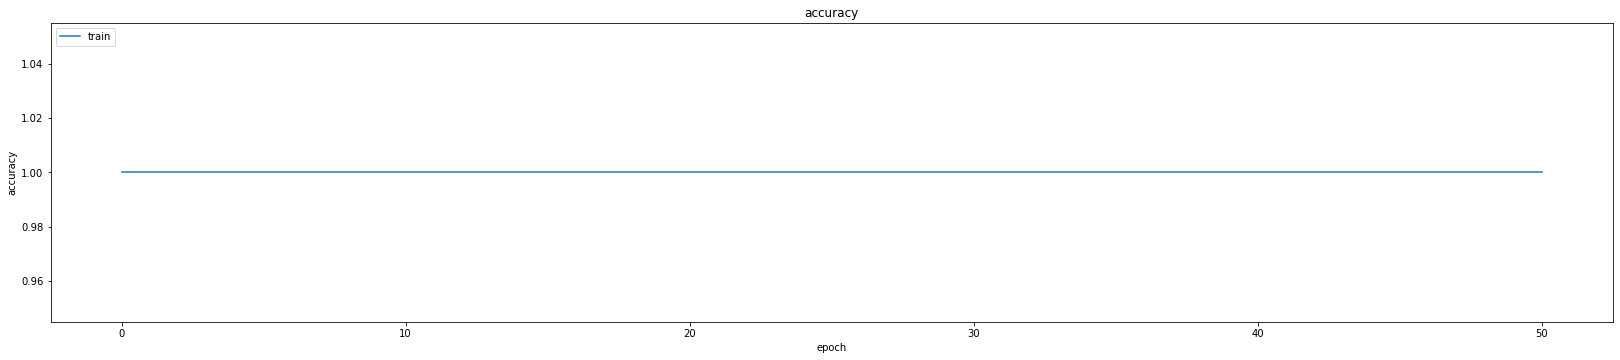

5824 5888


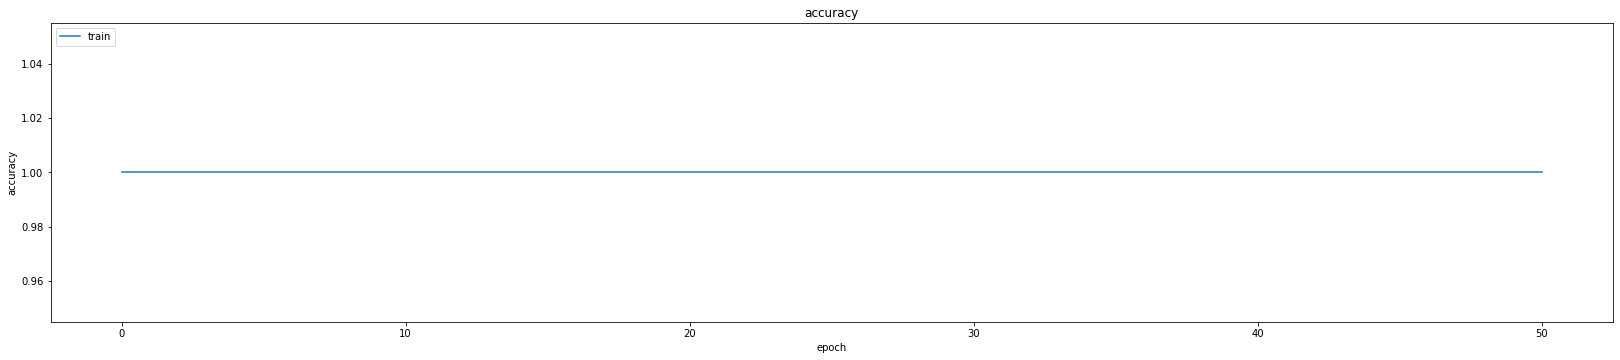

5888 5952


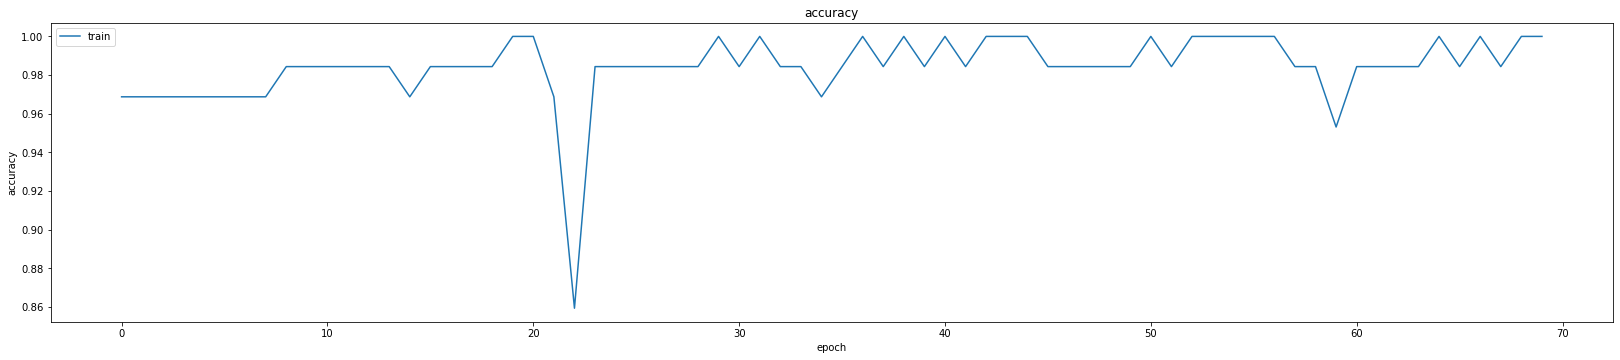

5952 6016


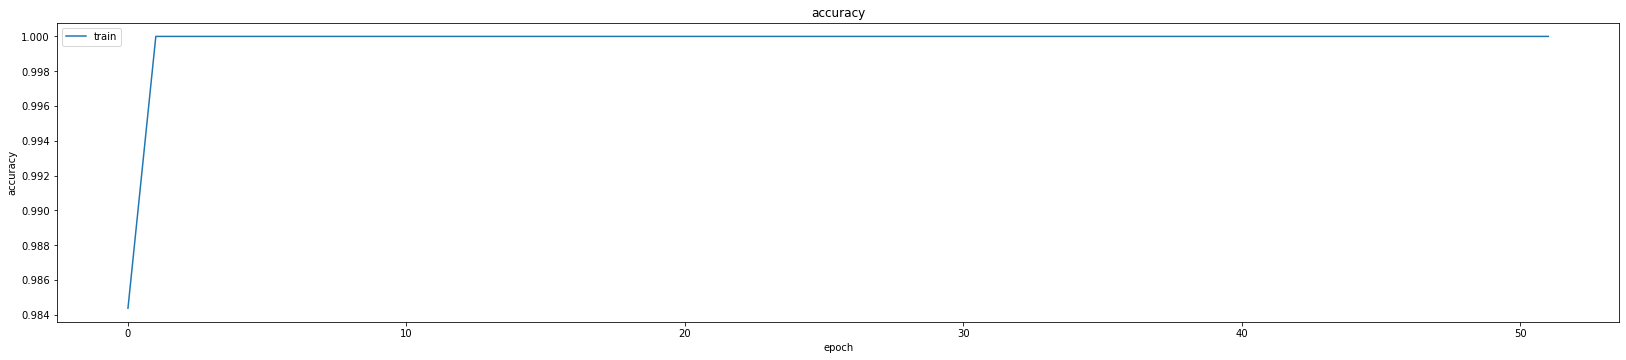

6016 6080


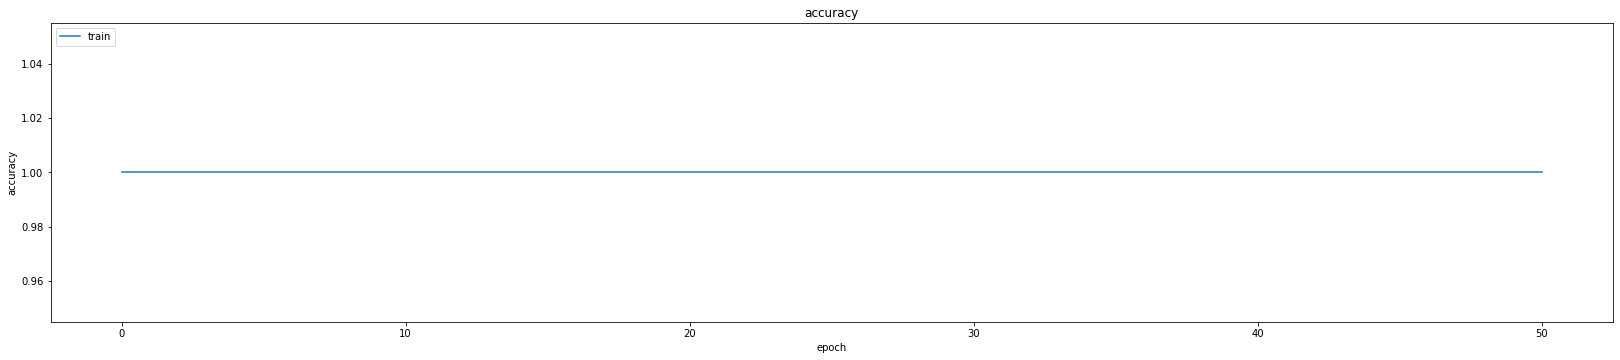

6080 6144


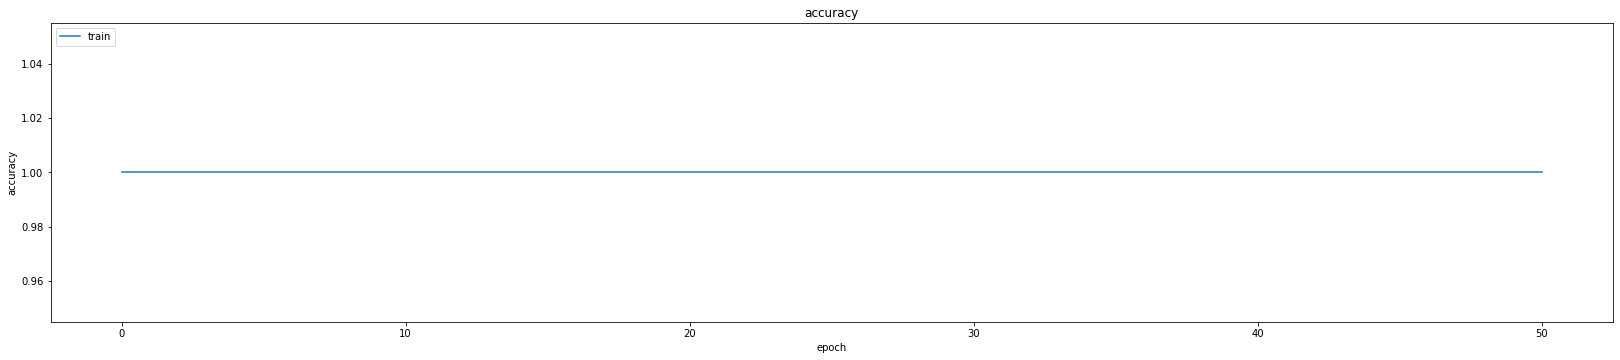

6144 6208


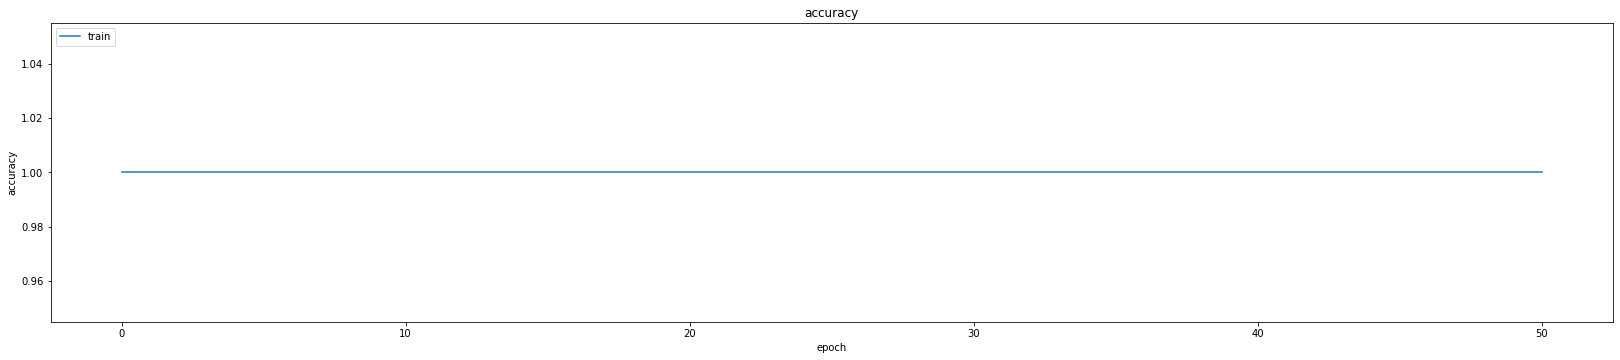

6208 6272


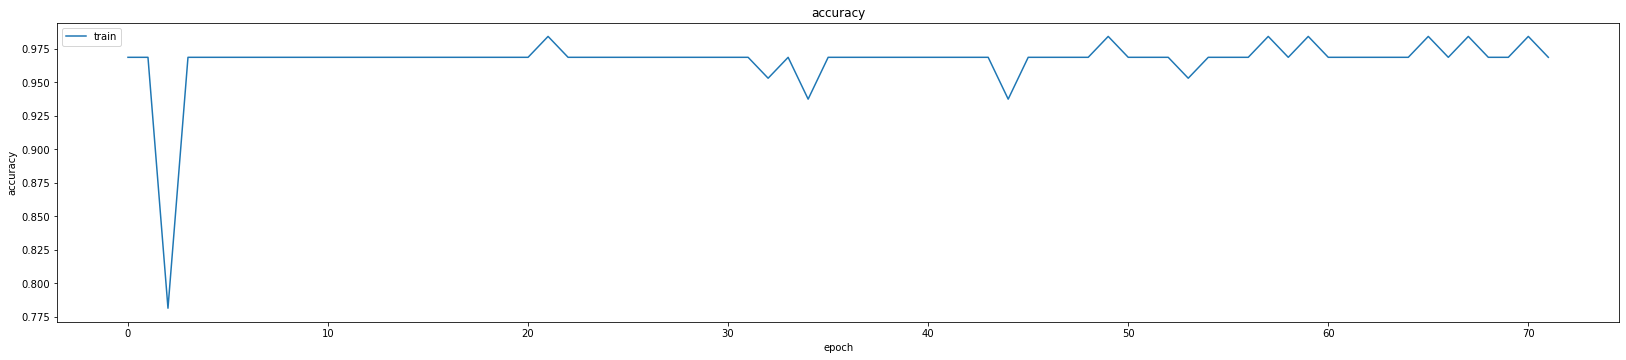

6272 6336


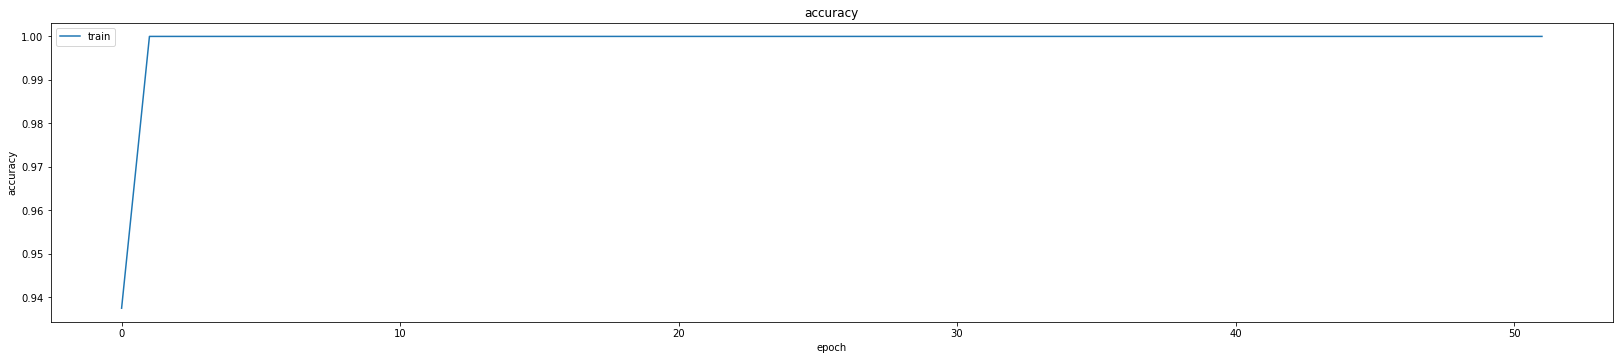

6336 6400


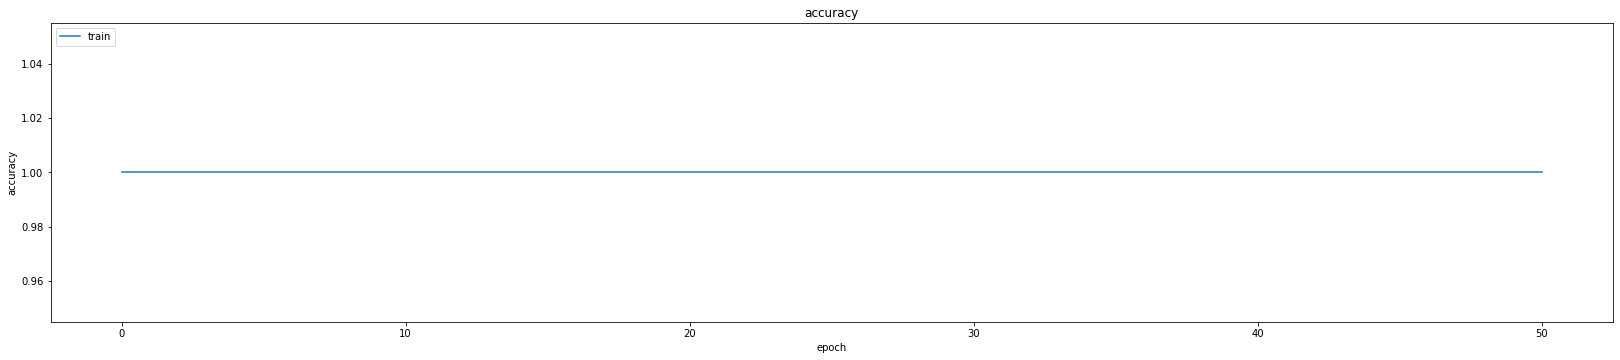

6400 6464


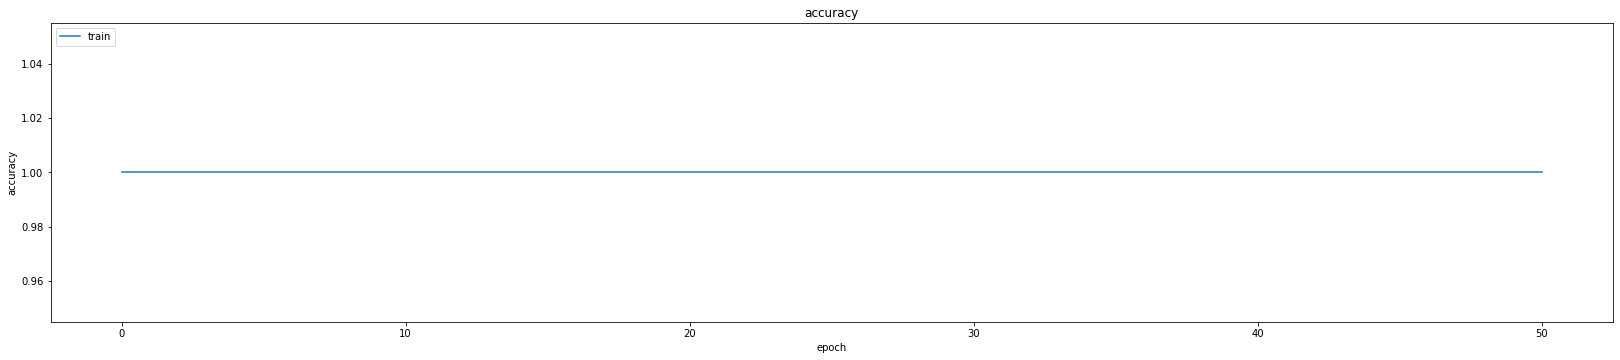

6464 6528


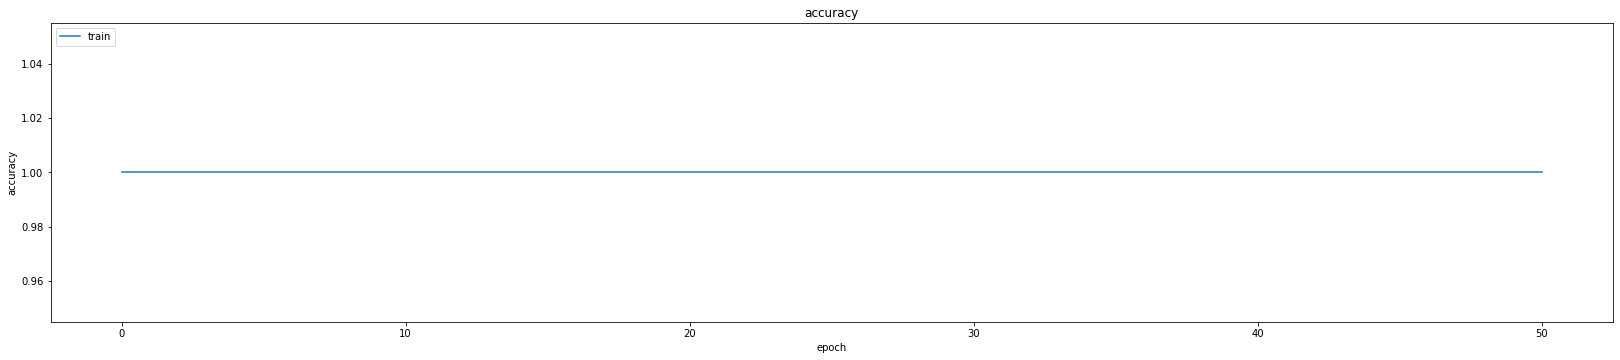

6528 6592


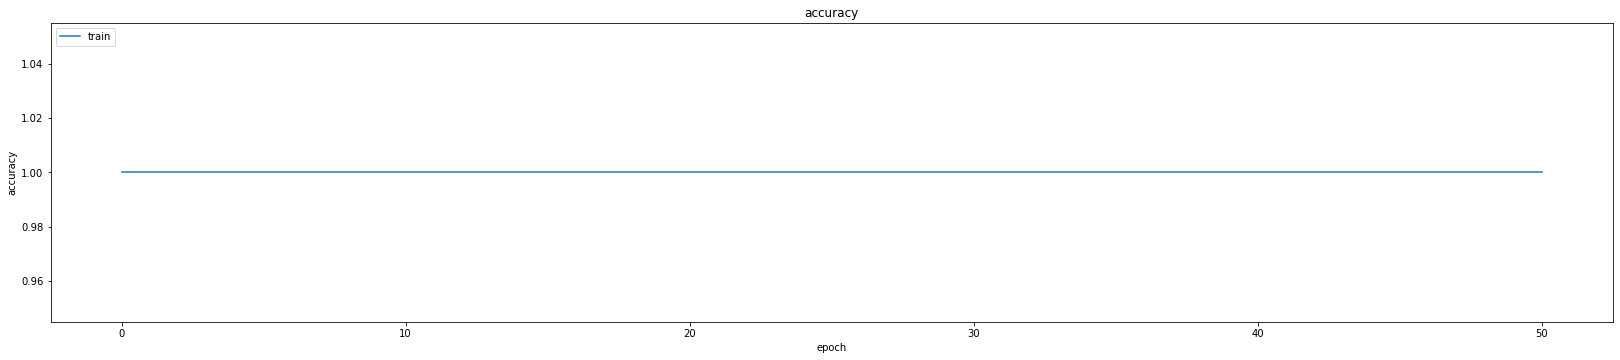

6592 6656


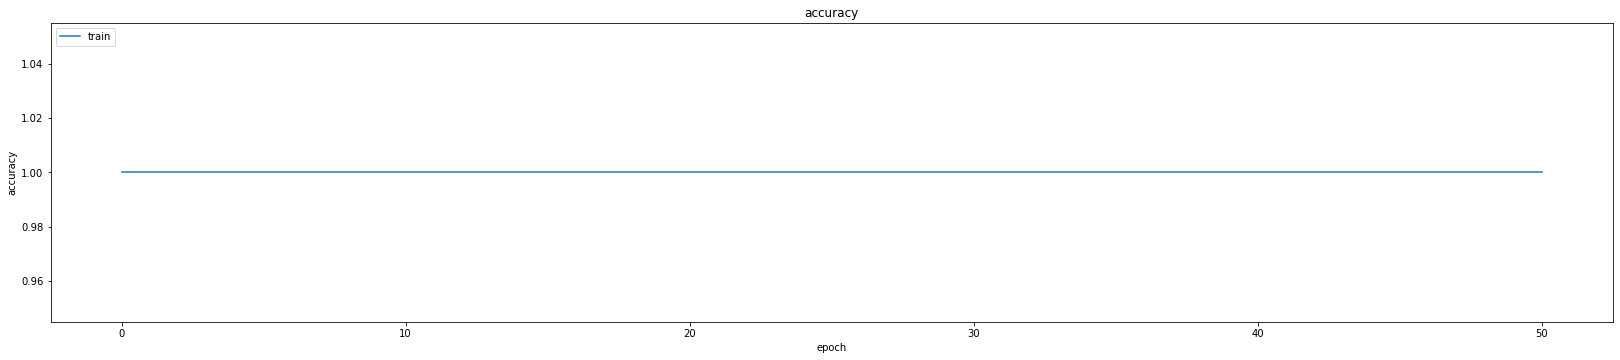

6656 6720


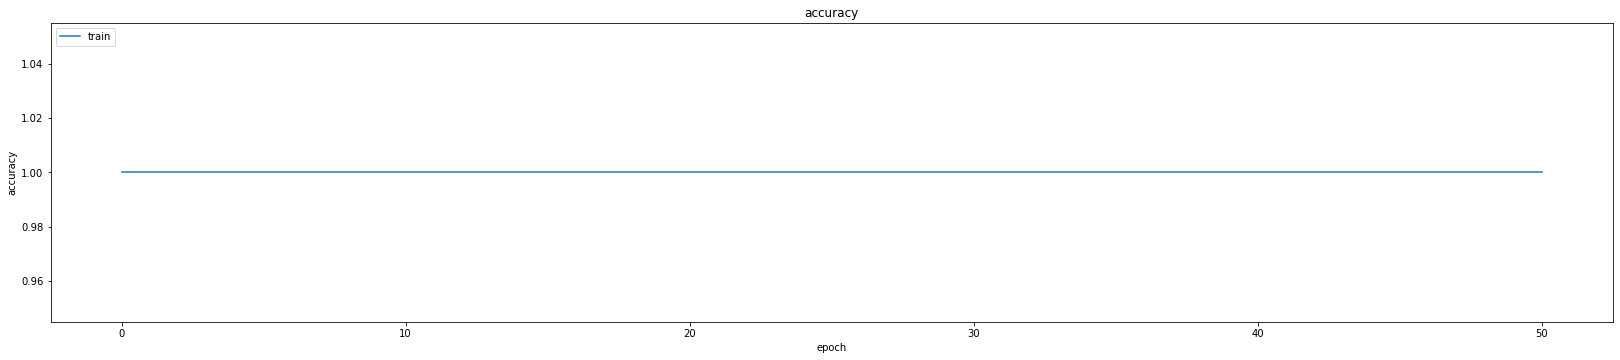

6720 6784


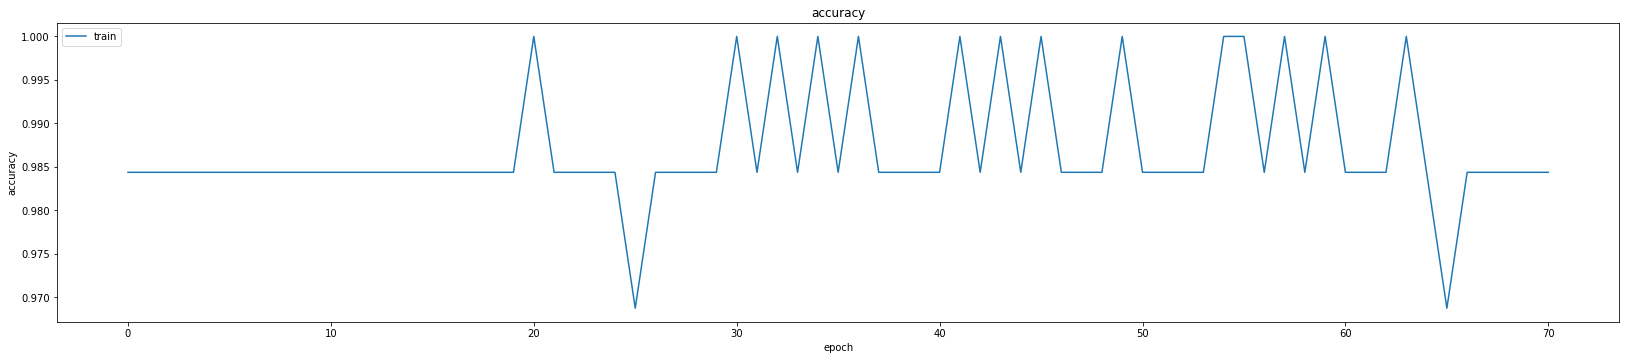

6784 6848


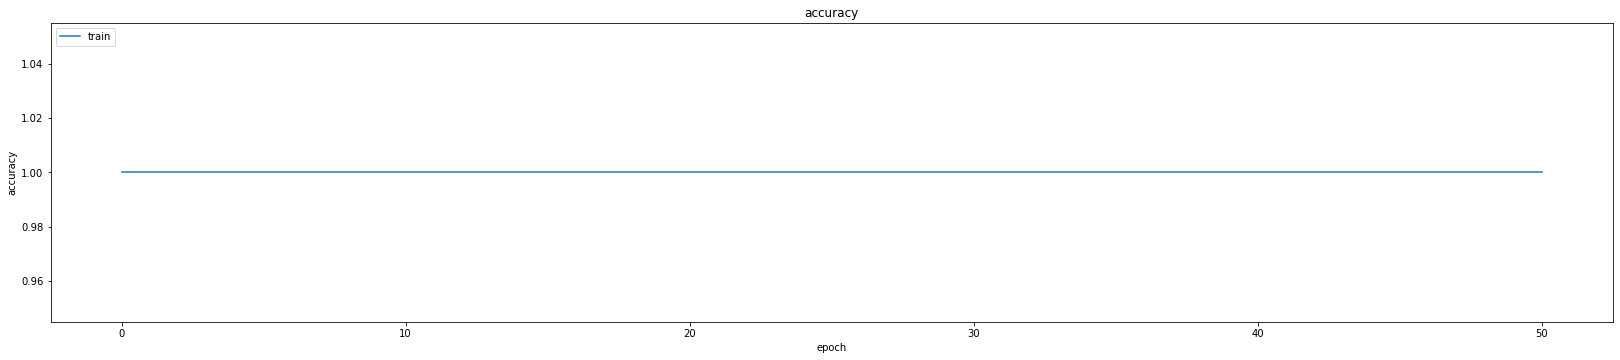

6848 6912


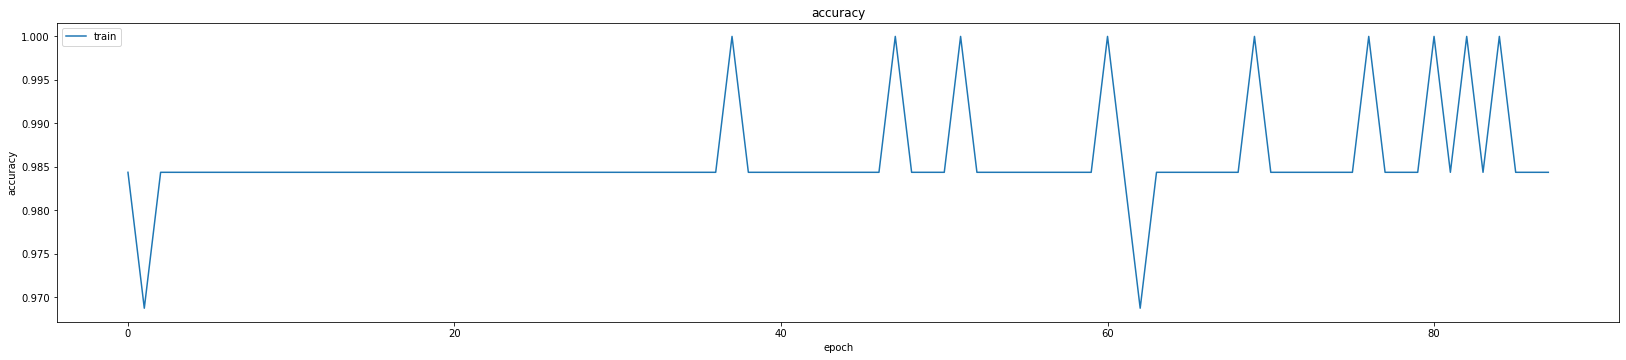

6912 6976


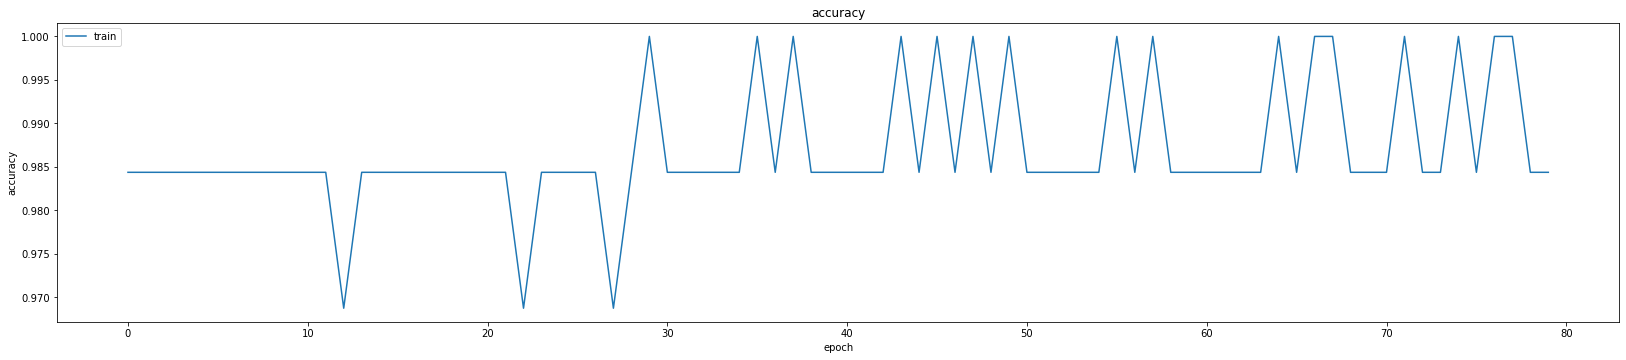

6976 7040


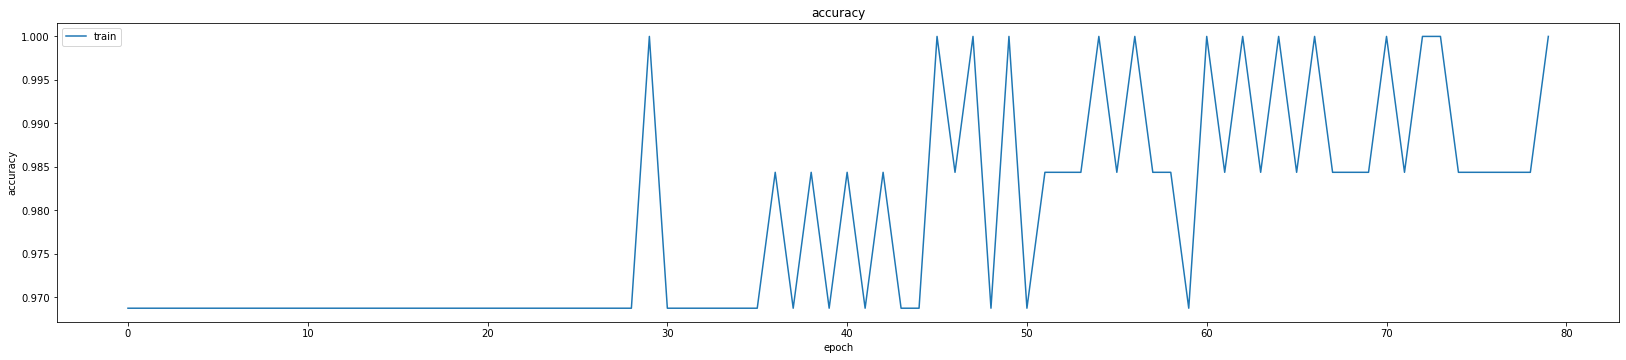

7040 7104


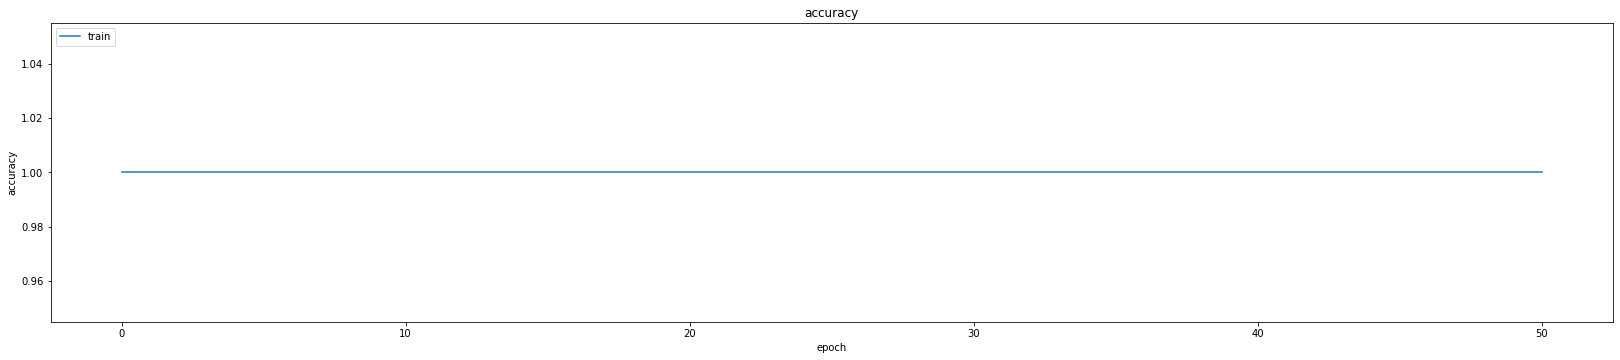

7104 7168


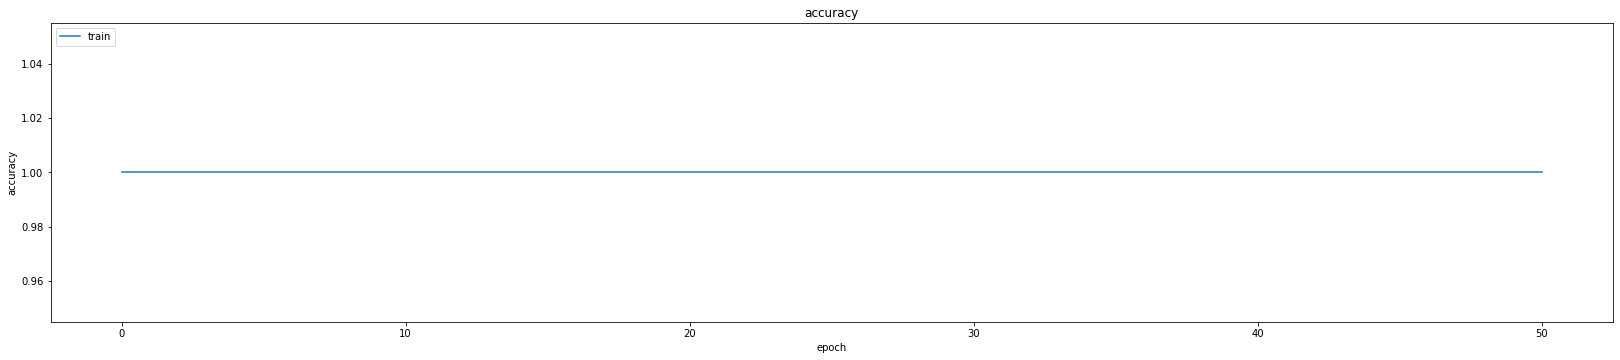

7168 7232


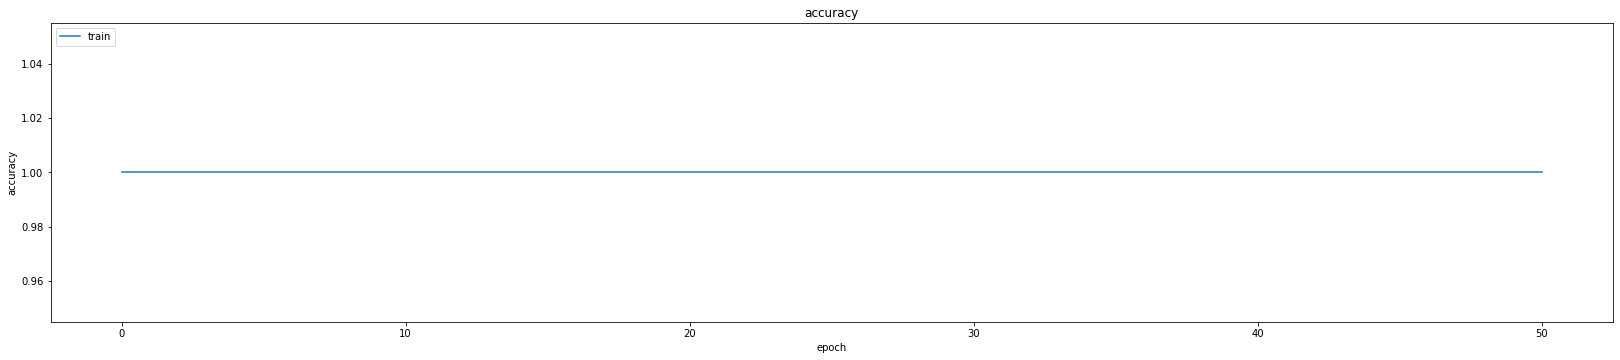

7232 7296


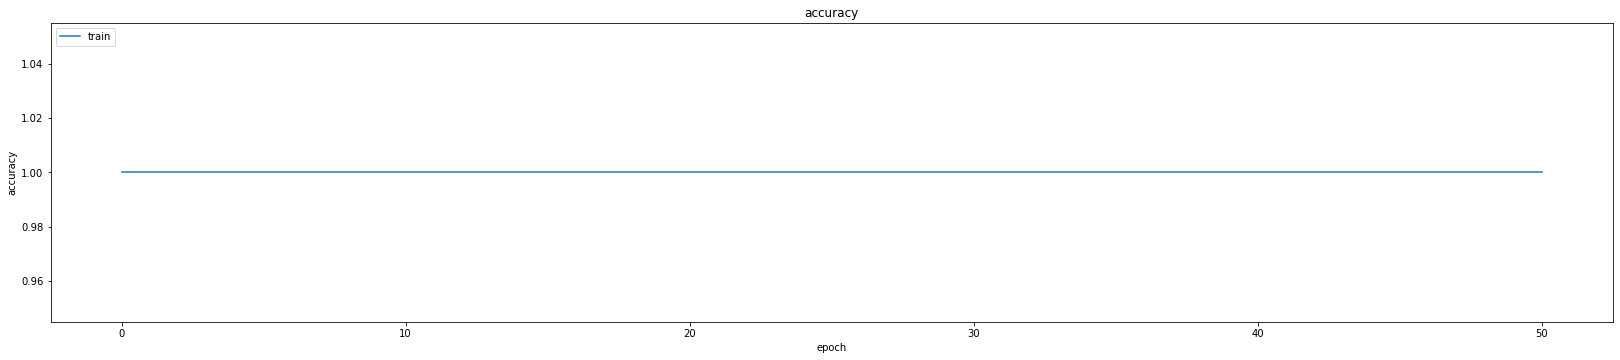

7296 7360


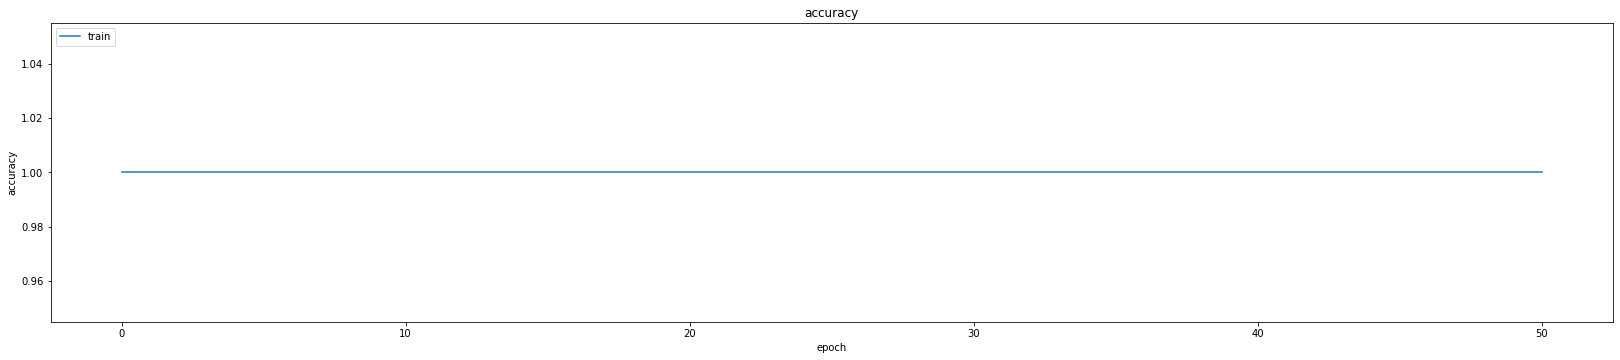

7360 7424


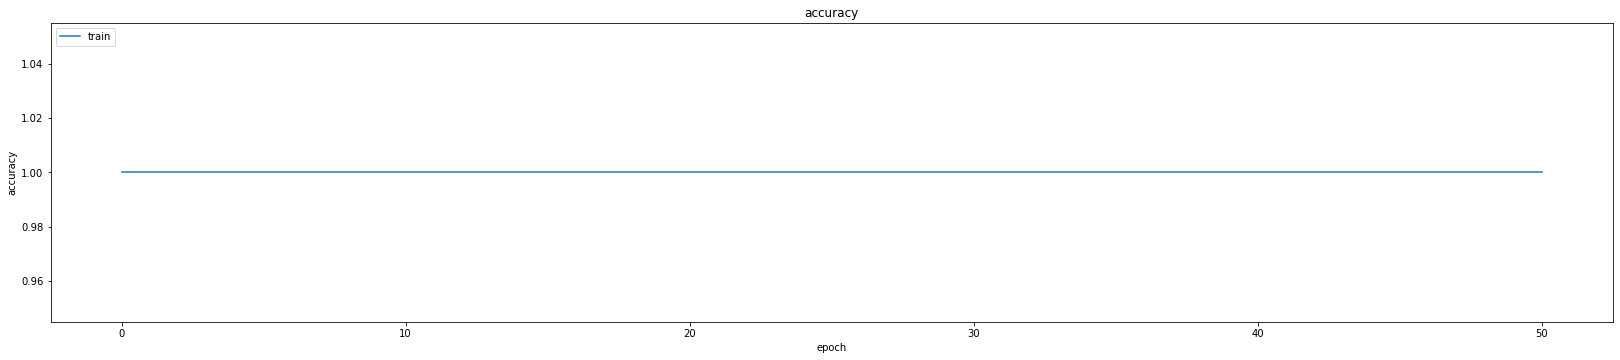

7424 7488


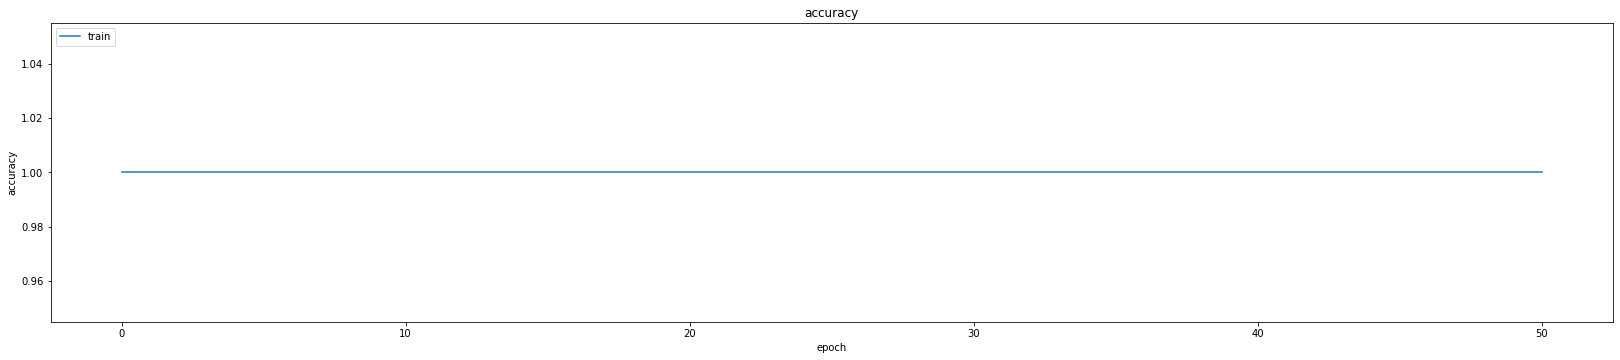

7488 7552


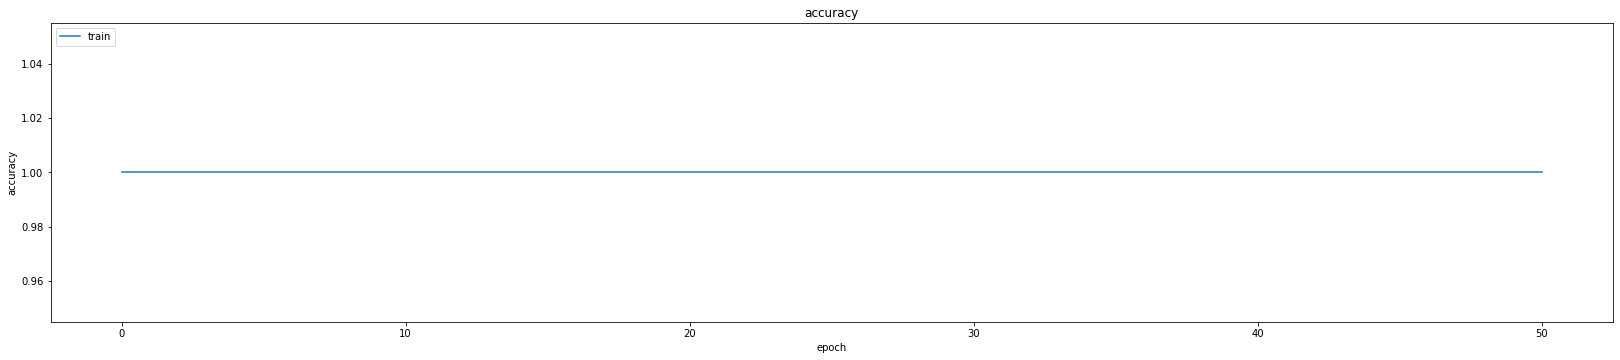

7552 7616


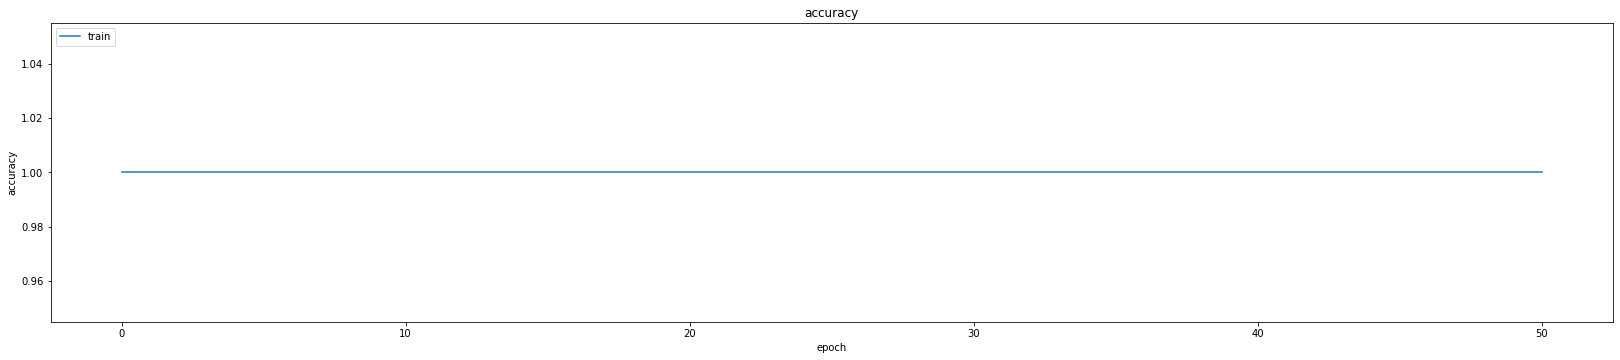

7616 7680


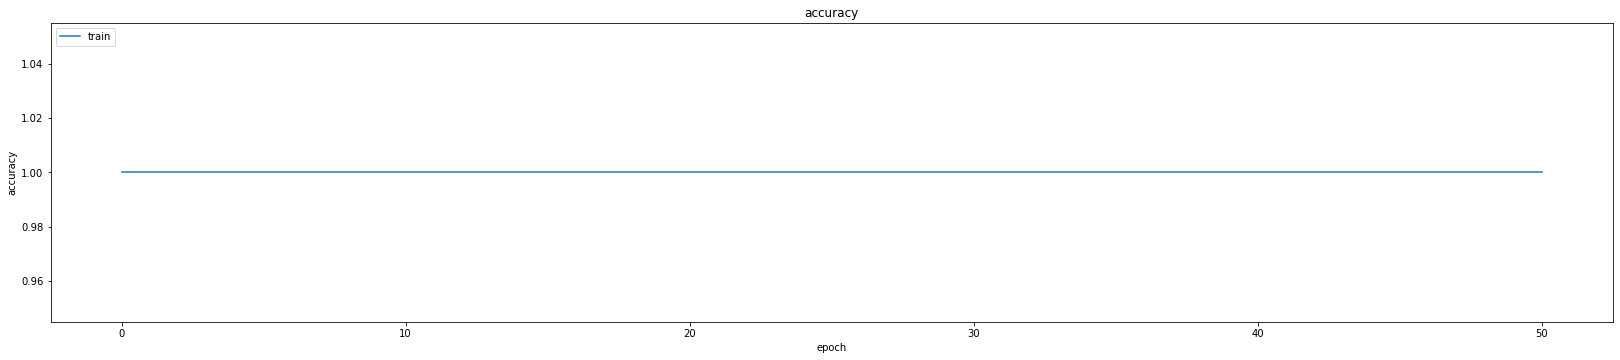

7680 7744


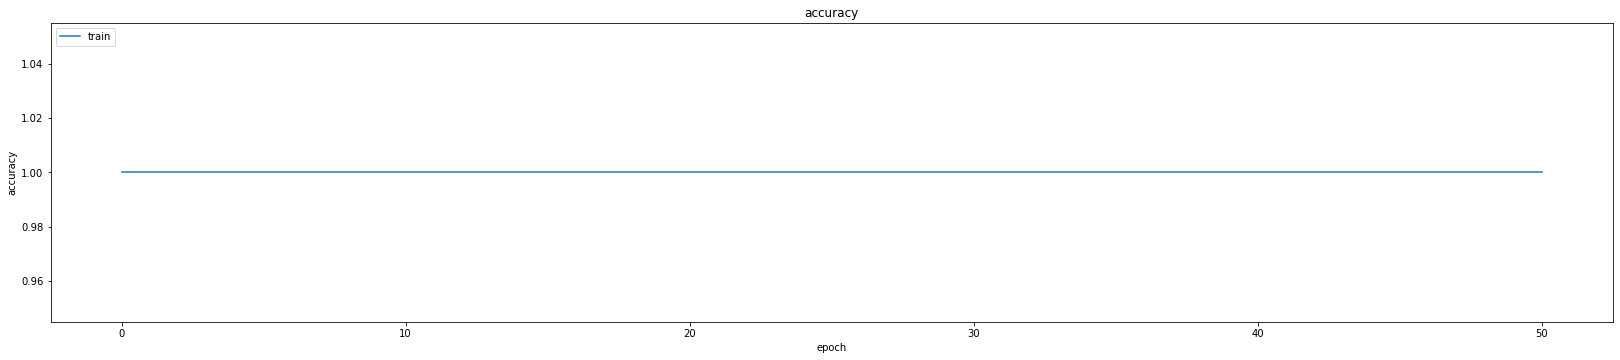

7744 7808


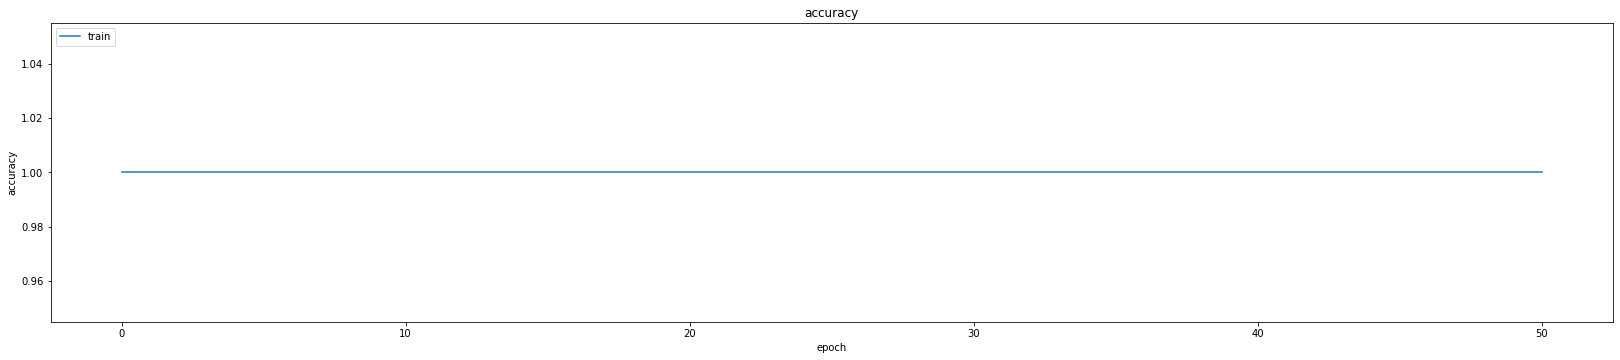

7808 7872


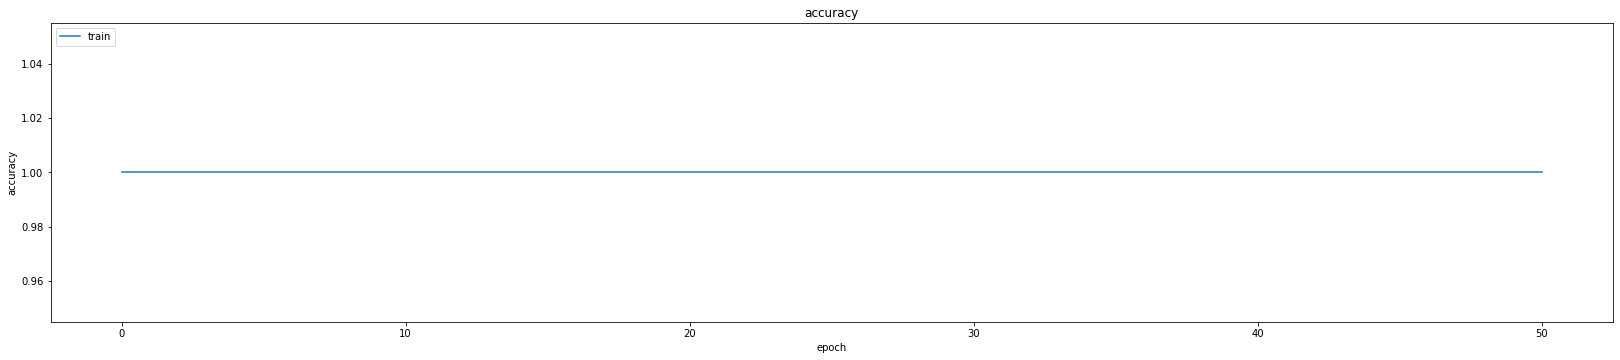

7872 7936


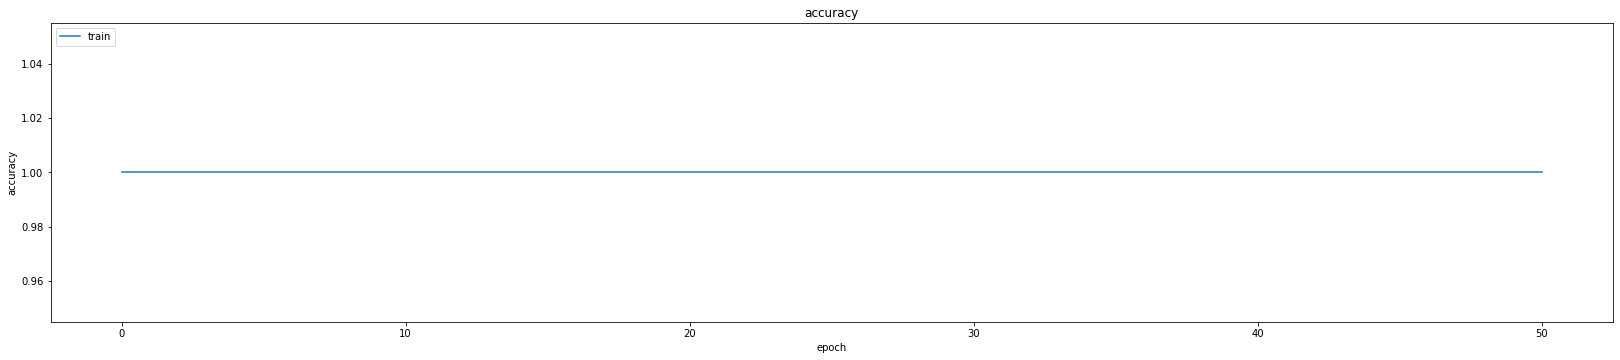

7936 8000


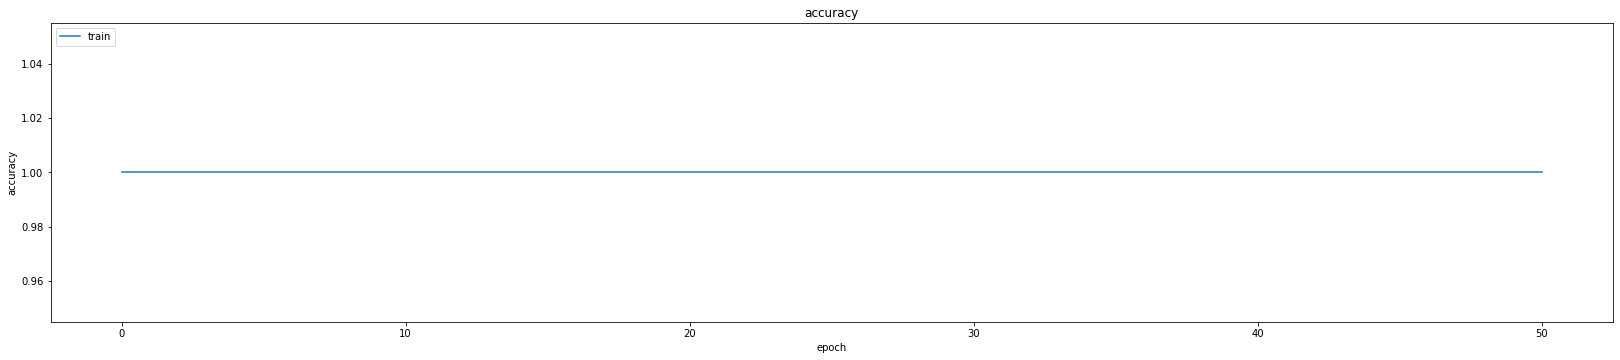

8000 8064


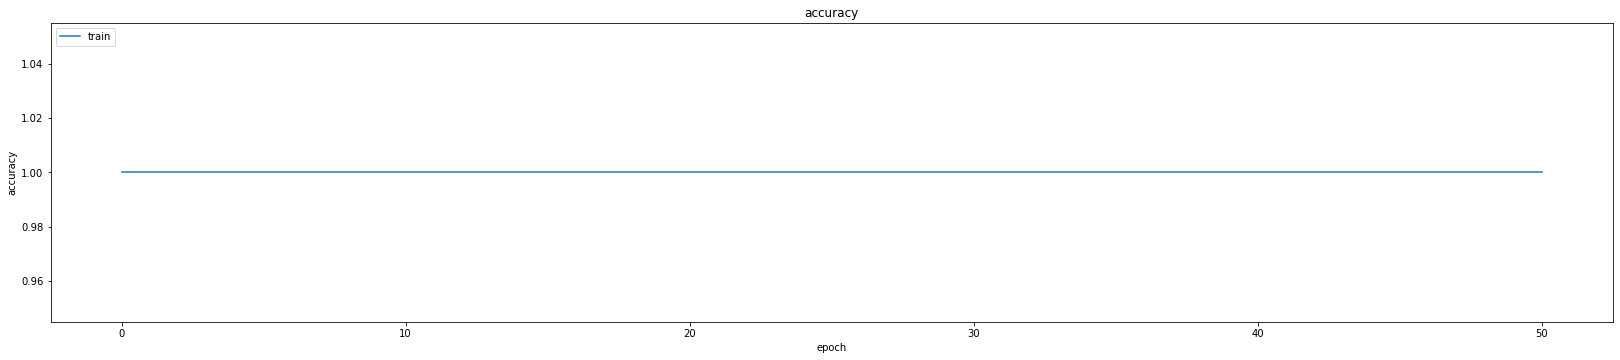

8064 8128


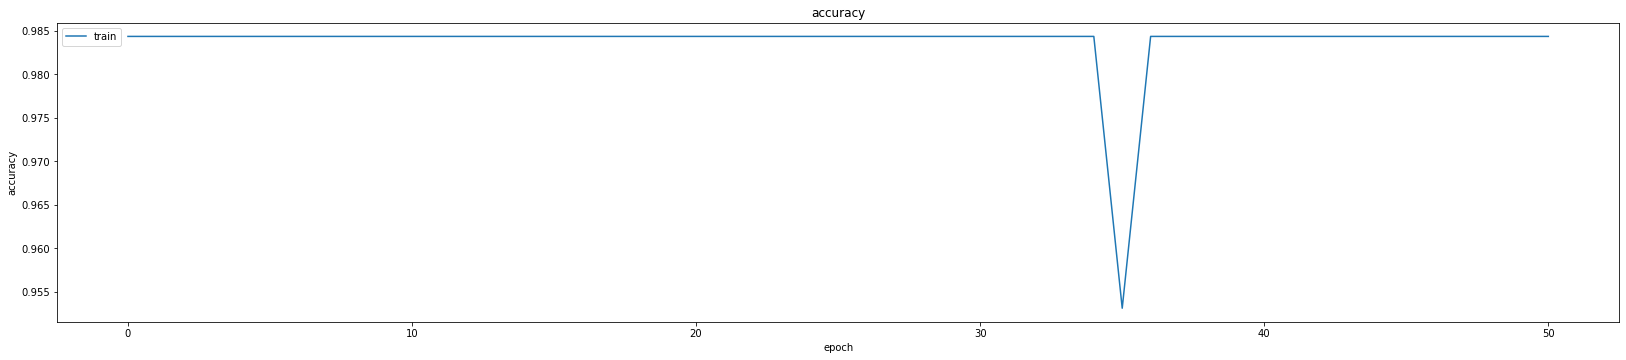

8128 8192


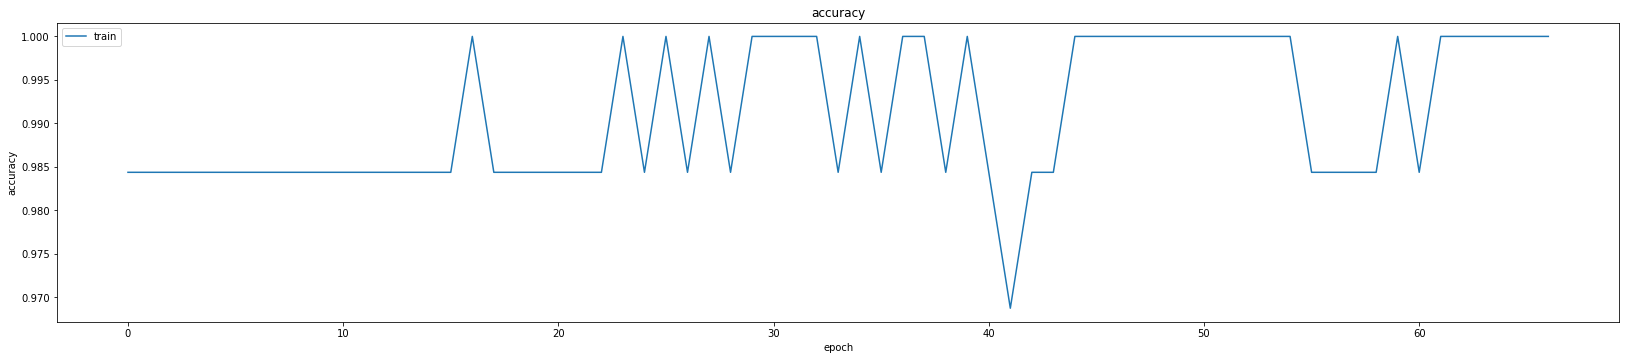

8192 8256


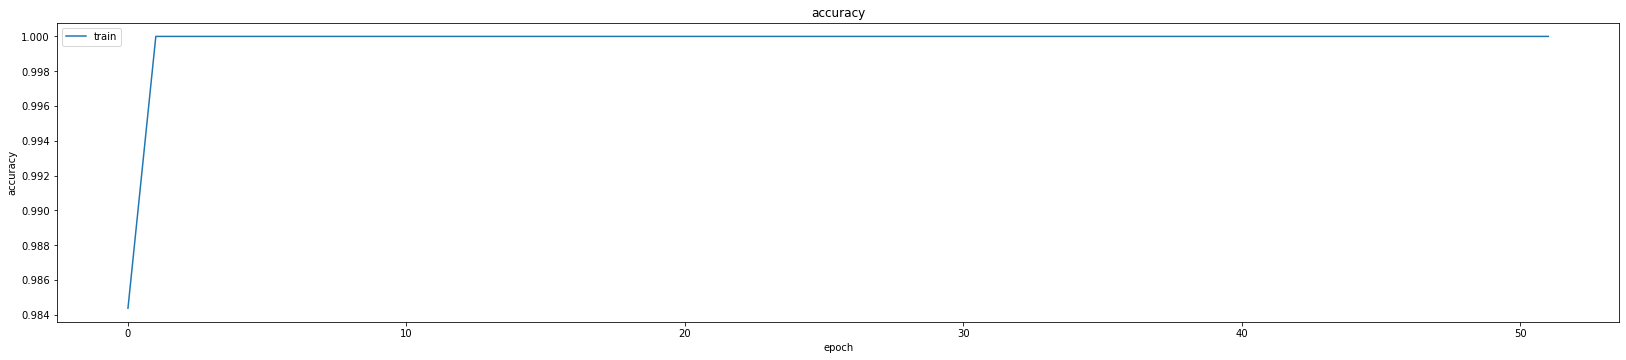

8256 8320


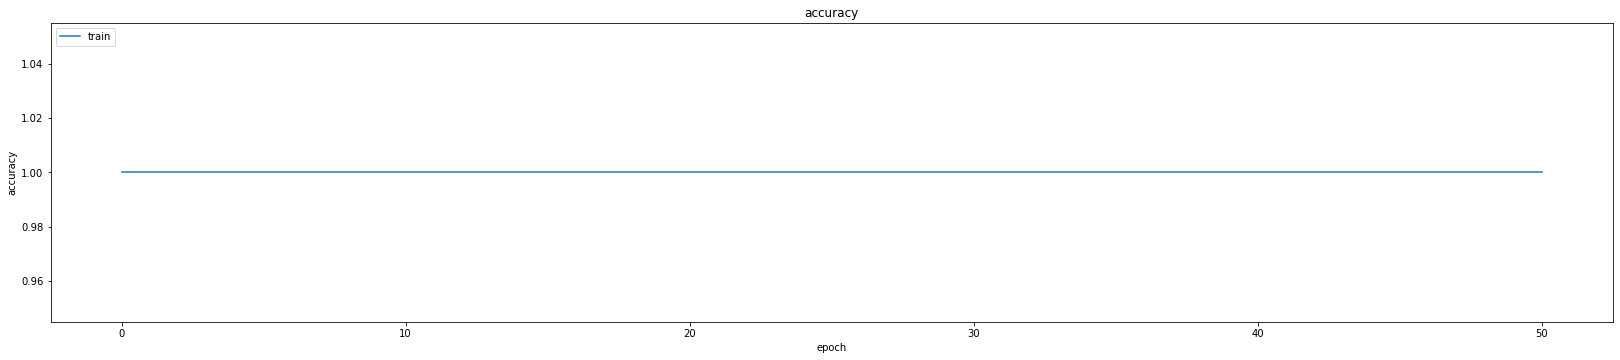

8320 8384


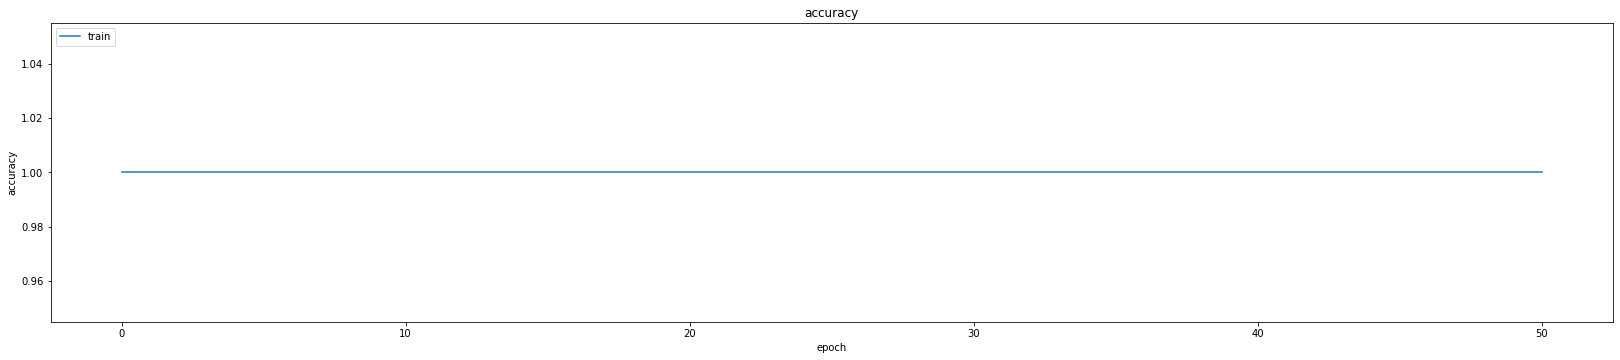

8384 8448


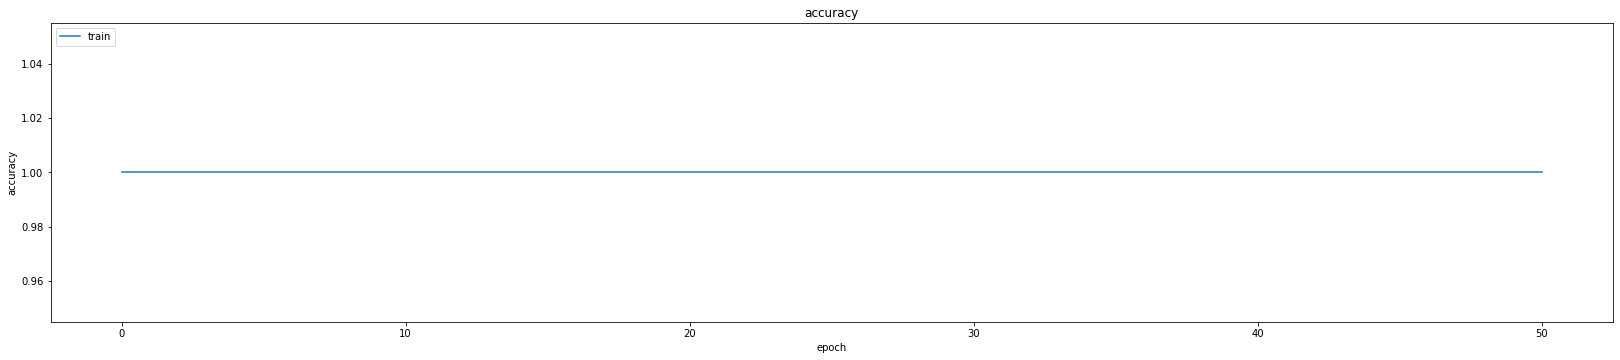

8448 8512


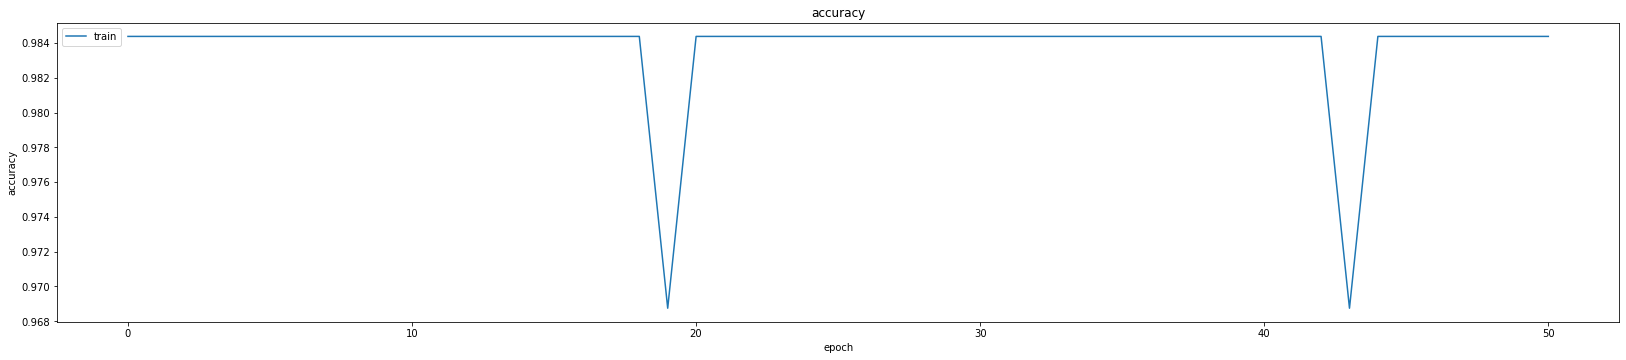

8512 8576


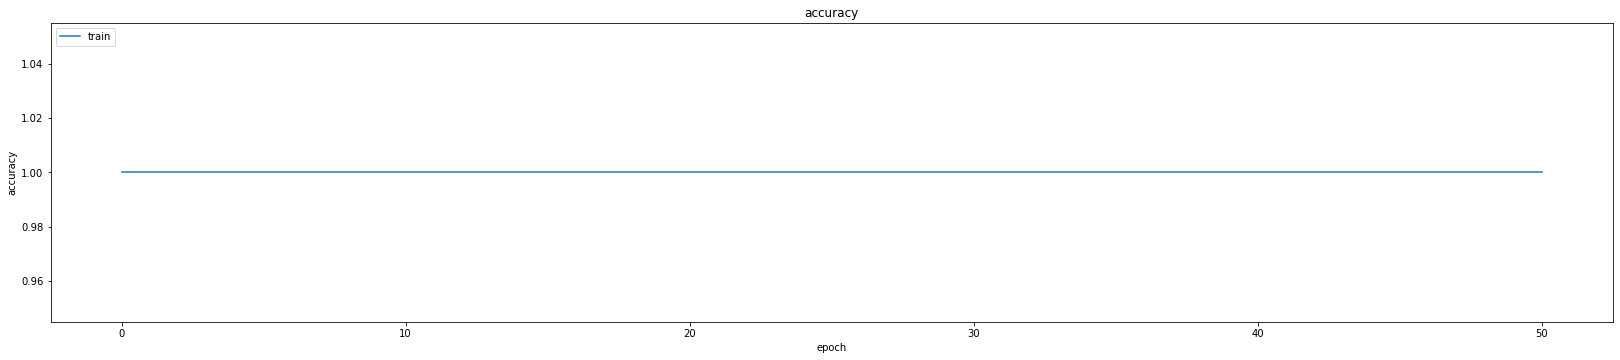

8576 8640


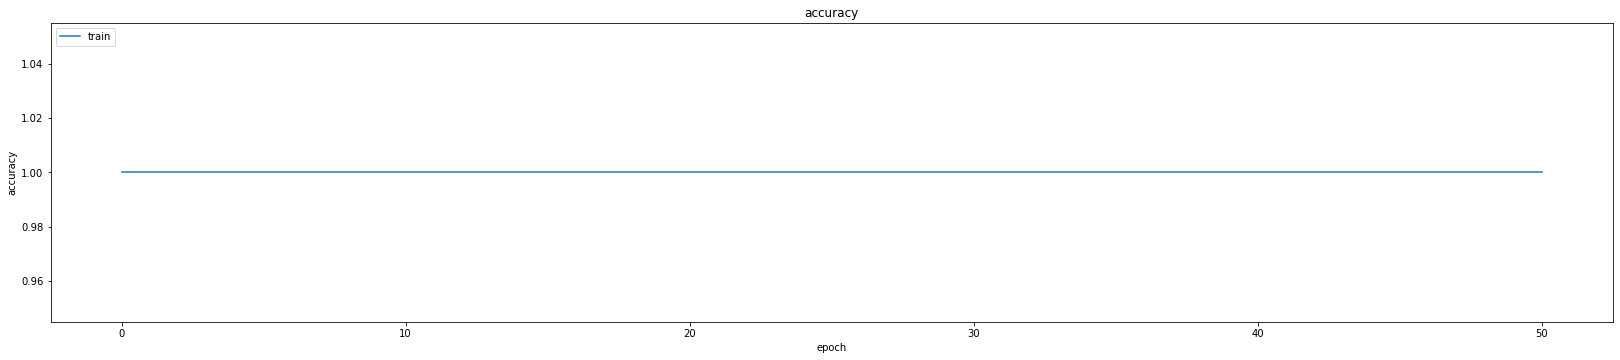

8640 8704


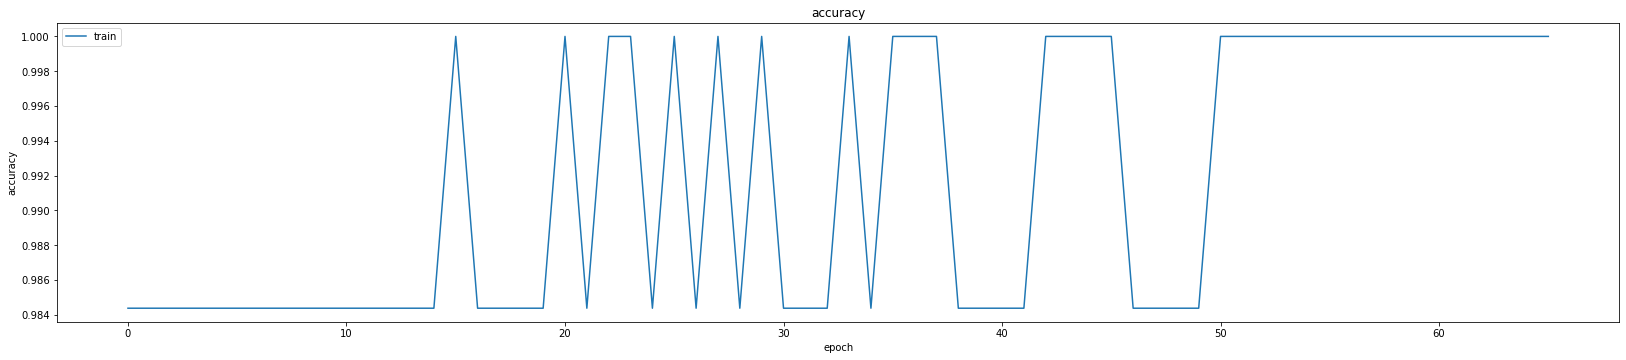

8704 8768


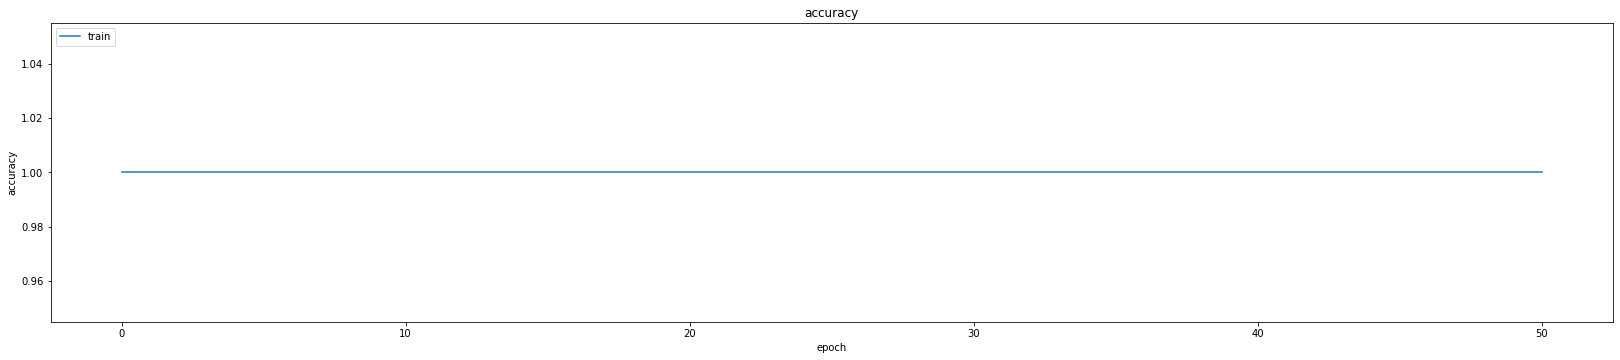

8768 8832


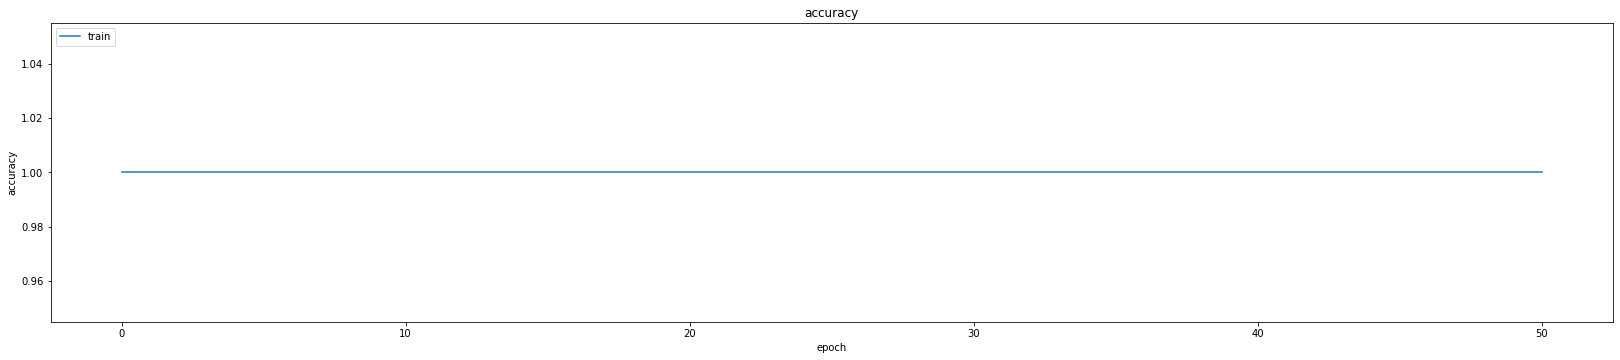

8832 8896


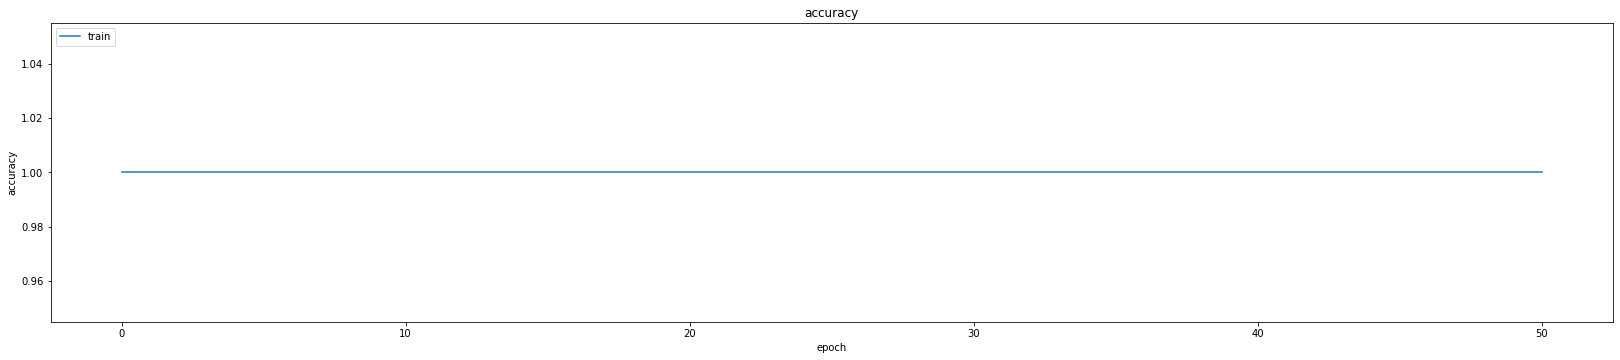

8896 8960


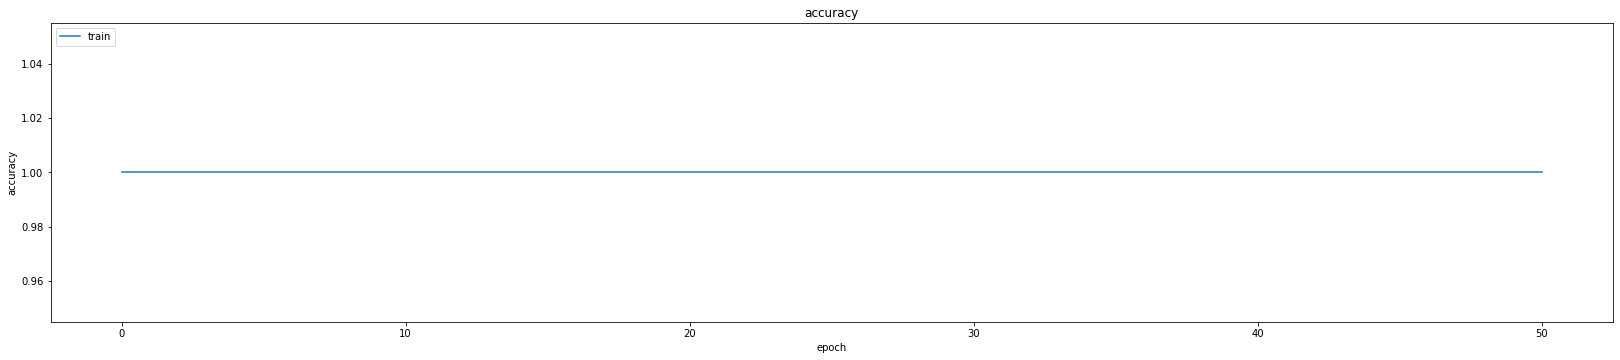

8960 9024


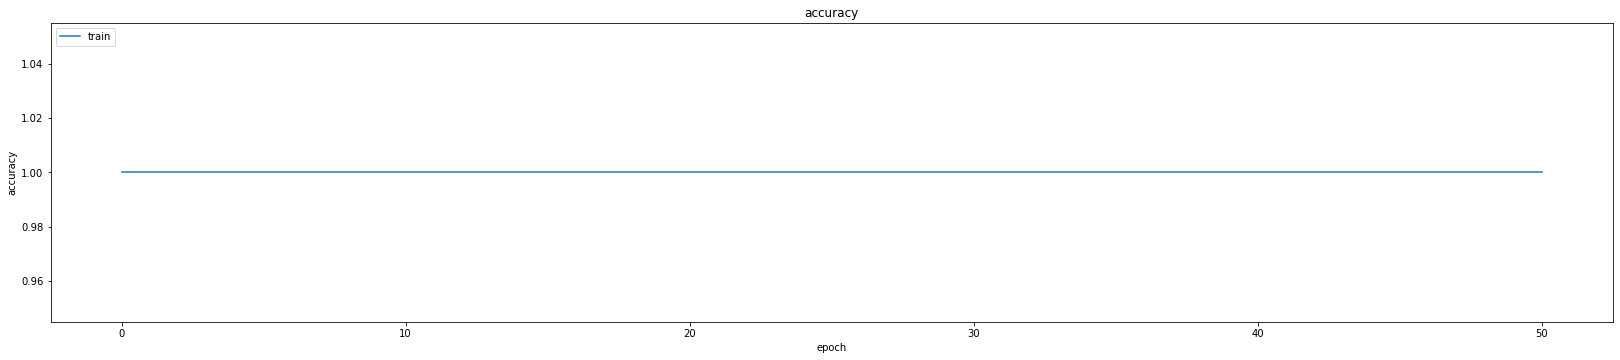

9024 9088


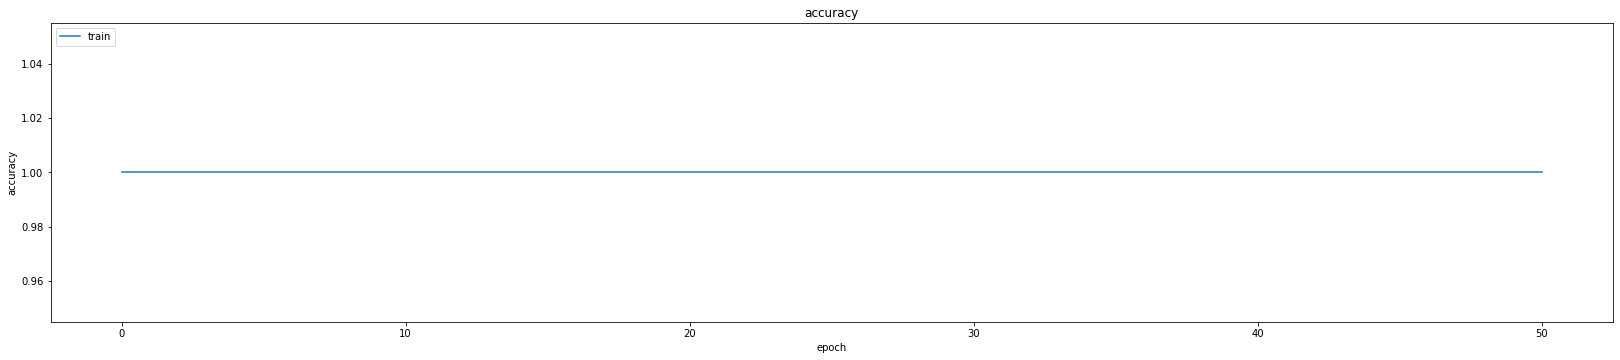

9088 9152


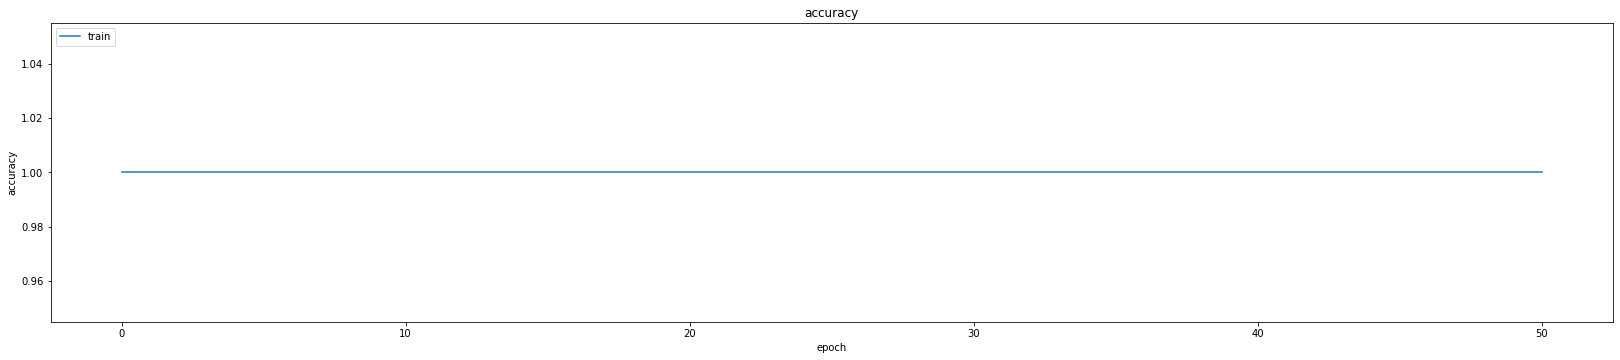

9152 9216


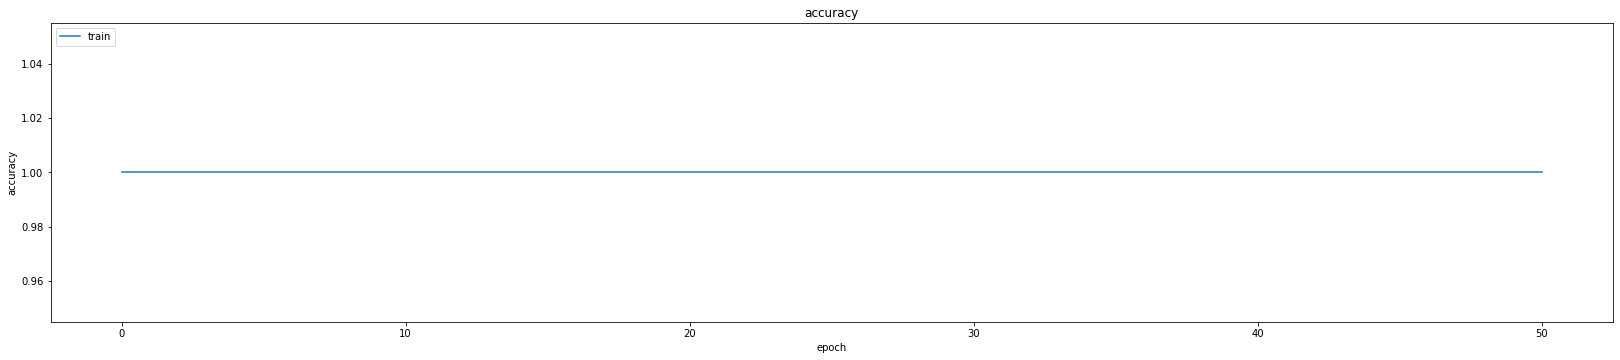

9216 9280


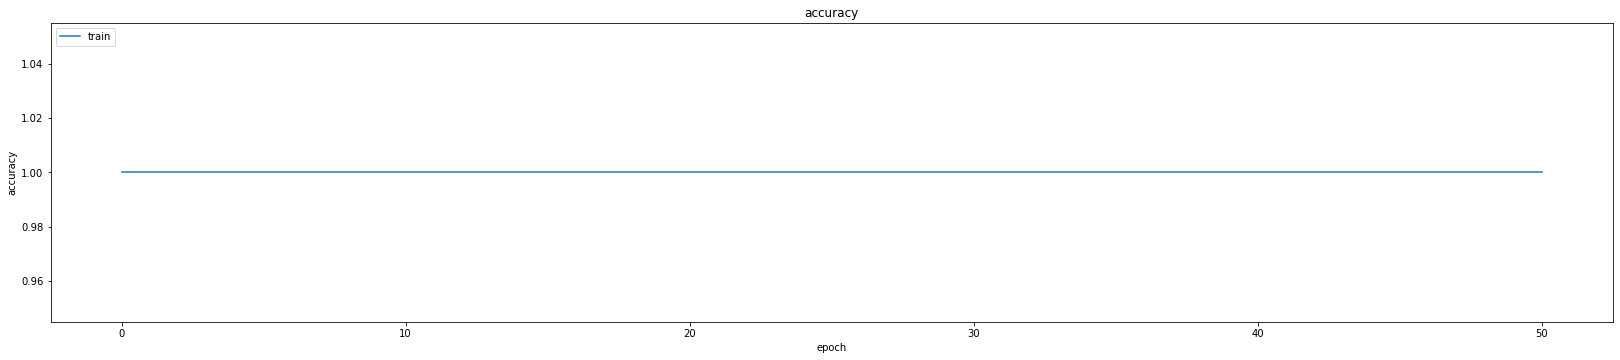

9280 9344


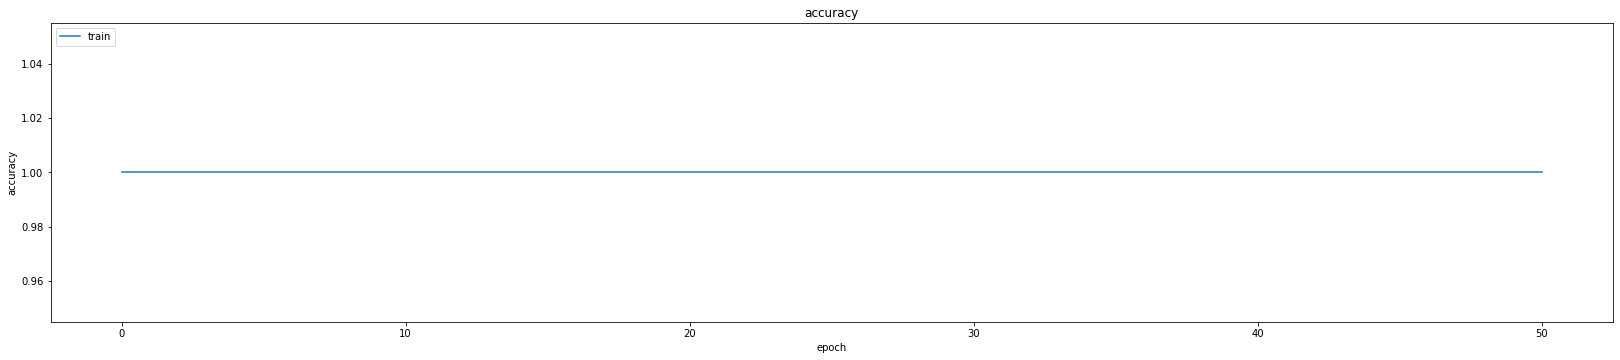

9344 9408


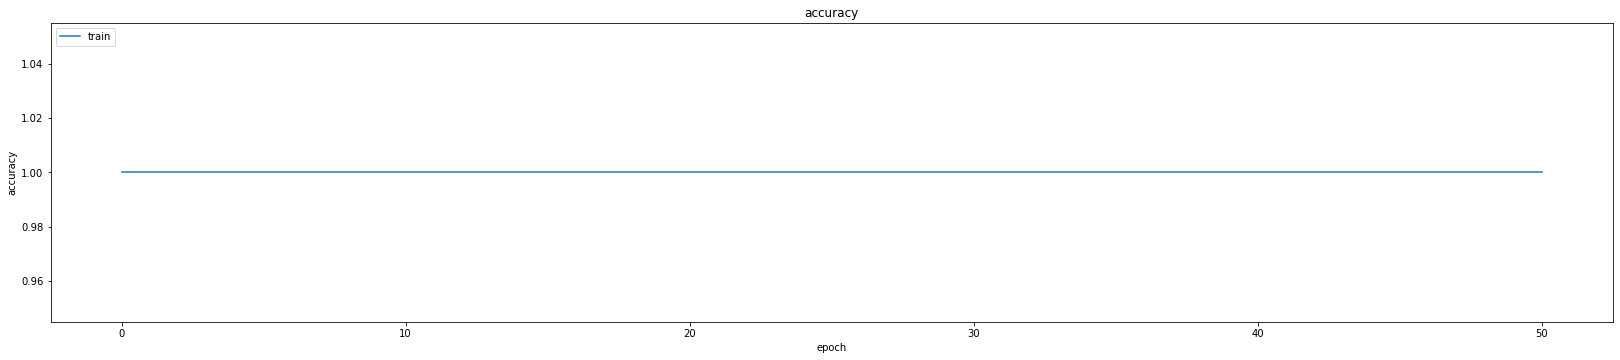

9408 9472


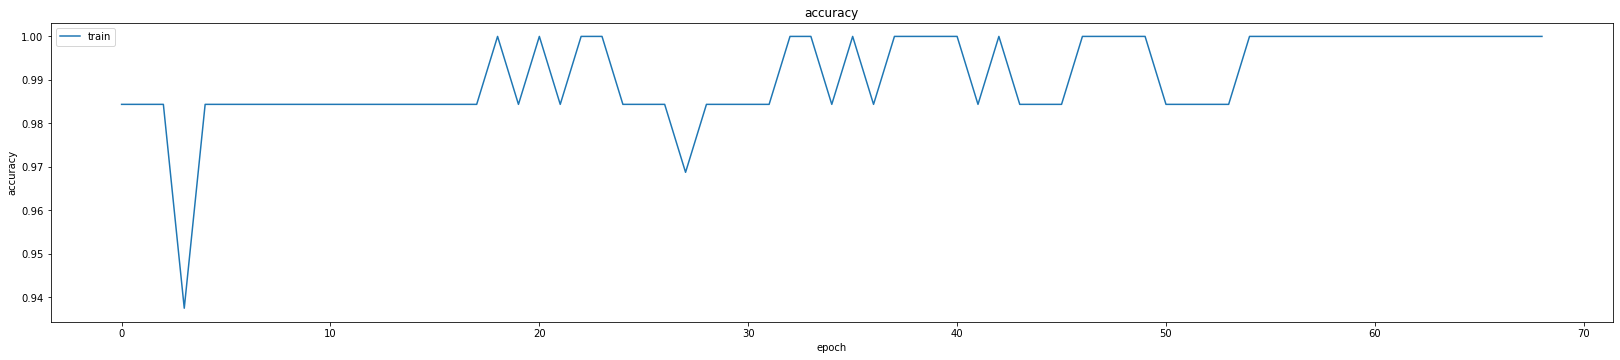

9472 9536


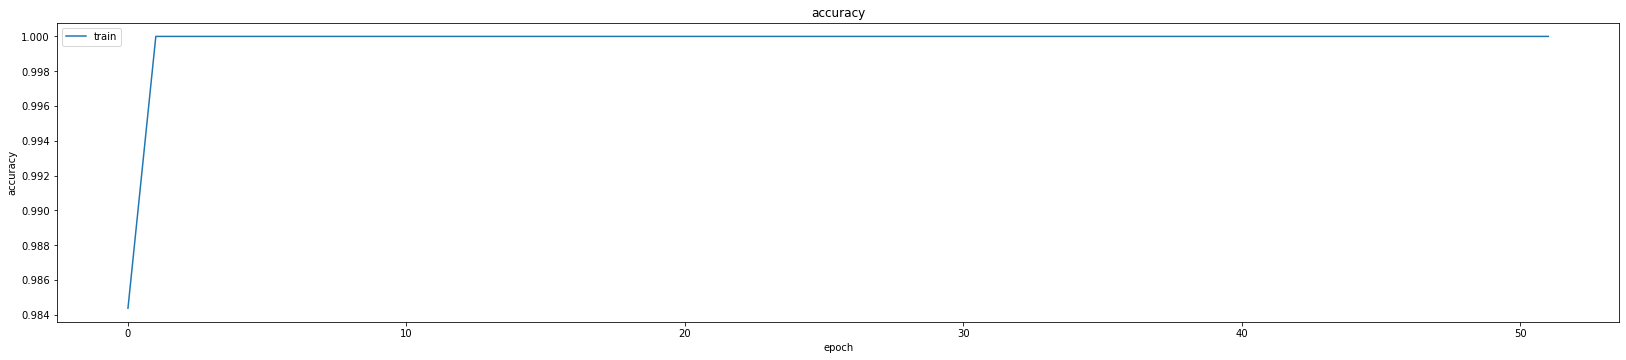

9536 9600


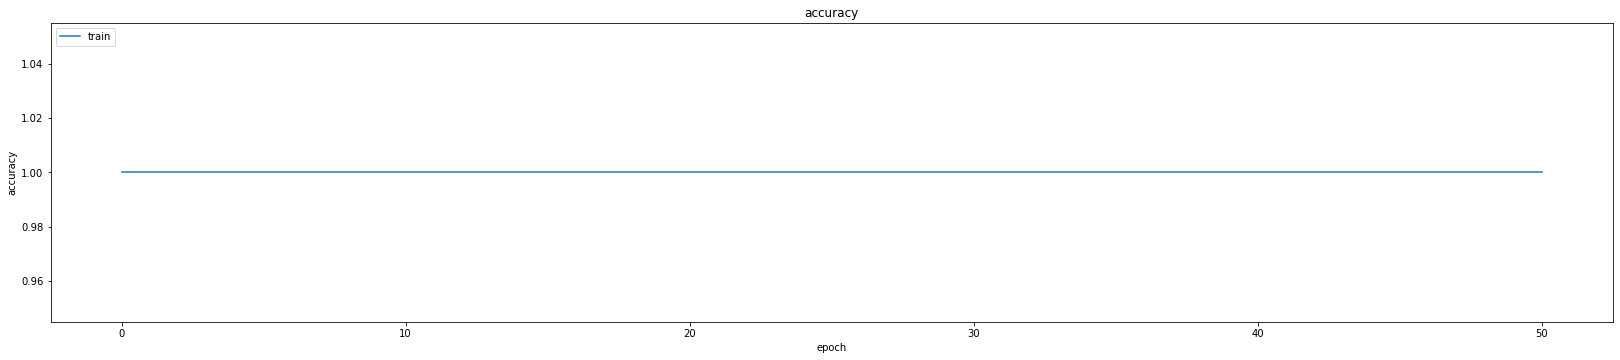

9600 9664


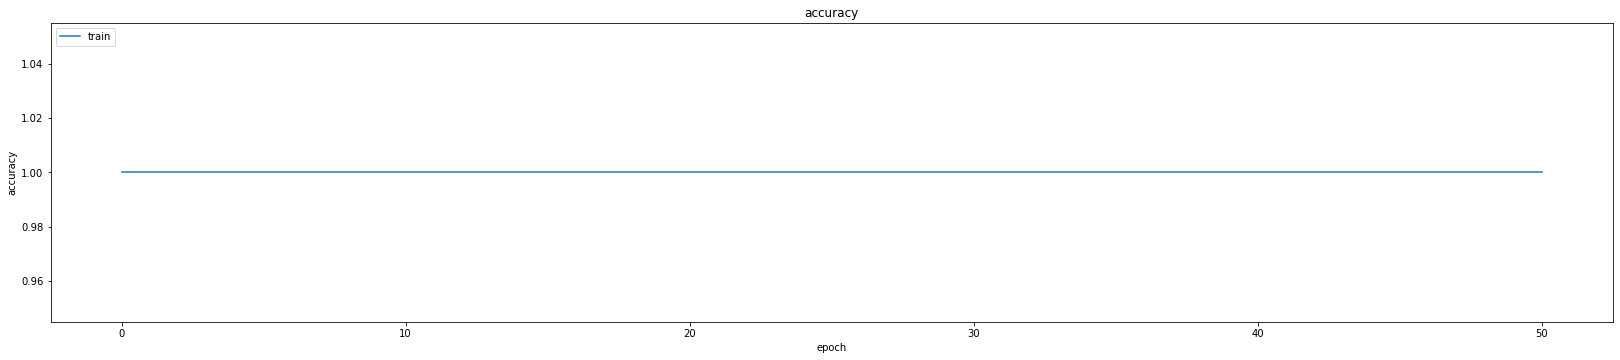

9664 9728


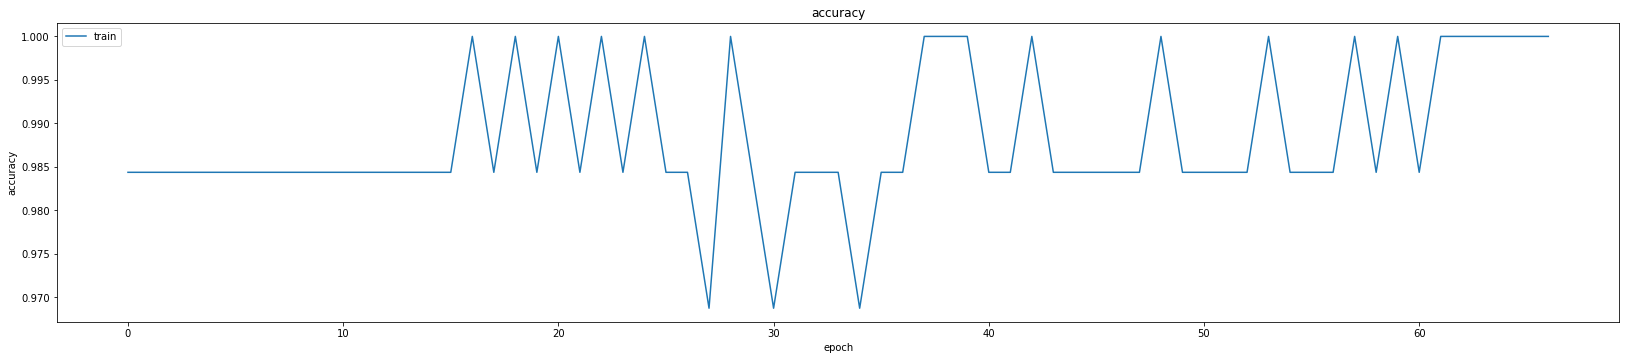

9728 9792


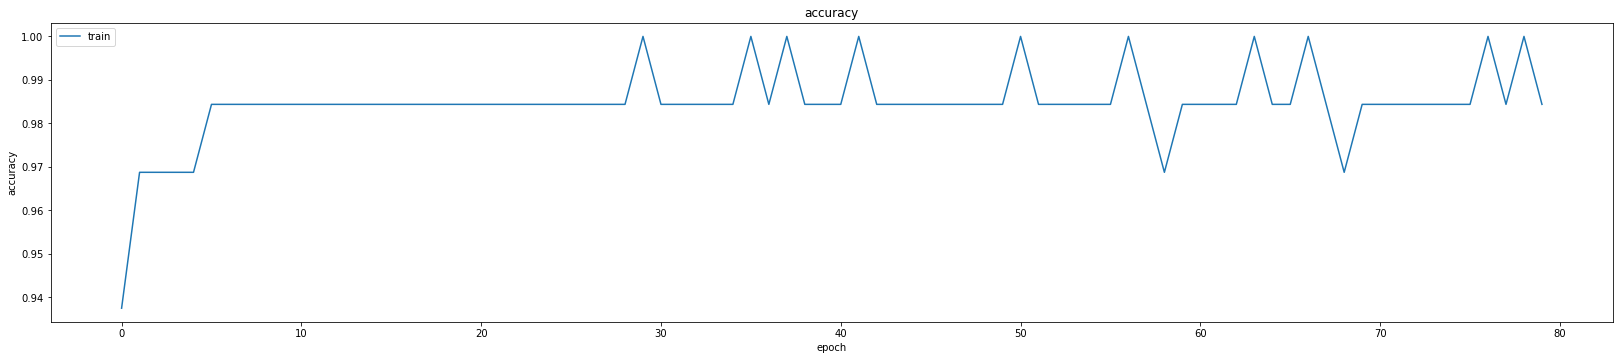

9792 9856


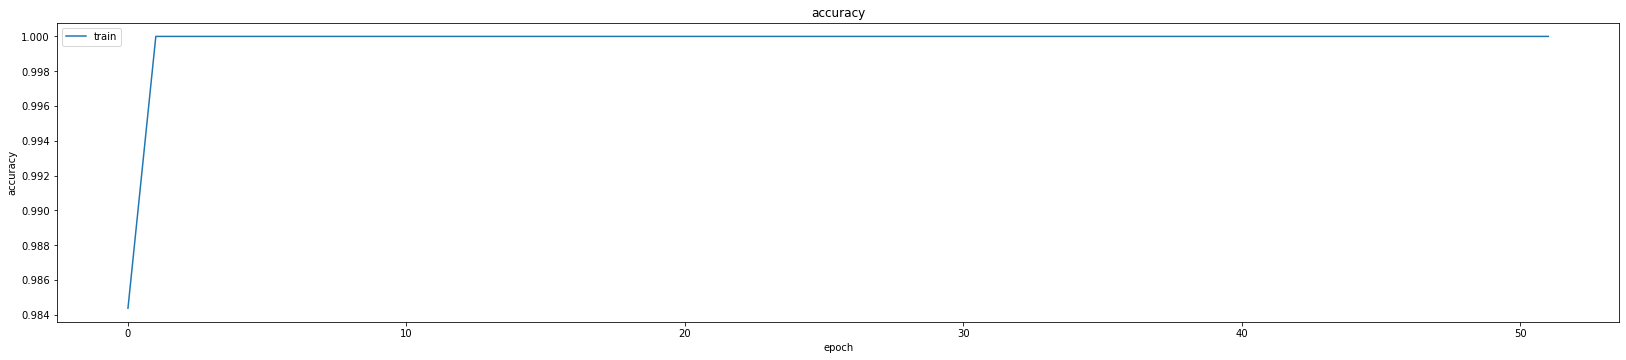

9856 9920


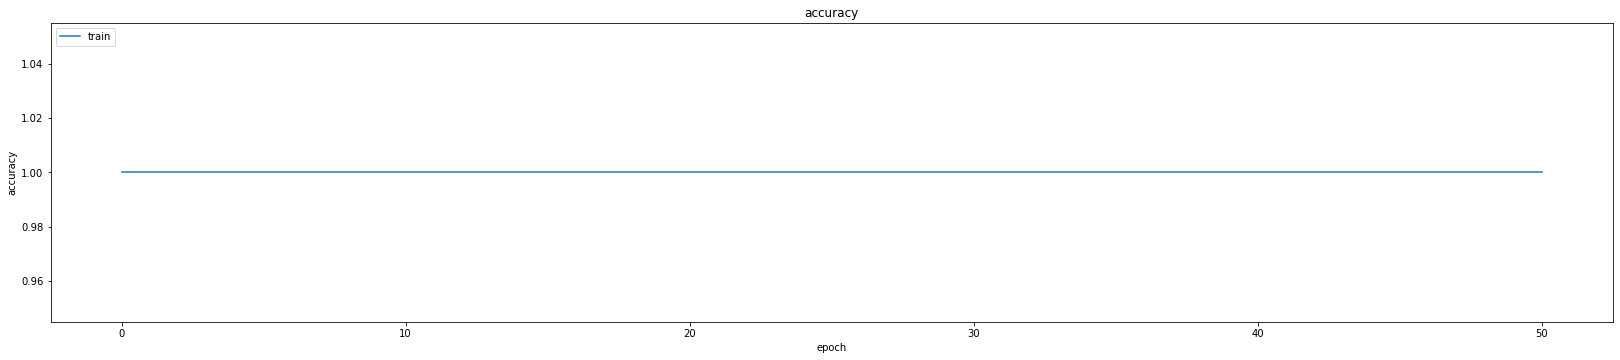

9920 9984


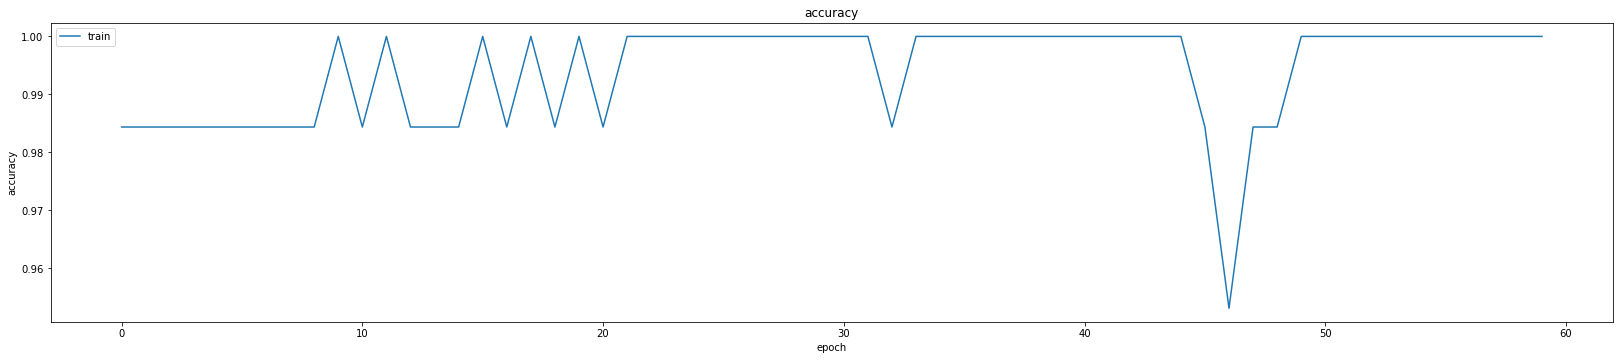

9984 10048


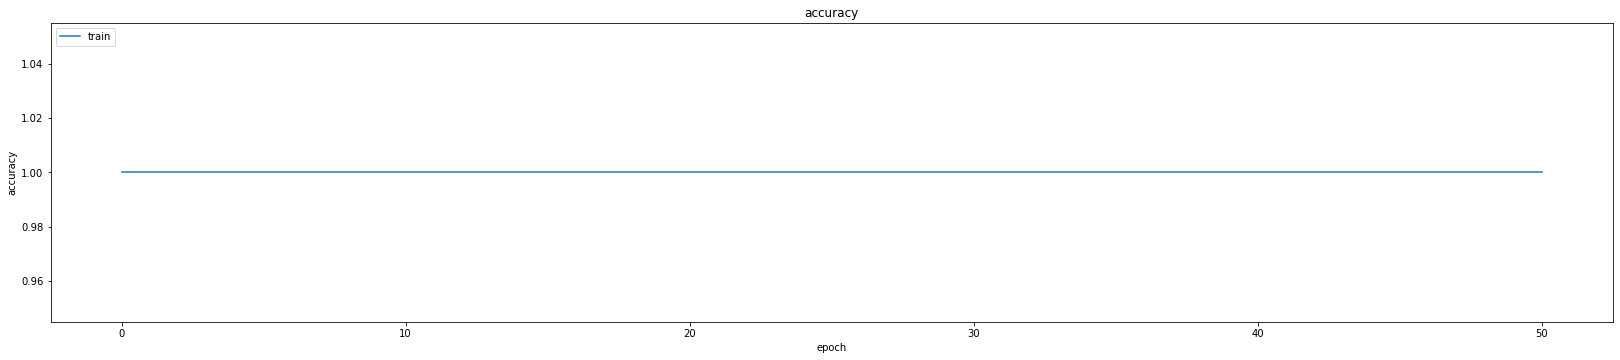

10048 10112


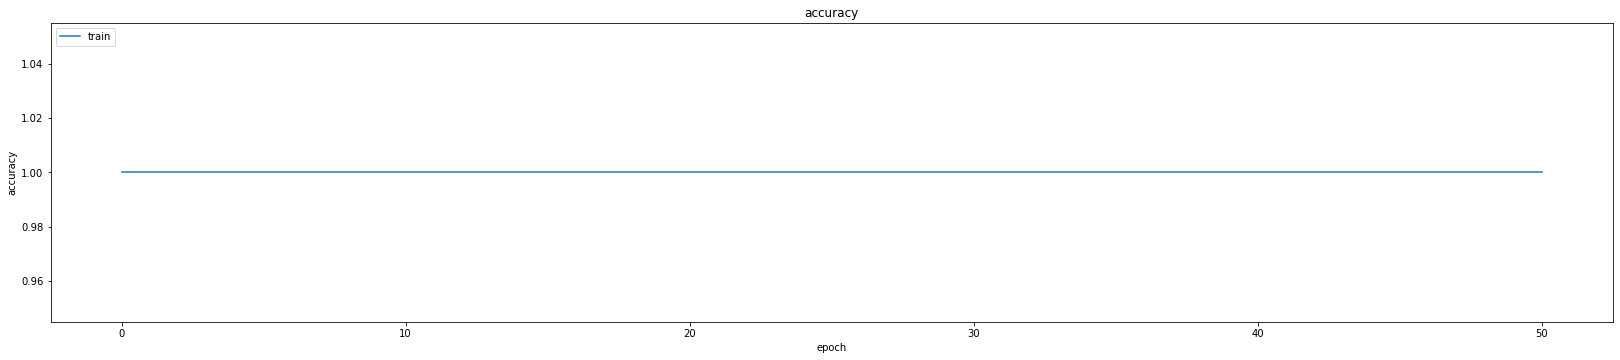

10112 10176


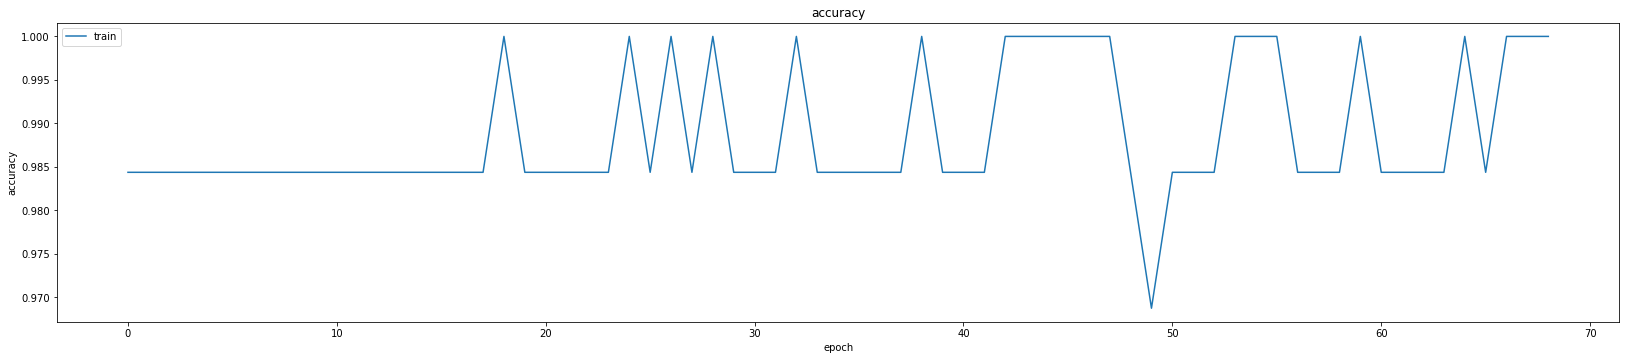

10176 10240


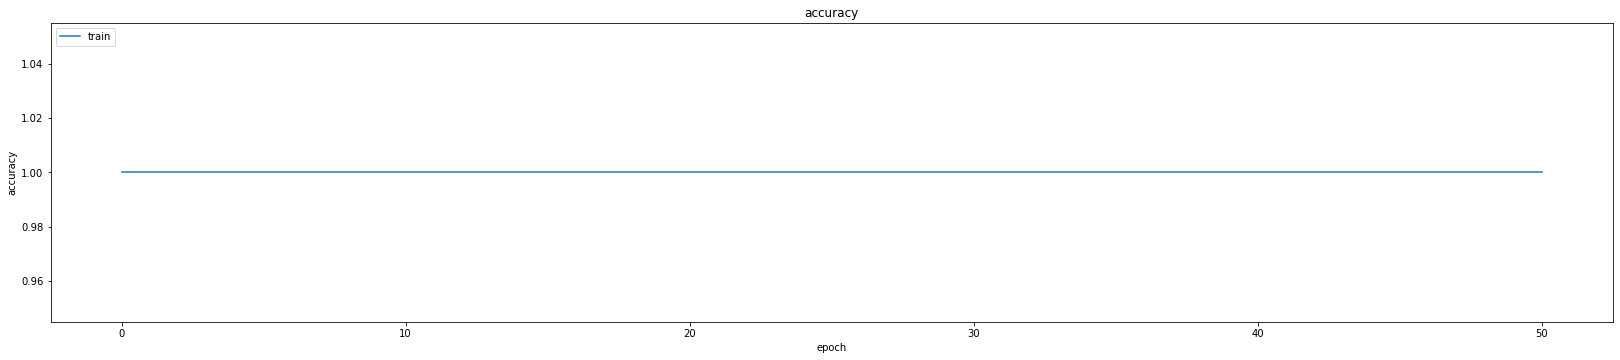

10240 10304


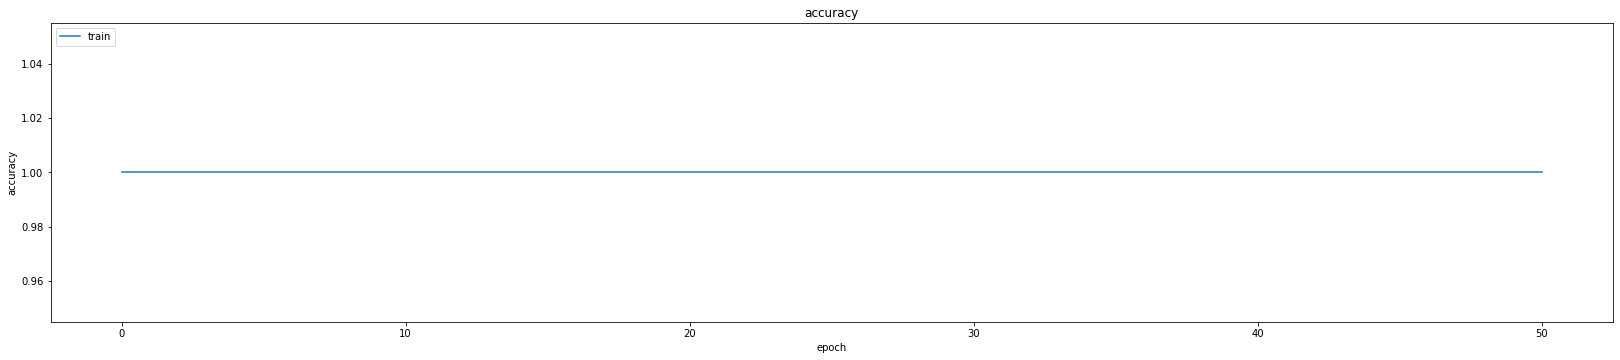

10304 10368


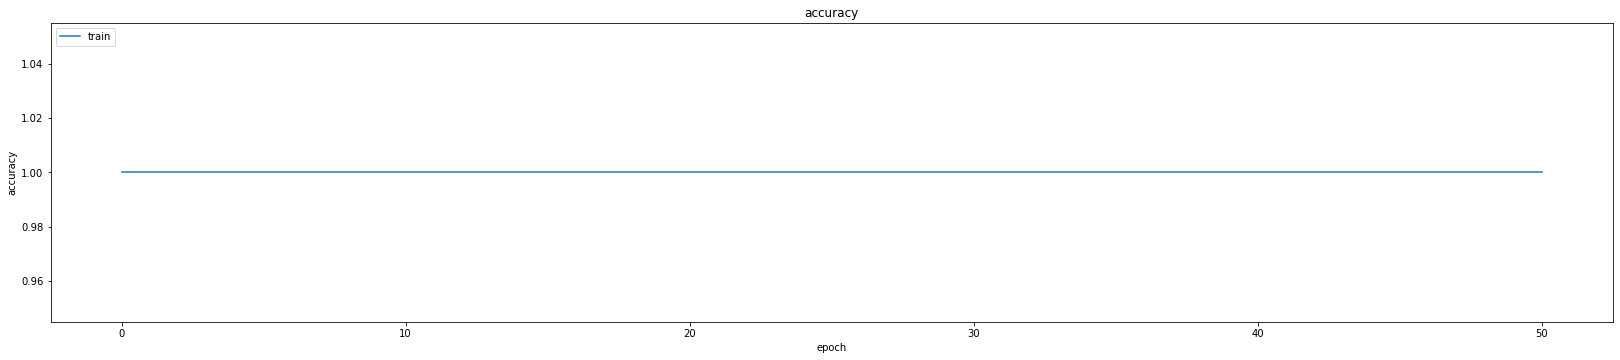

In [ ]:
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_equipment_model.h5"

batch_size=64
start_pos=0
look_back=1
early_stopping = EarlyStopping(monitor='accuracy', patience=50)
count=320
for index in range(start_pos,length,batch_size):
    if(index>0):
        file_exists = exists(path_to_file)
        if(file_exists):
            model.load_weights(path_to_file)
            #print("loaded weights")
        
        X2 = np.asarray(X_train[index-batch_size:index]).astype(np.float32)
        X2 = np.resize(X2,(X2.shape[0],look_back,X2.shape[1]))
        y2 = np.asarray(y_train[index-batch_size:index]).astype(np.float32)
        history=model.fit(X2,y2,batch_size=len(X),epochs=500,verbose=0,callbacks=[early_stopping])
        model.save_weights(path_to_file) # can give whole path to save model
        #print("saved weights")
        if (count%1000>=1):
            print(index-batch_size,index)
            plotHistory(history)
        count+=1

In [ ]:
print("Random select indices from the dataframe then make a prediction")
size=len(df)
randomlist=[]
for i in range(0,10):
    n = random.randint(1,size)
    randomlist.append(n)
#print(randomlist)

look_back=1
X3=df[X_columns].iloc[randomlist]
y3=df['label'].iloc[randomlist]
y3 = pd.get_dummies(y3)

X3 = np.asarray(X3).astype(np.float32)
X3 = np.resize(X3,(X3.shape[0],look_back,X3.shape[1]))
y_pred=model.predict(X3)

#lstfailure_types=next(iter(failure_types))
for item in y_pred:
    print("failure type",np.argmax(item))

auc=roc_auc_score(y3, y_pred)
print(auc)


In [15]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 550)            1225400   
                                                                 
 dropout (Dropout)           (None, 1, 550)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            260400    
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 flatten (Flatten)           (None, 50)                0

In [ ]:
 auc=roc_auc_score(y, predictions)